# Read in Data

In [132]:
import pandas as pd
import numpy as np
import nibabel as nib
import os
import scipy.stats as scp
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import itertools
from scipy.signal import hilbert
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import scipy.signal as scs
import json
import pickle
import plotly.graph_objects as go
from tqdm.auto import tqdm
from itertools import combinations
import statsmodels.formula.api as smf

sns.set(context='talk', style='white', font='Arial')

today = date.today().strftime('%Y%m%d')

project_dir = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/'
data_dir = project_dir + 'proc/group/parcel_timeseries/sub_ts/'
out_dir = project_dir + 'proc/clin/'
os.makedirs(out_dir,exist_ok=True)

sample_file = project_dir + 'proc/group/datasets_info/sample_gord.32k_fs_LR.pscalar.nii'
atlas_file = project_dir + 'proc/null_lL_WG33/Gordon333_SeitzmanSubcortical.32k_fs_LR.dlabel.nii'

ax0 = nib.load(sample_file).header.get_axis(0)
ax1 = nib.load(sample_file).header.get_axis(1)

TR = 0.8

# get network labels
parcel_labels = nib.load(sample_file).header.get_axis(1).name
network_labels = []
for s in parcel_labels:
    b = s.split('_')
    if len(b)<2:
        network_labels.append(b[0])
    else:
        network_labels.append(b[1])
network_labels = np.array(network_labels)
network_names, network_sizes = np.unique(network_labels, return_counts=True)

# load additional socio-emotional functioning DVs
sas = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SAS_20210322.csv'), header=0, skiprows=[1],
                  index_col='EID').loc[:, ['SAS_01','SAS_02','SAS_03','SAS_04','SAS_05','SAS_06',
                                                'SAS_07','SAS_08','SAS_09','SAS_10']]
sas['SAS_Total'] = sas.sum(axis=1)
sas.index = ['sub-{0}'.format(a) for a in sas.index]
sas.index.name = 'sub'

srsp = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SRS_Pre_20210322.csv'), header=0, skiprows=[1],
                  index_col='EID').loc[:, ['SRS_Pre_AWR','SRS_Pre_COG','SRS_Pre_COM','SRS_Pre_MOT','SRS_Pre_SCI','SRS_Pre_Total']]
srsp.index = ['sub-{0}'.format(a) for a in srsp.index]
srsp.index.name = 'sub'
srss = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SRS_20210322.csv'), header=0, skiprows=[1],
                  index_col='EID').loc[:, ['SRS_AWR','SRS_COG','SRS_COM','SRS_MOT','SRS_SCI','SRS_Total']]
srss.index = ['sub-{0}'.format(a) for a in srss.index]
srss.index.name = 'sub'
srsp.columns = srss.columns
srs = pd.concat((srsp, srss), axis=0)

scq = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_SCQ_20210322.csv'), header=0, skiprows=[1],
                  index_col='EID').loc[:, ['SCQ_Total']]
scq.index = ['sub-{0}'.format(a) for a in scq.index]
scq.index.name = 'sub'

social_vars = ['SAS_Total','SCQ_Total'] + srs.columns.to_list()

# load stress variables
stress = pd.read_csv(os.path.join(project_dir, 'phenotypic_data','9994_NLES_P_20210322.csv'), header=0, skiprows=[1],
                  index_col='EID').loc[:, ['NLES_P_TotalEvents','NLES_P_Aware','NLES_P_Upset_Total','NLES_P_Upset_Avg']]
stress.index = ['sub-{0}'.format(a) for a in stress.index]
stress.index.name = 'sub'

stress_vars = stress.columns.to_list()

# load timeseries data info
subinfo = pd.read_csv(project_dir + 'proc/group/datasets/firstleveldatalabels_withpub_thresh0.8_20220412.csv', index_col=0)
clininfo = pd.read_csv(os.path.join(out_dir, 'depanx_scores_preproc_20220519.csv'), low_memory=False, index_col=0).drop(['age'],axis=1)
subinfo = subinfo.merge(clininfo, how='left', left_index=True, right_index=True)
subinfo = subinfo.drop(['set','sub','cond'], axis=1)
subinfo = subinfo.drop_duplicates()
subinfo.index.name='sub'

# add in social functioning & stress variables
subinfo = subinfo.merge(sas.loc[:,'SAS_Total'], how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(srs, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(scq, how='left', left_index=True, right_index=True)
subinfo = subinfo.merge(stress, how='left', left_index=True, right_index=True)

# set up functions

In [42]:
def compile_ts_data(subdf, movie, datadir, outfile):
    """
    combine data for each movie together into 1 file
    
    Parameters
    ----------
    subdf: DataFrame
        A dataframe with subject IDs as the index. Includes IDs for all usable data.
    movie: str
        Corresponds with the str for the movie content to concatenate (e.g., "DM" or "TP").
    datadir: folder path
        Path to folder with the subject timeseries ciftis.
    outfile: file path
        Path including filename to save the output data of shape Ntimepoints x Nparcels x Nsubjects.
    
    Returns
    -------
    data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    if not isinstance(subdf, pd.DataFrame):
        subdf = pd.read_csv(subdf, index_col=0)
    
    for sub in subdf.index:
        file = '{0}{1}_task-movie{2}_bold1_AP_Atlas_rescale_resid0.9_filt_gordonseitzman.32k_fs_LR.ptseries.nii'.format(datadir,sub, movie)
        if sub == subdf.index[0]:
            data = StandardScaler().fit_transform(nib.load(file).get_fdata())
            data = np.expand_dims(data, axis=2)
        else:
            t = StandardScaler().fit_transform(nib.load(file).get_fdata())
            t = np.expand_dims(t, axis=2)
            data = np.concatenate([data,t],axis=2)
    
    print('Compile data from {0} brain regions measured at {1} timepoints from {2} participants.'.format(data.shape[1],data.shape[0],data.shape[2]))
    np.save(outfile, data)
    return(data)


def compute_group_phase(group_ts_data, outfile):
    """
    convert parcel ts to standard units & compute phase angles for each parcel ts
    
    Parameters
    ----------
    group_ts_data: filepath OR numpy array
        File or numpy array with compiled timeseries data of shape Ntimepoints x Nparcels x Nsubjects 
    
    Returns
    -------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
    """
    
    if not isinstance(group_ts_data, np.ndarray):
        group_ts_data = np.load(group_ts_data)
    
    group_phase_data = np.zeros_like(group_ts_data)
    
    for a in range(0,group_ts_data.shape[1]):
        for b in range(0,group_ts_data.shape[2]):
            group_phase_data[:,a,b] = np.angle(hilbert(group_ts_data[:,a,b]), deg=False)
    
    np.save(outfile, group_phase_data)
    
    return(group_phase_data)

In [43]:
def compute_isps(group_phase_data, outprefix, savemean=True):
    """
    parcel-wise inter-subject phase synchrony- output pairwise IPS and mean global IPS
    
    Parameters
    ----------
    group_phase_data: numpy array
        The compiled data of shape Ntimepoints x Nparcels x Nsubjects
        
    Returns
    -------
    isps_data: numpy array
        intersubject phase synchrony data of shape Nparcels x Nsubjects x Nsubjects x Ntimepoints
    mean_isps_data: numpy array
        intersubject phase synchrony data, averaged across time, of shape Nparcels x Nsubjects x Nsubjects
        
    """
    if not isinstance(group_phase_data, np.ndarray):
        group_phase_data = np.load(group_phase_data)
    
    if os.path.isdir(outprefix):
        file_name = os.path.join(outprefix, 'isps_data.dat')
    else:
        file_name = outprefix + 'isps_data.dat'

    isps_data = np.memmap(file_name, dtype=np.float32, mode='w+',
                          shape=(group_phase_data.shape[1],group_phase_data.shape[2],
                                 group_phase_data.shape[2],
                                 group_phase_data.shape[0]))
    
    subs = range(0, group_phase_data.shape[2])
    for region in range(0, group_phase_data.shape[1]):
        combs = itertools.combinations(subs, 2)
        for c in combs:
            sub1 = group_phase_data[:, region, c[0]]
            sub2 = group_phase_data[:, region, c[1]]
            a = 1 - np.sin(np.abs(sub1 - sub2) / 2)
            isps_data[region,c[0],c[1],:] = a
            isps_data[region,c[1],c[0],:] = a
        
    if savemean:
        mask = np.tri(isps_data.shape[2], isps_data.shape[2], -1, dtype=int)
        mean_isps_data = np.mean(isps_data[:,mask==1,:], axis=1)
        if os.path.isdir(outprefix):
            mean_file_name = os.path.join(outprefix, 'mean_isps_data.npy')
        else:
            mean_file_name = outprefix + 'mean_isps_data.npy'
        
        np.save(mean_file_name, mean_isps_data.T)
    
        return(mean_isps_data, isps_data)
    else:
        return(isps_data)


def intersubject_timeseries_correlation(data, outprefix, ax0=ax0, ax1=ax1):
    """
    Parameters
    ----------
    data: numpy array
        data in the shape of Ntimepoints x Nregions x Nsubjects
    outprefix: str
        name to save ISC data to
    
    Returns
    -------
    intersub_isc: numpy array
        intersubject spearman correlations in the shape of Nregions x Nsubjects x Nsubjects
    group_isc: numpy array
        group mean spearman correlations in the shape of Nregions
    """
    subs = range(0,data.shape[2])
    
    intersub_isc = np.zeros((data.shape[1],data.shape[2],data.shape[2]))
    group_isc = np.zeros((data.shape[1]))
    mask = np.tri(data.shape[2], data.shape[2], -1, dtype=int)
    
    for r in range(0, data.shape[1]):
        intersub_isc[r, :, :]= np.corrcoef(data[:, r, :], rowvar=False)
            
    for r in range(0, data.shape[1]):
        group_isc[r] = np.mean(intersub_isc[r,:,:][mask==1])
    
    np.save(outprefix + 'intersub_timeseries_ISC.npy', intersub_isc)
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(group_isc, axis=0), (ax0, ax1))
    nib.save(img, outprefix + 'mean_timseries_ISC.pscalar.nii')
    
    return(intersub_isc, group_isc)


def intersubject_distance(data, outfile_prefix):
    """
    Compute static pairwise intersubject similarity
    
    Parameters
    ----------
    data: numpy array
        1D array of subject data (i.e., each participant contributes exactly 1 measure)
    outfilename: str
        name to save distance data to
    
    Returns
    -------
    isdistances: numpy array
        intersubject distances in the shape of Nsubjects x Nsubjects x Nmetrics
    """
    subs = range(0,data.shape[0])


    # NN
    nn = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        nn[c[0],c[1]] = np.max(data) - abs(data[c[0]] - data[c[1]])
        nn[c[1],c[0]] = np.max(data) - abs(data[c[0]] - data[c[1]])
    np.save(outfile_prefix + '_NN.npy', nn)

    # AnnaK mean
    annakmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmean[c[0],c[1]] = (data[c[0]] + data[c[1]]) / 2
        annakmean[c[1],c[0]] = (data[c[0]] + data[c[1]]) / 2
    np.save(outfile_prefix + '_annakmean.npy', annakmean)
    
    # AnnaK max min mean
    AnnaKmaxminmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        AnnaKmaxminmean[c[0],c[1]] = np.max(data) - ((data[c[0]] + data[c[1]]) / 2)
        AnnaKmaxminmean[c[1],c[0]] = np.max(data) - ((data[c[0]] + data[c[1]]) / 2)
    np.save(outfile_prefix + '_annakmaxminmean.npy', AnnaKmaxminmean)

    # AnnaK min
    annakmin = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmin[c[0],c[1]] = min([data[c[0]],data[c[1]]])
        annakmin[c[1],c[0]] = min([data[c[0]],data[c[1]]])
    np.save(outfile_prefix + '_annakmin.npy', annakmin)

    # AnnaK max minus min
    annakmaxminmax = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakmaxminmax[c[0],c[1]] =np.max(data) -  max([data[c[0]],data[c[1]]])
        annakmaxminmax[c[1],c[0]] = np.max(data) - max([data[c[0]],data[c[1]]])
    np.save(outfile_prefix + '_annakmaxminmax.npy', annakmaxminmax)
        
    # AnnaK absmean
    annakabsmean = np.zeros((data.shape[0],data.shape[0]))
    combs = itertools.combinations(subs, 2)
    for c in combs:
        annakabsmean[c[0],c[1]] = abs(data[c[0]] - data[c[1]]) * ((data[c[0]] + data[c[1]]) / 2)
        annakabsmean[c[1],c[0]] = abs(data[c[0]] - data[c[1]]) * ((data[c[0]] + data[c[1]]) / 2)
    np.save(outfile_prefix + '_annakabsmean.npy', annakabsmean)
    
    isdistances = {'NN': nn, 
                   'AnnaKmean': annakmean, 
                   'AnnaKmin': annakmin, 
                   'AnnaKabsmean': annakabsmean, 
                   'AnnaKmaxminmean': AnnaKmaxminmean, 
                   'AnnaKmaxminmax': annakmaxminmax}
    return(isdistances)

In [44]:
def static_brain_bx_isrsa(brain_sim_data, bx_sim_data, outfilename=None):
    """
    
    Parameters
    ----------
    brain_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    rsa_report: pandas DataFrame
        Pandas DataFrame with inter-subject representational similarity statistics
    """
    rsa_report = pd.DataFrame(columns=['SpearR','SpearPvalue'])
    
    mask = np.tri(bx_sim_data.shape[0], bx_sim_data.shape[0], -1, dtype=int)
    bx_sim = bx_sim_data[mask==1]
    brain_sim = brain_sim_data[mask==1]
    
    r, p = scp.spearmanr(bx_sim, brain_sim)
    rsa_report.loc[0,'SpearR'] = r
    rsa_report.loc[0,'SpearPvalue'] = p
    if outfilename:
        sns.scatterplot(bx_sim, brain_sim)
        plt.title('Similarity Correlation')
        plt.tight_layout()
        plt.savefig(outfilename)
        plt.show()
        plt.close()
    
    return(rsa_report)

def regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix, alpha=0.05, n_perms=1000, ax0=ax0, ax1=ax1):
    """
    
    Parameters
    ----------
    regional_sim_data: numpy ndarray
        Data in the shape of Nregions x Nsubjects x Nsubjects
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    region_isrsa: numpy ndarray
        Data in the shape of Nregions
    """
    
    mask = np.tri(bx_sim_data.shape[1], bx_sim_data.shape[1], -1, dtype=int)

    # flatten behavior lower triangle
    bx_sim = bx_sim_data[mask==1]

    region_isrsa = np.zeros((regional_sim_data.shape[0]))

    for region in range(0, regional_sim_data.shape[0]):
            brain_sim = regional_sim_data[region,:,:][mask==1]
            r, p = scp.spearmanr(bx_sim, brain_sim)
            region_isrsa[region] = r

    shuff_bx = bx_sim
    perm_isrsa_null = np.zeros((n_perms, regional_sim_data.shape[0]))

    # make null distributions for each TR and region
    for a in range(0,n_perms):
        np.random.shuffle(shuff_bx)
        for region in range(0,regional_sim_data.shape[0]):
            brain_sim = regional_sim_data[region,:,:][mask==1]
            r, p = scp.spearmanr(shuff_bx, brain_sim)
            perm_isrsa_null[a, region] = r

    # compute permuted P threshold per region/TR
    raw_pvals = np.zeros(region_isrsa.shape)
    flat_null = perm_isrsa_null.flatten()
    for i, a in enumerate(region_isrsa):
        raw_pvals[i] = (np.sum((flat_null>=a).astype(int)) + 1) / (flat_null.shape[0] + 1)
        
    # save ciftis with raw values
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(raw_pvals, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_raw_pval.pscalar.nii')
    
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(region_isrsa, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_raw_rho.pscalar.nii')
    
    
    # save cifti with significant rhos only
    thresh_mask = raw_pvals<alpha

    # pvals
    thresh_pval = raw_pvals
    thresh_pval[thresh_mask==0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(thresh_pval, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_masked_pval{0}.pscalar.nii'.format(alpha))

    # rhos
    thresh_isrsa = region_isrsa
    thresh_isrsa[thresh_mask==0] = np.nan
    thresh_isrsa[thresh_isrsa<0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(np.expand_dims(thresh_isrsa, axis=0), (ax0, ax1))
    nib.save(img, outprefix + '_permsim_masked_rho{0}.pscalar.nii'.format(alpha))
    return(thresh_isrsa)


# compute dynamic similarity
def dynamic_brain_bx_isrsa(time_region_sim_data, bx_sim_data, outprefix, ax1=ax1):
    """
    
    Parameters
    ----------
    time_region_sim_data: numpy ndarray
        Data in the shape of Nregions x Nsubjects x Nsubjects x Ntimepoints
    bx_sim_data: numpy ndarray
        Data in the shape of Nsubjects x Nsubjects
        
    Returns
    -------
    dynamic_isrsa: pandas DataFrame
        Pandas DataFrame with inter-subject representational similarity statistics
    """
    mask = np.tri(bx_sim_data.shape[1], bx_sim_data.shape[1], -1, dtype=int)

    # flatten behavior lower triangle
    bx_sim = bx_sim_data[mask==1]

    dynamic_isrsa = np.zeros((isps_data.shape[3],isps_data.shape[0]))

    for region in range(0, isps_data.shape[0]):
        for tr in range(0, isps_data.shape[3]):
            brain_sim = isps_data[region,:,:,tr][mask==1]
            r, p = scp.spearmanr(bx_sim, brain_sim)
            dynamic_isrsa[tr, region] = r
            
    np.save(outfile_prefix + '_dynamicsim.npy', dynamic_isrsa)
    
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,0.8,dynamic_isrsa.shape[0], unit='second')
    img = nib.cifti2.cifti2.Cifti2Image(dynamic_isrsa, (ax0, ax1))
    nib.save(img, outfile_prefix + '_dynamicsim.ptseries.nii')

    return(dynamic_isrsa)


def perm_sig_dynamic_isrsa(time_region_sim_data, bx_sim_data, outprefix, n_perms=30, ax1=ax1, alpha=0.05, TR=0.8):
    """
    
    
    """
    
    dynamic_isrsa = dynamic_brain_bx_isrsa(time_region_sim_data, bx_sim_data, outprefix)
    
    if os.path.isfile(os.path.join(outprefix + '_perm_isrsa_null.dat')):
        perm_isrsa_null = np.memmap(os.path.join(outprefix + '_perm_isrsa_null.dat'), dtype=np.float32, mode='r',
                                    shape=(n_perms, isps_data.shape[3], isps_data.shape[0]))
    else:
        perm_isrsa_null = np.memmap(os.path.join(outprefix + '_perm_isrsa_null.dat'), dtype=np.float32, mode='w+',
                                    shape=(n_perms, isps_data.shape[3], isps_data.shape[0]))
        shuff_bx = bx_sim_data

        # make null distributions for each TR and region
        for a in range(0,n_perms):
            np.random.shuffle(shuff_bx)
            perm_isrsa_null[a, :, :] = dynamic_brain_bx_isrsa(time_region_sim_data, shuff_bx, outprefix)
    
    # compute permuted P threshold per region/TR
    orig_shape = dynamic_isrsa.shape
    flat_dyn_isrsa = dynamic_isrsa.flatten()
    raw_pvals = np.zeros(flat_dyn_isrsa.shape)
    flat_null = perm_isrsa_null.flatten()
    for i, a in enumerate(flat_dyn_isrsa):
        raw_pvals[i] = (np.sum((flat_null>=a).astype(int)) + 1) / (flat_null.shape[0] + 1)

    raw_pvals = np.reshape(raw_pvals, orig_shape)
    
    # save cifti
    ax0 = nib.cifti2.cifti2_axes.SeriesAxis(0,TR,raw_pvals.shape[0], unit='second')
    img = nib.cifti2.cifti2.Cifti2Image(dynamic_isrsa, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_raw_rho.ptseries.nii')
    img = nib.cifti2.cifti2.Cifti2Image(raw_pvals, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_raw_pval.ptseries.nii')
    
    # save cifti with significant rhos only
    thresh_mask = raw_pvals<alpha

    # pvals
    thresh_pval = raw_pvals
    thresh_pval[thresh_mask==0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(thresh_pval, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_thresh_pval{0}.ptseries.nii'.format(alpha))
    # rhos
    thresh_isrsa = dynamic_isrsa
    thresh_isrsa[thresh_mask==0] = np.nan
    thresh_isrsa[thresh_isrsa<0] = np.nan
    img = nib.cifti2.cifti2.Cifti2Image(thresh_isrsa, (ax0, ax1))
    nib.save(img, outprefix + '_permdynamicsim_thresh_rho{0}.ptseries.nii'.format(alpha))

In [45]:
def region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix, alpha=0.05, bon_alpha=True,replace_zeros=True, ax0=ax0, ax1=ax1):
    """
    
    
    """
    
    disc_rho = nib.load(disc_rho).get_fdata()
    disc_pval = nib.load(disc_pval).get_fdata()
    rep_rho = nib.load(rep_rho).get_fdata()
    rep_pval = nib.load(rep_pval).get_fdata()
    
    if replace_zeros:
        disc_pval[disc_pval==0] = np.nan
        rep_pval[rep_pval==0] = np.nan
    
    if bon_alpha==True:
        bon_alpha = np.sqrt(alpha/disc_pval.shape[1])
    else:
        bon_alpha = alpha

    dmask = (disc_pval<bon_alpha).astype(int)
    rmask = (rep_pval<bon_alpha).astype(int)

    mask = np.zeros(dmask.shape)
    mask[(dmask==1) & (rmask==1)] = 1

    bonrho = np.empty(mask.shape)
    bonrho[mask==1] = np.add(disc_rho[mask==1],rep_rho[mask==1])/2
    bonrho[mask==0] = np.nan

    img = nib.cifti2.cifti2.Cifti2Image(bonrho, (ax0, ax1))
    nib.save(img, outprefix + '_maskedrho_fdr{0}.pscalar.nii'.format(round(bon_alpha,5)))
    
    
def dynamic_isrsa_fdr(disc_rho, rep_rho, discN, repN, video_dur, ratings_file, outprefix, TR=TR, alpha=0.05, parcel_labels=parcel_labels):
    
    # assign thresholds
    bon_alpha = np.sqrt(0.05/disc_rho.shape[1])
    discbonnmint = scp.t.ppf(1-bon_alpha, discN-1)
    discuncorrmint = scp.t.ppf(1-alpha, discN-1)
    repbonnmint = scp.t.ppf(1-bon_alpha, repN-1)
    repuncorrmint = scp.t.ppf(1-alpha, repN-1)

    # convert rho to t-stat
    disc_tstat = disc_rho/np.sqrt((1-disc_rho**2)/(discN-2))
    rep_tstat = rep_rho/np.sqrt((1-rep_rho**2)/(repN-2))

    # find sig ts that replicate
    disc_sigts =  (disc_tstat > discbonnmint).astype(int)
    rep_sigts =  (rep_tstat > repbonnmint).astype(int)

    sigts = np.zeros(disc_sigts.shape).astype(int)
    sigts[(disc_sigts==1) & (rep_sigts==1)] = 1
    if sigts.max()==0:
        print('No significant findings.')
    else:
        print('At least one region is significantly simliar.')
    
    # Plot and analysis replicating peaks
    times = np.arange(0, video_dur, TR)

    results = dict()

    ### Make plots ###
    for p, parcel in enumerate(parcel_labels):
        if np.max(sigts.T[p])==1:
            # set up figure
            fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
            # plot discovery
            dupeaks, duproperties = scs.find_peaks(disc_tstat.T[p], width=5, prominence=discuncorrmint)

            ax[0].plot(times, disc_tstat.T[p], color='k')
            for i_c, c in enumerate(duproperties['prominences']):
                ax[0].axvspan(duproperties['left_ips'][i_c]*TR, duproperties['right_ips'][i_c]*TR,
                            color='r', alpha=0.3)
            dcpeaks, dcproperties = scs.find_peaks(disc_tstat.T[p], width=5, prominence=discbonnmint)
            for i_c, c in enumerate(dcproperties['prominences']):
                ax[0].axvspan(dcproperties['left_ips'][i_c]*TR, dcproperties['right_ips'][i_c]*TR,
                            color='b', alpha=0.3)
            ax[0].set_xlim([0,video_dur])
            ax[0].set_title(parcel + ': Discovery', weight='bold')
            ax[0].set_ylabel('Similarity (t-stat)')

            # plot replication
            rupeaks, ruproperties = scs.find_peaks(rep_tstat.T[p], width=5, prominence=repuncorrmint)
            ax[1].plot(times, rep_tstat.T[p], color='k')
            for i_c, c in enumerate(ruproperties['prominences']):
                ax[1].axvspan(ruproperties['left_ips'][i_c]*TR, ruproperties['right_ips'][i_c]*TR,
                            color='r', alpha=0.3)
            rcpeaks, rcproperties = scs.find_peaks(rep_tstat.T[p], width=5, prominence=repbonnmint)
            for i_c, c in enumerate(rcproperties['prominences']):
                ax[1].axvspan(rcproperties['left_ips'][i_c]*TR, rcproperties['right_ips'][i_c]*TR,
                            color='b', alpha=0.3)
            ax[1].set_xlim([0,video_dur])
            ax[1].set_title(parcel + ': Replication', weight='bold')
            ax[1].set_ylabel('Similarity (t-stat)')
            ax[1].set_xlabel('Time (s)')
            plt.tight_layout()
            plt.savefig(outprefix + 'peak_similarity_{0}.svg'.format(parcel_labels[p]))
            plt.show()
            plt.close()

            # save results
            dcproperties = {k:v.tolist() for k,v in dcproperties.items()}
            duproperties = {k:v.tolist() for k,v in duproperties.items()}
            rcproperties = {k:v.tolist() for k,v in rcproperties.items()}
            ruproperties = {k:v.tolist() for k,v in ruproperties.items()}
            if (len(ruproperties['left_ips'])>0) & (len(duproperties['left_ips'])>0):
                results[parcel] = {'Discovery': {'corr': dcproperties, 'uncorr': duproperties}, 
                                   'Replication': {'corr': rcproperties, 'uncorr': ruproperties}}
            
            
    ### Characterize differences in ratings for high versus low similarity points in the video ###
    
    # load ratings and shift forward 6 TRs
    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    
    # characterize areas within and outside the peaks
    for parcel in results.keys():
        discmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Discovery']['uncorr']['prominences']):
            start = round(results[parcel]['Discovery']['uncorr']['left_ips'][i])
            end = round(results[parcel]['Discovery']['uncorr']['right_ips'][i])
            discmask[start:end] = 1

        repmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Replication']['uncorr']['prominences']):
            start = round(results[parcel]['Replication']['uncorr']['left_ips'][i])
            end = round(results[parcel]['Replication']['uncorr']['right_ips'][i])
            repmask[start:end] = 1

        tmask = np.zeros(times.shape).astype(int)
        tmask[(discmask==1) & (repmask==1)] = 1

        ratesigdiff = pd.Series(index=ratings.columns, name='sig', dtype=int)
        ratemeans = dict()
        ratestats = dict()
        if tmask.max()==1:
            for measure in ratings.columns:
                underpeak = ratings.loc[tmask==1, measure]
                outofpeak = ratings.loc[tmask==0, measure]
                underpeakmean = np.nanmean(underpeak)
                outofpeakmean = np.nanmean(outofpeak)
                rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
                ratestats[measure] = {'tstat': rate_stat, 'pval': rate_pval}
                ratesigdiff[measure] = rate_pval < alpha
                ratemeans[measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

            results[parcel]['RatingsAnalysis'] = {'MeanRatings': ratemeans, 
                                                  'Stats': ratestats}

            # plot the differences
            sigratingsnames = ratesigdiff[ratesigdiff==True].index.to_list()

            if len(sigratingsnames) < 4:
                ratings_withpeakinfo = ratings
                ratings_withpeakinfo['UnderPeak'] = tmask
                temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
                plt.figure(figsize=(2+2*len(sigratingsnames),6))
                sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF','#BCB1C2'] , linewidth=2, edgecolor='k')
                plt.tight_layout()
                plt.savefig(outprefix + 'peak_ratings_sigdiff_{0}.svg'.format(parcel))
                plt.show()
                plt.close()
            else:
                underpeak = ratings.loc[tmask==1, sigratingsnames].mean(axis=0).to_frame()
                underpeak.columns = ['mean']
                underpeak['width']=0.4
                underpeak['measure'] = underpeak.index
                outofpeak = ratings.loc[tmask==0, sigratingsnames].mean(axis=0).to_frame()
                outofpeak.columns = ['mean']
                outofpeak['width']=0.7
                outofpeak['measure'] = outofpeak.index

                fig = go.Figure()

                fig.add_trace(go.Barpolar(
                    r=outofpeak['mean'],
                    theta=outofpeak['measure'],
                    width=outofpeak['width'],
                    base=0,
                    name='OutOfPeak',
                    marker_color='#FFFFFF',
                    marker_line_color='black',
                    marker_line_width=2,
                    opacity=1,
                ))

                fig.add_trace(go.Barpolar(
                      r=underpeak['mean'],
                      theta=underpeak['measure'],
                    width=underpeak['width'],
                      name='UnderPeak',
                    base=0,
                    marker_color='#BAB3BF',
                    marker_line_color='black',
                    marker_line_width=2,
                    opacity=1,
                ))

                fig.update_layout(
                    template='plotly_white',
                  polar=dict(
                      angularaxis_tickfont_size = 14,
                    radialaxis=dict(
                      visible=True,
                      range=[0, 1]
                    )),
                  showlegend=False
                )

                fig.write_image(outprefix + 'polar_ratings_sigdiff_{0}.svg'.format(parcel))

        
    #save results
    with open(outprefix + 'full_results_corrp{0}_prom{1}_width{2}.json'.format(round(bon_alpha,3), round(discbonnmint,2), 5), 'w') as fp:
        json.dump(results, fp, indent=4)
    return(results)


def synchrony_discrep_fdr_netlevel(disc_mean_sim, disc_null, rep_mean_sim, outprefix, video_dur, alpha=0.05, 
                                   TR=TR, parcel_labels=parcel_labels, atlas_file=atlas_file):
    # assign thresholds
    bon_alpha = np.sqrt(0.05/disc_mean_sim.shape[1])

    n = int(round((len(disc_null)+1)*bon_alpha,0))
    discbonmin = disc_null[len(disc_null)-n]
    n = int(round((len(rep_null)+1)*bon_alpha,0))
    repbonmin = rep_null[len(rep_null)-n]
    if discbonmin < np.percentile(disc_mean_sim, 1-alpha):
        discbonmin = np.percentile(disc_mean_sim, 1-alpha)
        repbonmin = np.percentile(rep_mean_sim, 1-alpha)
    print("Disc sig threshold: {0}".format(discbonmin))
    print("Rep sig threshold: {0}".format(repbonmin))

    # find sig rs that replicate
    disc_sig = (disc_mean_sim > discbonmin).astype(int)
    rep_sig = (rep_mean_sim > repbonmin).astype(int)

    sigrs = np.zeros(disc_sig.shape).astype(int)
    sigrs[(disc_sig==1) & (rep_sig==1)] = 1
    
    # find parcels with at least 5 consecutive seconds of sig synchrony
    sig_parcels = np.zeros(sigrs.shape[1]).astype(int)
    sigrs_df = pd.DataFrame(sigrs, columns=parcel_labels)
    sigrs_df['time'] = range(0, len(sigrs_df))
    for i, a in enumerate(parcel_labels):
        sigrs_df['segment'] = (sigrs_df[a].diff(1) != 0).astype(int).cumsum()
        dur = pd.DataFrame({'dur': sigrs_df.groupby('segment').time.last() - sigrs_df.groupby('segment').time.first(),
                            'value': sigrs_df.groupby('segment')[a].mean()}).reset_index(drop=True)
        dur = dur.loc[dur['value']==1]
        if dur['dur'].max() > 6:
            sig_parcels[i] = 1

    # average synchrony within networks and plot
    masked_disc = disc_mean_sim
    masked_disc[:,sig_parcels==0]=np.nan
    disc_sync_df = pd.DataFrame(disc_mean_sim, columns=network_labels)
    disc_sync_df = disc_sync_df.groupby(by=network_labels, axis=1).mean().dropna(axis=1)

    masked_rep = rep_mean_sim
    masked_rep[:,sig_parcels==0]=np.nan
    rep_sync_df = pd.DataFrame(rep_mean_sim, columns=network_labels)
    rep_sync_df = rep_sync_df.groupby(by=network_labels, axis=1).mean().dropna(axis=1)

    # make figs for sig parcels sorted by network/region group
    color = (142/255, 50/255, 209/255, 1)

    ax1 = nib.load(atlas_file).header.get_axis(1)
    data = nib.load(atlas_file).get_fdata()
    ax0 = nib.load(atlas_file).header.get_axis(0)
    newmap=dict()
    newmap[0] = ax0[0][1][0]
    for net in disc_sync_df:
        parcels_keep = parcel_labels[(network_labels==net) & (sig_parcels==1)]
        for a in range(1,len(parcel_labels) +1):
            if parcel_labels[a-1] in parcels_keep:
                newmap[a] = (parcel_labels[a-1], color)
            else:
                newmap[a] = (parcel_labels[a-1], (1,1,1,0))
        ax0.label[0] = newmap
        img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
        nib.save(img, outprefix + 'sig_averaged_parcels_{0}.dlabel.nii'.format(net))
        
    # Plot and analysis replicating peaks
    times = np.arange(0, video_dur, TR)

    results = dict()

    ### Make plots ###
    for net in disc_sync_df.columns:
        fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
        # plot discovery
        ax[0].plot(times, disc_sync_df[net], color='k')
        dcpeaks, dcproperties = scs.find_peaks(disc_sync_df[net], width=5, height=discbonmin)
        for i_c, c in enumerate(dcproperties['prominences']):
            ax[0].axvspan(dcproperties['left_ips'][i_c]*TR, dcproperties['right_ips'][i_c]*TR,
                        color='#BAB3BF', alpha=0.9)
        ax[0].set_xlim([0,video_dur])
        ax[0].set_title(net + ': Discovery', weight='bold')
        ax[0].set_ylabel('Synchrony')

        # plot replication
        ax[1].plot(times, rep_sync_df[net], color='k')
        rcpeaks, rcproperties = scs.find_peaks(rep_sync_df[net], width=5, height=repbonmin)
        for i_c, c in enumerate(rcproperties['prominences']):
            ax[1].axvspan(rcproperties['left_ips'][i_c]*TR, rcproperties['right_ips'][i_c]*TR,
                        color='#BAB3BF', alpha=0.9)
        ax[1].set_xlim([0,video_dur])
        ax[1].set_title(net + ': Replication', weight='bold')
        ax[1].set_ylabel('Synchrony')
        ax[1].set_xlabel('Time (s)')
        plt.tight_layout()
        #plt.show()
        plt.savefig(outprefix + 'peak_similarity_{0}.svg'.format(net))
        plt.close()

        # save results
        dcproperties = {k:v.tolist() for k,v in dcproperties.items()}
        rcproperties = {k:v.tolist() for k,v in rcproperties.items()}
        if (len(rcproperties['left_ips'])>0) & (len(dcproperties['left_ips'])>0):
            results[net] = {'Discovery': {'corr': dcproperties},
                               'Replication': {'corr': rcproperties}}


    ### Characterize differences in ratings for high versus low similarity points in the video ###

    # load ratings and shift forward 6 TRs (4.8 seconds)
    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]

    # identify areas within and outside the peaks
    for parcel in results.keys():
        discmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Discovery']['corr']['peak_heights']):
            start = round(results[parcel]['Discovery']['corr']['left_ips'][i])
            end = round(results[parcel]['Discovery']['corr']['right_ips'][i])
            discmask[start:end] = 1

        repmask = np.zeros(times.shape)
        for i, c in enumerate(results[parcel]['Replication']['corr']['peak_heights']):
            start = round(results[parcel]['Replication']['corr']['left_ips'][i])
            end = round(results[parcel]['Replication']['corr']['right_ips'][i])
            repmask[start:end] = 1

        tmask = np.zeros(times.shape).astype(int)
        tmask[(discmask==1) & (repmask==1)] = 1

        ratesigdiff = pd.Series(index=ratings.columns, name='sig', dtype=int)
        ratemeans = dict()
        ratestats = dict()
        
        if tmask.max()==1:
            for measure in ratings.columns:
                underpeak = ratings.loc[tmask==1, measure]
                outofpeak = ratings.loc[tmask==0, measure]
                underpeakmean = np.nanmean(underpeak)
                outofpeakmean = np.nanmean(outofpeak)
                rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
                ratestats[measure] = {'tstat': rate_stat, 'pval': rate_pval}
                ratesigdiff[measure] = rate_pval < alpha
                ratemeans[measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

            results[parcel]['RatingsAnalysis'] = {'MeanRatings': ratemeans, 
                                                  'Stats': ratestats}

            # plot the differences
            sigratingsnames = ratesigdiff[ratesigdiff==True].index.to_list()
            
            try:
                if len(sigratingsnames) < 4:
                    ratings_withpeakinfo = ratings
                    ratings_withpeakinfo['UnderPeak'] = tmask
                    temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
                    plt.figure(figsize=(2+2*len(sigratingsnames),6))
                    fig = sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF','#BCB1C2'] , linewidth=2, edgecolor='k')
                    plt.tight_layout()
                    plt.savefig(outprefix + 'peak_ratings_sigdiff_{0}.svg'.format(parcel))
                    #plt.show()
                    plt.close()
                    ratings = ratings.drop('UnderPeak', axis=1)
                else:
                    if 'UnderPeak' in ratings.columns:
                        ratings = ratings.drop('UnderPeak', axis=1)
                    underpeak = ratings.loc[tmask==1, sigratingsnames].mean(axis=0).to_frame()
                    if 'UnderPeak' in underpeak.index:
                        underpeak = underpeak.drop('UnderPeak', axis=0)
                    underpeak.columns = ['mean']
                    underpeak['width']=0.4
                    underpeak['measure'] = underpeak.index
                    outofpeak = ratings.loc[tmask==0, sigratingsnames].mean(axis=0).to_frame()
                    if 'UnderPeak' in outofpeak.columns:
                        outofpeak = outofpeak.drop('UnderPeak', axis=0)
                    outofpeak.columns = ['mean']
                    outofpeak['width']=0.7
                    outofpeak['measure'] = outofpeak.index

                    fig = go.Figure()

                    fig.add_trace(go.Barpolar(
                        r=outofpeak['mean'],
                        theta=outofpeak['measure'],
                        width=outofpeak['width'],
                        base=0,
                        name='OutOfPeak',
                        marker_color='#FFFFFF',
                        marker_line_color='black',
                        marker_line_width=2,
                        opacity=1,
                    ))

                    fig.add_trace(go.Barpolar(
                          r=underpeak['mean'],
                          theta=underpeak['measure'],
                        width=underpeak['width'],
                          name='UnderPeak',
                        base=0,
                        marker_color='#BAB3BF',
                        marker_line_color='black',
                        marker_line_width=2,
                        opacity=1,
                    ))

                    fig.update_layout(
                        template='plotly_white',
                      polar=dict(
                          angularaxis_tickfont_size = 14,
                        radialaxis=dict(
                          visible=True,
                          range=[0, 1]
                        )),
                      showlegend=False
                    )

                    fig.write_image(outprefix + 'polar_ratings_sigdiff_{0}.svg'.format(parcel))
            except:
                print('no overlap between discovery and replication')

    #save results
    with open(outprefix + 'full_results_corrp{0}_prom{1}_width{2}.json'.format(round(bon_alpha,3), round(discbonmin,2), 5), 'w') as fp:
        json.dump(results, fp, indent=4)
        
    return(disc_sync_df, rep_sync_df)

In [46]:
def find_peak_rating_diffs(peak_mask, ratings_file, video_dur, out_file, color='#BAB3BF', TR=TR, alpha=0.05, fdr=True, shift=6):
    '''
    Parameters
    ----------
    peak_mask: numpy ndarray
        timeseries mask in the shape of Nsamples, with 1 indicating peak and 0 indiciating nonpeak.
    ratings_file: filename
        CSV file containing the ratings to use to chracterize peak versus non-peak
    video_dur: float
        duration in seconds of the movie
    out_file: string
        Name to save the plot under
    TR = float
        Repetition Time in seconds
    alpha: float
        p-value to determine significance for t-tests (peak versus nonpeak)
    shift: int
        Number of samples to shift the ratings over to account for the delayed hemodynamic response
        
    Returns
    -------
    results: dict
        dictionary with full t-test results across all ratings
    
    '''
    
    results={'MeanRatings':dict(), 'Stats':dict(), 'pvals': dict()}

    ratings = pd.read_csv(ratings_file, index_col=0)
    ratings = ratings.iloc[0:int(video_dur/TR),:]
    ratings.loc[:,ratings.columns] = MinMaxScaler().fit_transform(ratings.to_numpy())
    ratings.index = range(6,int(video_dur/TR)+6)
    ratings = pd.concat([ratings, pd.DataFrame(np.nan, index=np.arange(0,6,1), columns=ratings.columns)])
    ratings = ratings.sort_index()
    ratings = ratings.iloc[0:int(video_dur/TR),:]

    for measure in ratings.columns:
        underpeak = ratings.loc[peak_mask==1, measure]
        outofpeak = ratings.loc[peak_mask==0, measure]
        underpeakmean = np.nanmean(underpeak)
        outofpeakmean = np.nanmean(outofpeak)
        rate_stat, rate_pval = scp.ttest_ind(underpeak, outofpeak, nan_policy='omit')
        results['Stats'][measure] = {'tstat': rate_stat, 'pval': rate_pval}
        results['pvals'][measure] = rate_pval
        results['MeanRatings'][measure] = {'underpeak': underpeakmean, 'outofpeak': outofpeakmean}

    # plot the differences
    if not fdr:
        sigratingsnames = [k for (k, v) in results['pvals'].items() if v<alpha]
    else: 
        from statsmodels.stats.multitest import multipletests
        pvals = list(results['pvals'].values())
        meas_names = list(results['pvals'].keys())
        sig, q, _, _ = multipletests(pvals, alpha, method='fdr_bh')
        sigratingsnames = [m for i,m in enumerate(meas_names) if q[i]<alpha]

    if (len(sigratingsnames) < 3) & (len(sigratingsnames) > 0):
        ratings_withpeakinfo = ratings
        ratings_withpeakinfo['UnderPeak'] = peak_mask
        temp = pd.melt(ratings_withpeakinfo, id_vars='UnderPeak', value_vars=sigratingsnames, value_name='Level',var_name='Rating')
        plt.figure(figsize=(2+2*len(sigratingsnames),6))
        f = sns.barplot(x='Rating', y='Level', hue='UnderPeak', data=temp, palette=['#FFFFFF', color], linewidth=2, edgecolor='k')
        f.legend_.remove()
        plt.tight_layout()
        plt.savefig(out_file)
        #plt.show()
        plt.close()
        ratings = ratings.drop('UnderPeak', axis=1)
    elif len(sigratingsnames) >= 3:
        if 'UnderPeak' in ratings.columns:
            ratings = ratings.drop('UnderPeak', axis=1)
        underpeak = ratings.loc[peak_mask==1, sigratingsnames].mean(axis=0).to_frame()
        if 'UnderPeak' in underpeak.index:
            underpeak = underpeak.drop('UnderPeak', axis=0)
        underpeak.columns = ['mean']
        underpeak['width']=0.4
        underpeak['measure'] = underpeak.index
        outofpeak = ratings.loc[peak_mask==0, sigratingsnames].mean(axis=0).to_frame()
        if 'UnderPeak' in outofpeak.columns:
            outofpeak = outofpeak.drop('UnderPeak', axis=0)
        outofpeak.columns = ['mean']
        outofpeak['width']=0.7
        outofpeak['measure'] = outofpeak.index

        fig = go.Figure()

        fig.add_trace(go.Barpolar(
            r=outofpeak['mean'],
            theta=outofpeak['measure'],
            width=outofpeak['width'],
            base=0,
            name='OutOfPeak',
            marker_color='#FFFFFF',
            marker_line_color='black',
            marker_line_width=2,
            opacity=1,
        ))

        fig.add_trace(go.Barpolar(
              r=underpeak['mean'],
              theta=underpeak['measure'],
            width=underpeak['width'],
              name='UnderPeak',
            base=0,
            marker_color=color,
            marker_line_color='black',
            marker_line_width=2,
            opacity=1,
        ))

        fig.update_layout(
            template='plotly_white',
            font=dict(family='Arial', size=12, color='black'),
          polar=dict(
              angularaxis_tickfont_size = 24,
            radialaxis=dict(
              visible=False,
              range=[0, 1]
            )),
          showlegend=False
        )

        fig.write_image(out_file)
    else:
        print('No differences between peak and nonpeak ratings')
        
    return(results)


def match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, bool_list=None, dim_list=None):
    '''
    
    Parameters
    ----------
    peaktimes: DataFrame
        DataFrame containing and index of unique values (will be how clips are named) and a 'start' and 'end' column 
        with times in seconds.
    shift: float
        Time in seconds to shift the peak onset/offset by (is subtracted from each)
    video_file: str
        the moviepy compatible video file to pull clips from
    outfolder: str
        the folder path to save the clips under
    ratings_file: str
        CSV containing a pandas dataframe with an index of time in seconds and columns of video features to plot
    '''
    
    import moviepy.video.io.ffmpeg_tools as mpff
    from sklearn.preprocessing import MinMaxScaler
    features = pd.read_csv(ratings_file, index_col=0)
    features.loc[:,:] = MinMaxScaler().fit_transform(features.to_numpy())

    for clipnum in peaktimes.index:
        outfile = os.path.join(outfolder, 'clip{0}.mp4'.format(clipnum))
        start = peaktimes.loc[clipnum,'start'] - shift - 4
        end = peaktimes.loc[clipnum,'end'] - shift + 4
        if start<0:
            start=0
        if end>0:
            mpff.ffmpeg_extract_subclip(video_file, start, end, outfile)
        if not bool_list and not dim_list:
            fig, ax = plt.subplots(figsize=(6,4))
            features.loc[start:end,:].plot(kind='line', ax=ax)
            plt.tight_layout()
            sns.despine()
            plt.savefig(os.path.join(outfolder, 'clip{0}.svg'.format(clipnum)))
            plt.close()
        else:
            try:
                fig, ax = plt.subplots(figsize=(8,1.5*len(bool_list)))
                ax = features.loc[start:end,bool_list].plot(subplots=True, kind='area', ax=ax, xlim=(start,end), sharex=True, sharey=True)
                for a in range(0, len(bool_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_boolvarsleg.svg'.format(clipnum)))
                plt.close()
                fig, ax = plt.subplots(figsize=(8,1.5*len(bool_list)))
                ax = features.loc[start:end,bool_list].plot(subplots=True, kind='area', ax=ax, legend=False, xlim=(start,end), sharex=True, sharey=True)
                for a in range(0, len(bool_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_boolvars_noleg.svg'.format(clipnum)))
                plt.close()
            except:
                pass
            try:
                fig, ax = plt.subplots(figsize=(6,1.5*len(dim_list)))
                ax = features.loc[start:end,dim_list].plot(subplots=True, ax=ax, xlim=(start,end), sharex=True)
                for a in range(0, len(dim_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_dimvarsleg.svg'.format(clipnum)))
                plt.close()
                fig, ax = plt.subplots(figsize=(6,1.5*len(dim_list)))
                ax = features.loc[start:end,dim_list].plot(subplots=True, ax=ax, legend=False, xlim=(start,end), sharex=True)
                for a in range(0, len(dim_list)):
                    ax[a].axvline(x=peaktimes.loc[clipnum,'start'] - shift, color='k', linestyle='-')
                    ax[a].axvline(x=peaktimes.loc[clipnum,'end'] - shift, color='k', linestyle='-')
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(outfolder, 'clip{0}_dimvars_nleg.svg'.format(clipnum)))
                plt.close()
            except:
                pass
            
            
def plot_network_activation(ts_data, nois, network_labels, time, groups, group_labels, outdir):
    
    colors = ['b','k','r','g','y']
    # convert to percent signal change
    ts_psc_data = (ts_data - ts_data.min(axis=0, keepdims=True)) / (ts_data.max(axis=0, keepdims=True) - ts_data.min(axis=0, keepdims=True))
    mean_sig = np.mean(ts_psc_data, axis=0, keepdims=True)
    ts_psc_data = ((ts_psc_data-mean_sig)/mean_sig)*100

    # average across network/region
    ts_psc_net_data = np.zeros((ts_psc_data.shape[0], len(nois), ts_psc_data.shape[2]))
    for i, n in enumerate(nois):
        ts_psc_net_data[:,i,:] = np.mean(ts_psc_data[:,network_labels==n,:], axis=1)

    # plot group level traces
    fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
    for i, g in enumerate(groups):
        mean_sig = np.mean(ts_psc_net_data[:,:,group_labels==g], axis=2)
        for j, net in enumerate(nois):  
            ax[j].plot(time, mean_sig[:,j], color=colors[i], label=g)
            ax[j].set_xlim((0,time[-1]))
            ax[j].set_title(net)

    sns.despine()
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'network_activation_noleg.svg'))
    plt.legend()
    plt.savefig(os.path.join(outdir, 'network_activation_leg.svg'))
    plt.close()

# How are total symptom scores associated with activation patterns?
1. Use ISC to test 3 IS-RSA models, determine best fit
    * control: test if sxs sim is correlated to age sim or puberty sim, if so regress out
4. Dynamic analysis of top parcels across movies (by network if needed)
5. Compare low and high sxs children in synchronization (by network if needed)
6. Compare low and high sxs children in activation of those parcels (by network if needed)

## Identify sig parcels for each model

In [ ]:
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            print(sample, movie, clin)

            sampleinfo = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & np.isfinite(subinfo[clin]),:]
            outdir = os.path.join(out_dir, 'similarity', 'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))
            os.makedirs(outdir, exist_ok=True)
            group_data_file = os.path.join(outdir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
            if os.path.isfile(group_data_file):
                group_data = np.load(group_data_file)
            else:
                group_data = compile_ts_data(sampleinfo, movie, data_dir, group_data_file)

            outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
            if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
            else:
                regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

            outfile_prefix = os.path.join(outdir, '{0}_movie{1}_{2}_similarity'.format(sample, movie, clin))
            isdistances = intersubject_distance(sampleinfo[clin].to_numpy(), outfile_prefix)
            
            for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                print(sample, movie, sim, clin)
                outprefix = os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity'.format(sample, movie, clin, sim))
                bx_sim_data = isdistances[sim]
                isc_rho = regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix)

In [ ]:
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        analysis_outdir = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin))
        os.makedirs(analysis_outdir, exist_ok=True)

        for sim in ['AnnaKmaxminmax','NN','AnnaKmin']:
            disc_pval = os.path.join(out_dir, 'similarity','ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                     'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
            disc_rho = os.path.join(out_dir,'similarity', 'ts_isc_rubic_movie{0}_{1}'.format(movie, clin),
                                    'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))
            rep_pval = os.path.join(out_dir,'similarity', 'ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                    'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
            rep_rho = os.path.join(out_dir, 'similarity','ts_isc_cbic_movie{0}_{1}'.format(movie, clin),
                                   'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))

            outprefix = os.path.join(analysis_outdir, 'movie{0}_isc_{1}_{2}'.format(movie, clin, sim))
            region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix)

## Determine which model is the best fit for each parcel

In [ ]:
niters = int(10000/len(parcel_labels))

for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            print(sample, movie, clin)
            outdir = os.path.join(out_dir, 'similarity', 'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

            outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
            if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
            else:
                regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

            for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax']:
                print(sample, movie, sim, clin)
                sig = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                rho = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                sigrho = rho
                sigrho[sig>0.05] = 0
                sim_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}.npy'.format(sample, movie, clin, sim))
                simdist_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, sim))
                bx_sim_data = np.load(sim_filename)

                rhodist = np.zeros((niters, regional_sim_data.shape[0]))
                for parc in range(0,regional_sim_data.shape[0]):
                    parcsim = regional_sim_data[parc,:,:]
                    if sigrho[0,parc]>0:
                        for i in range(0,niters):
                            bootsample_size = np.random.randint(int(regional_sim_data.shape[1]*0.5),int(regional_sim_data.shape[1]*0.75))
                            subsampmask = np.full(regional_sim_data.shape[1], 0)
                            subsampmask[:bootsample_size] = 1
                            np.random.shuffle(subsampmask)
                            subsamp_bx = bx_sim_data[subsampmask==1, :][:, subsampmask==1]
                            subsamp_brain = parcsim[subsampmask==1, :][:, subsampmask==1]
                            res = static_brain_bx_isrsa(subsamp_brain, subsamp_bx)
                            rhodist[i,parc] = res.loc[0,'SpearR']
                np.save(simdist_filename, rhodist)

In [ ]:
alpha = np.sqrt(0.05/len(parcel_labels))

for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            # per parcel, rank point estimates and identify best fitting model
            fitkey = {'NN': {'value':1, 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
                      'AnnaKmin': {'value':2, 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                      'AnnaKmaxminmax': {'value':3, 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}} # gold
            sims = list(fitkey.keys())

            print(sample, movie, clin)
            outdir = os.path.join(out_dir, 'similarity', 'ts_isc_{0}_movie{1}_{2}'.format(sample, movie, clin))

            # load point estimates for each model of development
            pointests = []
            pointestsps = []
            distributions = []
            for est in sims:
                point = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                pointests.append(point)
                pointps = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                pointestsps.append(pointps)
                dist = np.load(os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, est)))
                distributions.append(np.expand_dims(dist, axis=2))
            distributions = np.concatenate(distributions, axis=2)
            pointests = np.concatenate(pointests, axis=0)
            pointestsps = np.concatenate(pointestsps, axis=0)

            pointests_binarized = np.zeros_like(pointests)
            pointests_binarized[(pointests>0) & (pointestsps<alpha)] = 1
            sigpointestssum = np.sum(pointests_binarized, axis=0).astype(int)

            rankorder = np.zeros((len(sims), pointests.shape[1]))

            for parc in range(0, sigpointestssum.shape[0]):
                parc_bin = pointests_binarized[:,parc]
                if sigpointestssum[parc]==1:
                    rankorder[0,parc] = np.where(parc_bin==1)[0][0] + 1
                elif sigpointestssum[parc]==2:
                    models = np.where(parc_bin==1)[0]
                    t, p = scp.stats.ttest_rel(distributions[:, parc,models[0]],distributions[:, parc,models[1]])
                    if p<0.05:
                        if pointests[models[0], parc] > pointests[models[1], parc]:
                            rankorder[0,parc] = models[0] + 1
                            rankorder[1,parc] = models[1] + 1
                        else:
                            rankorder[0,parc] = models[1] + 1
                            rankorder[1,parc] = models[0] + 1
                    else:
                        rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                elif sigpointestssum[parc]==3:
                    tpoint = pointests[:,parc]
                    rank = np.argsort(tpoint)
                    t, p = scp.stats.ttest_rel(distributions[:,parc,rank[0]],distributions[:, parc,rank[1]])
                    if p<0.05:
                        rankorder[0,parc] = rank[0] + 1
                        # test second versus third place
                        t, p = scp.stats.ttest_ind(distributions[:,parc,rank[1]],distributions[:, parc,rank[2]])
                        if p<0.05:
                            rankorder[1,parc] = rank[1] + 1
                            rankorder[2,parc] = rank[2] + 1
                        else:
                            rankorder[1,parc] = int('{0}{1}'.format(rank[1],rank[2]))
                    else:
                        t, p = scp.stats.ttest_rel(distributions[:, parc,rank[0]],distributions[:, parc,rank[2]])
                        if p<0.05:
                            rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                            rankorder[1,parc] = rank[2] + 1
                        else:
                            rankorder[0,parc] = 123
            np.save(os.path.join(outdir, 'model_rank_orders.npy'), rankorder)

            # make a cifti with the outputs
            ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
                       1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
                       2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                       3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
                       12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                       21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                       13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                       31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                       23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
                       32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
                       123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

            # make label file with best model fit
            ax1 = nib.load(atlas_file).header.get_axis(1)
            data = nib.load(atlas_file).get_fdata()
            ax0 = nib.load(atlas_file).header.get_axis(0)
            newmap=dict()
            newmap[0] = ax0[0][1][0]
            for a in range(0,len(parcel_labels)):
                newmap[a+1] = (ciftkey[rankorder[0,a]]['label'] + '_n{0}'.format(a), ciftkey[rankorder[0,a]]['cifticolor'])
            ax0.label[0] = newmap
            img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
            nib.save(img, os.path.join(outdir, 'top_model_fits.dlabel.nii'))

## Make ciftis of model maps for each movie and across movies

In [ ]:
ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
           1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
           2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
           3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
           12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
           32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
           123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['TP','DM']:
        disc_fits = np.load(os.path.join(out_dir, 'similarity', 'ts_isc_rubic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))
        rep_fits = np.load(os.path.join(out_dir, 'similarity', 'ts_isc_cbic_movie{0}_{1}'.format(movie, clin), 'model_rank_orders.npy'))

        outdir = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin))

        ### make a cifti with the outputs
        # make label file with best model fit
        mask = np.zeros((disc_fits.shape[1]))
        mask[(disc_fits[0]==rep_fits[0])]=1

        both_fits = disc_fits[0]
        both_fits[mask==0] = 0
        np.save(os.path.join(outdir,'replicable_top_models.npy'), both_fits)

        ax1 = nib.load(atlas_file).header.get_axis(1)
        data = nib.load(atlas_file).get_fdata()
        ax0 = nib.load(atlas_file).header.get_axis(0)
        newmap=dict()
        newmap[0] = ax0[0][1][0]
        for a in range(0,len(parcel_labels)):
            newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
        ax0.label[0] = newmap
        img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
        nib.save(img, os.path.join(outdir, 'top_model_fits_replicable.dlabel.nii'))

In [ ]:
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage',
             'MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC','MDD_mean', 'SocAnx_mean',
             'MDD_mean_regage', 'SocAnx_mean_regage']:
    outdir = os.path.join(out_dir, 'similarity', 'ts_isc_bothmovies_{0}'.format(clin))
    os.makedirs(outdir, exist_ok=True)

    DM = np.load(os.path.join(out_dir, 'similarity', 'ts_isc_movieDM_{0}'.format(clin),'replicable_top_models.npy'))
    TP = np.load(os.path.join(out_dir, 'similarity', 'ts_isc_movieTP_{0}'.format(clin),'replicable_top_models.npy'))

    mask = np.zeros((DM.shape[0]))
    mask[(DM==TP)]=1

    both_fits = DM
    both_fits[mask==0] = 0

    np.save(os.path.join(outdir,'samebothvideos_top_models.npy'), both_fits)

    ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
               1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
               2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
               3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
               12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
               21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
               13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
               31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
               23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
               32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
               123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

    ax1 = nib.load(atlas_file).header.get_axis(1)
    data = nib.load(atlas_file).get_fdata()
    ax0 = nib.load(atlas_file).header.get_axis(0)
    newmap=dict()
    newmap[0] = ax0[0][1][0]
    for a in range(0,len(parcel_labels)):
        newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
    ax0.label[0] = newmap
    img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
    nib.save(img, os.path.join(outdir, 'top_model_fits_replicable_bothmovies.dlabel.nii'))

# Dynamic Analysis: When are the highest/lowest sxs kids in sync?

### Compute ISPS and null distribution

In [ ]:
for movie in ['DM','TP']:
    for sample in ['cbic','rubic']:
        print(sample, movie)
        # set up folder
        out_folder = os.path.join(out_dir, 'similarity', 'dynamic_{0}_movie{1}'.format(sample, movie))
        os.makedirs(out_folder, exist_ok=True)
        subdata = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie),:]
        subdata.to_csv(os.path.join(out_folder, 'subject_info.csv'))

        # compute ISPS
        group_data_file = os.path.join(out_folder,'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
        if os.path.isfile(group_data_file):
            group_ts_data = np.load(group_data_file)
        else:
            group_ts_data = compile_ts_data(subdata, movie, data_dir, group_data_file)

        phase_file = os.path.join(out_folder, 'phase_data_{0}_movie{1}.npy'.format(sample, movie))
        if os.path.isfile(phase_file):
            phase_data = np.load(phase_file)
        else:
            phase_data = compute_group_phase(group_ts_data, phase_file)

        if os.path.isfile(os.path.join(out_folder, 'isps_data.dat')):
            isps_data = np.memmap(os.path.join(out_folder, 'isps_data.dat'), dtype=np.float32, mode='r',
                                  shape=(phase_data.shape[1],phase_data.shape[2],
                                         phase_data.shape[2],phase_data.shape[0]))
        else:
            mean_isps_data, isps_data = compute_isps(phase_data, out_folder)

        # make null distribution
        mask = np.tri(group_ts_data.shape[2], group_ts_data.shape[2], -1, dtype=int)
        orig_shape = group_ts_data.shape
        group_ts_data = group_ts_data.flatten()
        np.random.shuffle(group_ts_data)
        group_ts_data = group_ts_data.reshape(orig_shape)
        phase_outfile = os.path.join(out_folder, 'permuted_phase_data_{0}_movie{1}.npy'.format(sample, movie))
        if os.path.isfile(phase_outfile):
            phase_data = np.load(phase_outfile)
        else:
            phase_data = compute_group_phase(group_ts_data, phase_outfile)
        orig_shape = phase_data.shape
        outprefix = os.path.join(out_folder, 'permuted_')
        _ , null_isps_data = compute_isps(phase_data, outprefix)
        null_isps_data = np.mean(null_isps_data[:,mask==1,:], axis=1)
        null_dist_file = os.path.join(out_folder, 'perm_null_distribution.npy')
        np.save(null_dist_file, null_isps_data.flatten())

### Find when highest and lowest symptom kids are in sync

In [ ]:
## determine which scenes evoke greater synchrony across children with higher symptoms
interpretable_nets = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                      'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']
alpha = np.sqrt(0.05/len(parcel_labels))

for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage','MDD_mean_regage', 
                 'SocAnx_mean_regage','MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        if movie=='DM':
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
            movie_dur=600
        else:
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
            movie_dur = 200
        for sxs in ['upper','lower']:
            # identify subsample for each clinical measure
            discinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            discsubs = np.isfinite(discinfo[clin]).to_numpy()
            discmetric = discinfo.loc[np.isfinite(discinfo[clin]), clin].to_numpy()
            repinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            repsubs = np.isfinite(repinfo[clin]).to_numpy()
            repmetric = repinfo.loc[np.isfinite(repinfo[clin]), clin].to_numpy()
            
            sig_parcs_file = os.path.join(out_dir, 'similarity', 'ts_isc_bothmovies_{0}'.format(clin),'top_model_fits_replicable_bothmovies.dlabel.nii')
            sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
            model_labels = []
            mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
            model_labels = model_labels[1:]
            model_labels = [a.split('_')[0] for a in model_labels]
            model_labels = np.array(model_labels)
            
            if sxs=='upper':
                color = '#eb1207'
                cifticolor = (235/255, 18/255, 7/255, 1)
                dcutoff = np.percentile(discmetric, 80)
                rcutoff = np.percentile(repmetric, 80)
                discmask = ((discinfo[clin]>=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]>=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmin'] = 1
                signets = list(np.unique(network_labels[sigparcsmask==1]))
                nois = [a for a in signets if a in interpretable_nets]
                
            else:
                color = '#ffe600'
                cifticolor = (255/255, 230/255, 0/255, 1)
                dcutoff = np.percentile(discmetric, 20)
                rcutoff = np.percentile(repmetric, 20)
                discmask = ((discinfo[clin]<=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]<=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmaxminmax'] = 1
                signets = list(np.unique(network_labels[sigparcsmask==1]))
                nois = [a for a in signets if a in interpretable_nets]
            
            if len(nois)==0:
                break
            discovery_data = {'color':color, sxs: {'mask': discmask, 'cutoff': dcutoff, 'nsubs':np.sum(discmask),'subinfo': discinfo}}
            replication_data = {'color':color, sxs: {'mask': repmask, 'cutoff': rcutoff, 'nsubs':np.sum(repmask),'subinfo':repinfo}}
            both_data = {'color':color,'network_info':{}}
            time = np.arange(0,movie_dur, 0.8)

            ratings_file = os.path.join(project_dir, 'HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie))
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin),'signetworks_bothmovies')
            os.makedirs(out_folder, exist_ok=True)

            # load discovery data
            disc_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie), 
                                           'phase_data_rubic_movie{0}.npy'.format(movie))
            disc_phase = np.load(disc_phase_file)[:,:, discmask==1]
            out_prefix = os.path.join(out_folder, 'disc_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                disc_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                disc_mean_sim, _ = compute_isps(disc_phase, out_prefix)
            if disc_mean_sim.shape[1]!=len(parcel_labels):
                disc_mean_sim = disc_mean_sim.T

            # load replication data
            rep_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie), 
                                          'phase_data_cbic_movie{0}.npy'.format(movie))
            rep_phase = np.load(rep_phase_file)[:,:, repmask==1]
            out_prefix = os.path.join(out_folder, 'rep_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                rep_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                rep_mean_sim, _ = compute_isps(rep_phase, out_prefix)
            if rep_mean_sim.shape[1]!=len(parcel_labels):
                rep_mean_sim = rep_mean_sim.T

            # identify similarity threshold at FDR-corrected p<0.05
            null_dist_file = os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie), 
                                          'perm_null_distribution.npy')
            null_dist = np.load(null_dist_file).flatten()
            n = int(round((len(null_dist)+1)*alpha,0))
            disc_null_thresh = null_dist[len(null_dist)-n]
            null_dist_file = os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie), 
                                          'perm_null_distribution.npy')
            null_dist = np.load(null_dist_file).flatten()
            n = int(round((len(null_dist)+1)*alpha,0))
            rep_null_thresh = null_dist[len(null_dist)-n]
            
            # average across network/region
            disc_sim_net = np.zeros((disc_mean_sim.shape[0], len(nois)))
            rep_sim_net = np.zeros((rep_mean_sim.shape[0], len(nois)))

            for i, n in enumerate(nois):
                disc_sim_net[:,i] = np.mean(disc_mean_sim[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                rep_sim_net[:,i] = np.mean(rep_mean_sim[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                both_data['network_info'][n] = parcel_labels[(network_labels==n) & (sigparcsmask==1)]

                # make label file for sig parcels
                ax1 = nib.load(atlas_file).header.get_axis(1)
                data = nib.load(atlas_file).get_fdata()
                ax0 = nib.load(atlas_file).header.get_axis(0)
                newmap=dict()
                newmap[0] = ax0[0][1][0]
                parcels_keep = both_data['network_info'][n]
                for a in range(1,len(parcel_labels) +1):
                    if parcel_labels[a-1] in parcels_keep:
                        newmap[a] = (parcel_labels[a-1], cifticolor)
                    else:
                        newmap[a] = (parcel_labels[a-1], (1,1,1,0))
                ax0.label[0] = newmap
                img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                nib.save(img, os.path.join(out_folder, 'sig_parcels_net-{0}_{1}20.dlabel.nii'.format(n, sxs)))

            #### plot synchrony ####
            for i, net in enumerate(nois):
                fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                # detect peaks in activation based on 2SDs above the mean
                discmean = np.mean(disc_sim_net[:,i])
                discmin = discmean + 1.5*np.std(disc_sim_net[:,i])
                print(discmin)
                dcpeaks, dcproperties = scs.find_peaks(disc_sim_net[:,i], width=5, height=discmin)

                repmean = np.mean(rep_sim_net[:,i])
                repmin = repmean + 1.5*np.std(rep_sim_net[:,i])
                print(repmin)
                rcpeaks, rcproperties = scs.find_peaks(rep_sim_net[:,i], width=5, height=repmin)

                peaks = pd.DataFrame(0,index=np.arange(0,movie_dur, TR), columns=['disc','rep'])
                peaks['time'] = np.arange(0,movie_dur, TR)
                for i_c, c in enumerate(dcproperties['prominences']):
                    peaks.loc[dcproperties['left_ips'][i_c]*TR:dcproperties['right_ips'][i_c]*TR, 'disc'] = 1
                for i_c, c in enumerate(rcproperties['prominences']):
                    peaks.loc[rcproperties['left_ips'][i_c]*TR:rcproperties['right_ips'][i_c]*TR, 'rep'] = 1
                peaks['disc_mean'] = disc_sim_net[:,i]
                peaks['rep_mean'] = rep_sim_net[:,i]
                both_data[net]={'long_peaks':peaks}
                peaks['both'] = ((peaks['disc']==1) & (peaks['rep']==1)).astype(int)
                peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                    'end': peaks.groupby('segment').time.last(),
                                    'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                    'disc_mean':peaks.groupby('segment')['disc_mean'].mean(),
                                    'rep_mean':peaks.groupby('segment')['rep_mean'].mean(),
                                    'disc_max':peaks.groupby('segment')['disc_mean'].max(),
                                    'rep_max':peaks.groupby('segment')['rep_mean'].max(),
                                    'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                if len(peaks_to_delete)>0:
                    for a in peaks_to_delete.index:
                        both_data[net]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]

                for i_c, c in enumerate(peaks['start']):
                    ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

                # plot traces
                ax[0].plot(time, disc_sim_net[:,i], color='k')
                ax[0].axhline(y=disc_null_thresh, color='gray', linestyle='--')
                ax[0].set_xlim((0,movie_dur))
                ax[0].set_title('Discovery')            
                ax[1].plot(time, rep_sim_net[:,i], color='k')
                ax[1].axhline(y=rep_null_thresh, color='gray', linestyle='--')
                ax[1].set_xlim((0,movie_dur))
                ax[1].set_title('Replication')

                both_data[net]['peaks'] = peaks
                plt.suptitle(net)
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'Network_bysite_synchrony_{0}_{1}20.svg'.format(net, sxs)))
                plt.show()
                plt.close()

            fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
            for i, net in enumerate(nois):    
                ax[i].plot(time, disc_sim_net[:,i], color='k')
                ax[i].set_xlim((0,movie_dur))
                ax[i].set_title(net)
                ax[i].axhline(y=disc_null_thresh, color='gray', linestyle='--')

                peaks = both_data[net]['peaks']
                for i_c, c in enumerate(peaks['start']):
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(out_folder, 'Networks_all_synchrony_{0}20.svg'.format(sxs)))
            plt.show()
            plt.close()

            ### Find differences in peak versus non-peak in terms of video features
            for net in nois:
                peak_mask = both_data[net]['long_peaks']['both'].to_numpy()
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                out_file = os.path.join(out_folder, '{0}_peak_differences_{1}20.svg'.format(net,sxs))
                if (peak_mask.max()==1):
                    both_data[net]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                   color=both_data['color'], TR=TR, alpha=0.05, fdr=True, shift=6)

            ### find which clips are promoting the most activation
            for net in nois:
                peaktimes = both_data[net]['peaks']
                peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_mean','rep_mean']].mean(axis=1)
                peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_max','rep_max']].mean(axis=1)
                peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                peaktimes.index = range(1, len(peaktimes)+1)
                both_data[net]['peak_qual_analysis'] = peaktimes
                outfolder = os.path.join(out_folder, 'clips_{0}_{1}20'.format(net,sxs))
                os.makedirs(outfolder, exist_ok=True)
                peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_{1}20.csv'.format(net,sxs)))
                shift = 5 #in seconds
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                    bool_list=['faces','body','closeup','spoken_words','written_words'],
                                    dim_list=['positive','negative','brightness','loudness','saliency'])

            ## pickle results
            f = open(os.path.join(out_folder, 'Discovery_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(discovery_data,f)
            f = open(os.path.join(out_folder, 'Replication_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(replication_data,f)
            f = open(os.path.join(out_folder, 'final_peaks_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(both_data,f)

In [ ]:
interpretable_nets = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                      'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']

alpha = np.sqrt(0.05/(len(interpretable_nets)*5))
if alpha>0.05:
    alpha=0.05

# plot lowest and highest on same plot
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage','MDD_mean_regage', 
                 'SocAnx_mean_regage','MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        if movie=='DM':
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
            movie_dur=600
        else:
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
            movie_dur = 200
        time = np.arange(0,movie_dur, 0.8)
        signet_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin),'signetworks')
        out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin),'signetworks_rollt')
        os.makedirs(out_folder, exist_ok=True)
        
        # load data
        disc_upper_info = pickle.load(open(os.path.join(signet_folder, 'Discovery_raw_signal_data_upper20.pkl'),'rb'))
        disc_upper_mean = np.load(os.path.join(signet_folder, 'disc_upper20_mean_isps_data.npy'))
        disc_lower_info = pickle.load(open(os.path.join(signet_folder, 'Discovery_raw_signal_data_lower20.pkl'),'rb'))
        disc_lower_mean = np.load(os.path.join(signet_folder, 'disc_lower20_mean_isps_data.npy'))
        rep_upper_info = pickle.load(open(os.path.join(signet_folder, 'Replication_raw_signal_data_upper20.pkl'),'rb'))
        rep_upper_mean = np.load(os.path.join(signet_folder,'rep_upper20_mean_isps_data.npy'))
        rep_lower_info = pickle.load(open(os.path.join(signet_folder, 'Replication_raw_signal_data_lower20.pkl'),'rb'))
        rep_lower_mean = np.load(os.path.join(signet_folder, 'rep_lower20_mean_isps_data.npy'))
        # load subject level phase data
        disc_upper = np.memmap(os.path.join(signet_folder, 'disc_upper20_isps_data.dat'),dtype=np.float32, mode='r',
                               shape=(disc_upper_mean.shape[1], disc_upper_info['upper']['nsubs'], disc_upper_info['upper']['nsubs'], 
                                      disc_upper_mean.shape[0])).T
        disc_lower = np.memmap(os.path.join(signet_folder, 'disc_lower20_isps_data.dat'),dtype=np.float32, mode='r',
                               shape=(disc_upper_mean.shape[1],disc_lower_info['lower']['nsubs'], disc_lower_info['lower']['nsubs'],
                                      disc_upper_mean.shape[0])).T
        rep_upper = np.memmap(os.path.join(signet_folder, 'rep_upper20_isps_data.dat'),dtype=np.float32, mode='r',
                               shape=(disc_upper_mean.shape[1],rep_upper_info['upper']['nsubs'], rep_upper_info['upper']['nsubs'],
                                      disc_upper_mean.shape[0])).T
        rep_lower = np.memmap(os.path.join(signet_folder, 'rep_lower20_isps_data.dat'),dtype=np.float32, mode='r',
                               shape=(disc_upper_mean.shape[1],rep_lower_info['lower']['nsubs'], rep_lower_info['lower']['nsubs'],
                                      disc_upper_mean.shape[0])).T
        
        # create masks
        disc_upper_mask = np.tri(disc_upper.shape[2], disc_upper.shape[2], -1, dtype=int)
        disc_lower_mask = np.tri(disc_lower.shape[2], disc_lower.shape[2], -1, dtype=int)
        rep_upper_mask = np.tri(rep_upper.shape[2], rep_upper.shape[2], -1, dtype=int)
        rep_lower_mask = np.tri(rep_lower.shape[2], rep_lower.shape[2], -1, dtype=int)
        
        # load null
        null_dist_file = os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie), 
                                          'perm_null_distribution.npy')
        null_dist = np.load(null_dist_file).flatten()
        n = int(round((len(null_dist)+1)*alpha,0))
        disc_null_thresh = null_dist[len(null_dist)-n]
        null_dist_file = os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie), 
                                      'perm_null_distribution.npy')
        null_dist = np.load(null_dist_file).flatten()
        n = int(round((len(null_dist)+1)*alpha,0))
        rep_null_thresh = null_dist[len(null_dist)-n]
        
        # identify parcels of interest
        sig_parcs_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),'top_model_fits_replicable.dlabel.nii')
        sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
        model_labels = []
        mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
        model_labels = model_labels[1:]
        model_labels = [a.split('_')[0] for a in model_labels]
        model_labels = np.array(model_labels)
        
        colors = {'upper':{'box':'gray', 'lower':'k', 'upper':'#eb1207'}, 
                  'lower': {'box':'gray','upper':'k','lower':'#ffd240'}}
        
        both_data = {}
        
        for model in ['AnnaKmin','AnnaKmaxminmax']:
            # load peak information
            if model=='AnnaKmin':
                refgroup = 'upper'
            else:
                refgroup = 'lower'
            
            # identify sig parcels from sim analysis
            sigparcsmask = np.zeros(network_labels.shape)
            sigparcsmask[model_labels==model] = 1
            signets = list(np.unique(network_labels[sigparcsmask==1]))
            nois = [a for a in signets if a in interpretable_nets]
            
            # average across network/region
            disc_upper_mean_net = np.zeros((disc_upper_mean.shape[0], len(nois)))
            disc_lower_mean_net = np.zeros((disc_lower_mean.shape[0], len(nois)))
            rep_upper_mean_net = np.zeros((rep_upper_mean.shape[0], len(nois)))
            rep_lower_mean_net = np.zeros((rep_lower_mean.shape[0], len(nois)))
            disc_upper_net = np.zeros((disc_upper_mean.shape[0], np.sum(disc_upper_mask, axis=None), len(nois)))
            disc_lower_net = np.zeros((disc_lower_mean.shape[0], np.sum(disc_lower_mask, axis=None), len(nois)))
            rep_upper_net = np.zeros((rep_upper_mean.shape[0], np.sum(rep_upper_mask, axis=None), len(nois)))
            rep_lower_net = np.zeros((rep_lower_mean.shape[0], np.sum(rep_lower_mask, axis=None), len(nois)))

            for i, n in enumerate(nois):
                disc_upper_mean_net[:,i] = np.mean(disc_upper_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                disc_lower_mean_net[:,i] = np.mean(disc_lower_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                rep_upper_mean_net[:,i] = np.mean(rep_upper_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                rep_lower_mean_net[:,i] = np.mean(rep_lower_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                disc_upper_net[:,:,i] = np.mean(disc_upper[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, disc_upper_mask==1]
                disc_lower_net[:,:,i] = np.mean(disc_lower[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, disc_lower_mask==1]
                rep_upper_net[:,:,i] = np.mean(rep_upper[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, rep_upper_mask==1]
                rep_lower_net[:,:,i] = np.mean(rep_lower[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, rep_lower_mask==1]
                
            for i, net in enumerate(nois):
                fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                # detect peak differences in synchrony
                peaks = pd.DataFrame(index=range(0,disc_upper_mean_net.shape[0]))
                peaks['time'] = time
                for a in range(0,disc_upper_mean_net.shape[0]):
                    s, p = scp.stats.ttest_ind(disc_upper_net[a,:,i], disc_lower_net[a,:,i])
                    peaks.loc[a,'disc_tstat'] = s
                    peaks.loc[a,'disc_pval'] = p
                    peaks.loc[a,'disc_peak'] = (p<alpha) & (s>0)
                
                for a in range(0,disc_upper_mean_net.shape[0]):
                    s, p = scp.stats.ttest_ind(rep_upper_net[a,:,i], rep_lower_net[a,:,i])
                    peaks.loc[a,'rep_tstat'] = s
                    peaks.loc[a,'rep_pval'] = p
                    peaks.loc[a,'rep_peak'] = (p<alpha) & (s>0)
                
                peaks['disc_upper_mean'] = disc_upper_mean_net[:,i]
                peaks['rep_upper_mean'] = rep_upper_mean_net[:,i]
                peaks['disc_lower_mean'] = disc_lower_mean_net[:,i]
                peaks['rep_lower_mean'] = rep_lower_mean_net[:,i]
                
                both_data[net]={'long_peaks':peaks}
                peaks['both'] = ((peaks['disc_peak']==1) & (peaks['rep_peak']==1)).astype(int)
                peaks.loc[[0,1,2,3,4],'both'] = 0
                peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                    'end': peaks.groupby('segment').time.last(),
                                    'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                    'disc_upper_mean':peaks.groupby('segment')['disc_upper_mean'].mean(),
                                    'rep_upper_mean':peaks.groupby('segment')['rep_upper_mean'].mean(),
                                    'disc_upper_max':peaks.groupby('segment')['disc_upper_mean'].max(),
                                    'rep_upper_max':peaks.groupby('segment')['rep_upper_mean'].max(),
                                    'disc_lower_mean':peaks.groupby('segment')['disc_lower_mean'].mean(),
                                    'rep_lower_mean':peaks.groupby('segment')['rep_lower_mean'].mean(),
                                    'disc_lower_max':peaks.groupby('segment')['disc_lower_mean'].max(),
                                    'rep_lower_max':peaks.groupby('segment')['rep_lower_mean'].max(),
                                    'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                if len(peaks_to_delete)>0:
                    for a in peaks_to_delete.index:
                        both_data[net]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]
                both_data[net]['peaks'] = peaks

                for i_c, c in enumerate(peaks['start']):
                    ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.6)
                    ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.6)

                # plot traces
                ax[0].plot(time, disc_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                ax[0].plot(time, disc_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                ax[0].axhline(y=disc_null_thresh, color='gray', linestyle='--')
                ax[0].set_xlim((0,movie_dur))
                ax[0].set_title('Discovery')            
                ax[1].plot(time, rep_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                ax[1].plot(time, rep_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                ax[1].axhline(y=rep_null_thresh, color='gray', linestyle='--')
                ax[1].set_xlim((0,movie_dur))
                ax[1].set_title('Replication')

                plt.suptitle(net)
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'Network_bysite_synchrony_{0}_ref{1}.svg'.format(net, refgroup)))
                plt.show()
                plt.close()

            fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
            for i, net in enumerate(nois):  
                peaks = both_data[net]['peaks']
                ax[i].plot(time, disc_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                ax[i].plot(time, disc_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                ax[i].set_xlim((0,movie_dur))
                ax[i].set_title(net)
                ax[i].axhline(y=disc_null_thresh, color='gray', linestyle='--')

                for i_c, c in enumerate(peaks['start']):
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)

            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(out_folder, 'Networks_all_synchrony_diff_ref{0}.svg'.format(refgroup)))
            plt.show()
            plt.close()
            
            ### Find differences in peak versus non-peak in terms of video features
            for net in nois:
                peak_mask = both_data[net]['long_peaks']['both'].to_numpy()
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                out_file = os.path.join(out_folder, '{0}_peak_differences_ref{1}.svg'.format(net, refgroup))
                if (peak_mask.max()==1):
                    both_data[net]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                   color=colors[refgroup]['box'], TR=TR, alpha=0.05, fdr=True, shift=6) # shift is in TRs here

            ### find which clips are promoting the most activation
            for net in nois:
                peaktimes = both_data[net]['peaks']
                peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_{0}_mean'.format(refgroup),'rep_{0}_mean'.format(refgroup)]].mean(axis=1)
                peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_{0}_max'.format(refgroup),'rep_{0}_max'.format(refgroup)]].mean(axis=1)
                peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                peaktimes.index = range(1, len(peaktimes)+1)
                both_data[net]['peak_qual_analysis'] = peaktimes
                outfolder = os.path.join(out_folder, 'clips_{0}_ref-{1}'.format(net,refgroup))
                os.makedirs(outfolder, exist_ok=True)
                peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_ref{1}.csv'.format(net,refgroup)))
                shift = 5 #in seconds
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                    bool_list=['faces','body','closeup','spoken_words','written_words'],
                                    dim_list=['positive','negative','brightness','loudness','saliency'])
        
            f = open(os.path.join(out_folder, 'final_peaks_data_comparison_ref{0}.pkl'.format(refgroup)),'wb')
            pickle.dump(both_data,f)

### Examine top fitting parcels

In [ ]:
ntopparcs = 5

for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage','MDD_mean_regage', 
                 'SocAnx_mean_regage','MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        if movie=='DM':
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
            movie_dur=600
        else:
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
            movie_dur = 200
        for sxs in ['upper','lower']:
            # identify subsample for each clinical measure
            discinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            discsubs = np.isfinite(discinfo[clin]).to_numpy()
            discmetric = discinfo.loc[np.isfinite(discinfo[clin]), clin].to_numpy()
            repinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            repsubs = np.isfinite(repinfo[clin]).to_numpy()
            repmetric = repinfo.loc[np.isfinite(repinfo[clin]), clin].to_numpy()
            
            sig_parcs_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),'top_model_fits_replicable.dlabel.nii')
            sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
            model_labels = []
            mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
            model_labels = model_labels[1:]
            model_labels = [a.split('_')[0] for a in model_labels]
            model_labels = np.array(model_labels)
            
            if sxs=='upper':
                color = '#eb1207'
                cifticolor = (235/255, 18/255, 7/255, 1)
                dcutoff = np.percentile(discmetric, 80)
                rcutoff = np.percentile(repmetric, 80)
                discmask = ((discinfo[clin]>=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]>=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmin'] = 1
                sigparcs = list(parcel_labels[sigparcsmask==1])
                sig_rho_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),
                                            'movie{0}_isc_{1}_AnnaKmin_maskedrho_fdr0.01127.pscalar.nii'.format(movie, clin))
                sigrho = np.squeeze(nib.load(sig_rho_file).get_fdata())
                sigrho[sigparcsmask==0]=0
                sigorder = np.argsort(sigrho)
                sigparclabels_ordered =  parcel_labels[sigorder]
                pois = np.flip(sigparclabels_ordered[-ntopparcs:])
                
            else:
                color = '#ffe600'
                cifticolor = (255/255, 230/255, 0/255, 1)
                dcutoff = np.percentile(discmetric, 20)
                rcutoff = np.percentile(repmetric, 20)
                discmask = ((discinfo[clin]<=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]<=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmaxminmax'] = 1
                sigparcs = list(parcel_labels[sigparcsmask==1])
                sig_rho_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),
                                            'movie{0}_isc_{1}_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii'.format(movie, clin))
                sigrho = np.squeeze(nib.load(sig_rho_file).get_fdata())
                sigrho[sigparcsmask==0]=0
                sigorder = np.argsort(sigrho)
                sigparclabels_ordered =  parcel_labels[sigorder]
                pois = np.flip(sigparclabels_ordered[-ntopparcs:])
            
            discovery_data = {'color':color, sxs: {'mask': discmask, 'cutoff': dcutoff}}
            replication_data = {'color':color,sxs: {'mask': repmask, 'cutoff': rcutoff}}
            both_data = {'color':color,'parcel_info':{}}
            time = np.arange(0,movie_dur, 0.8)

            ratings_file = os.path.join(project_dir, 'HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie))
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'top_parcs')
            os.makedirs(out_folder, exist_ok=True)

            # load discovery data
            disc_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie), 
                                           'phase_data_rubic_movie{0}.npy'.format(movie))
            disc_phase = np.load(disc_phase_file)[:,:, discmask==1]
            out_prefix = os.path.join(out_folder, 'disc_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                disc_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                disc_mean_sim, _ = compute_isps(disc_phase, out_prefix)
            if disc_mean_sim.shape[1]!=len(parcel_labels):
                disc_mean_sim = disc_mean_sim.T

            # load replication data
            rep_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie), 
                                          'phase_data_cbic_movie{0}.npy'.format(movie))
            rep_phase = np.load(rep_phase_file)[:,:, repmask==1]
            out_prefix = os.path.join(out_folder, 'rep_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                rep_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                rep_mean_sim, _ = compute_isps(rep_phase, out_prefix)
            if rep_mean_sim.shape[1]!=len(parcel_labels):
                rep_mean_sim = rep_mean_sim.T

            for i, n in enumerate(pois):
                both_data['parcel_info'][n] = {}

                # make label file for sig parcels
                ax1 = nib.load(atlas_file).header.get_axis(1)
                data = nib.load(atlas_file).get_fdata()
                ax0 = nib.load(atlas_file).header.get_axis(0)
                newmap=dict()
                newmap[0] = ax0[0][1][0]
                for a in range(1,len(parcel_labels) +1):
                    if parcel_labels[a-1]==n:
                        newmap[a] = (parcel_labels[a-1], cifticolor)
                    else:
                        newmap[a] = (parcel_labels[a-1], (1,1,1,0))
                ax0.label[0] = newmap
                img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                nib.save(img, os.path.join(out_folder, 'sig_parc_{0}_{1}20.dlabel.nii'.format(n, sxs)))

            #### plot synchrony ####
            for i, p in enumerate(pois):
                fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                # detect peaks in activation based on 2SDs above the mean
                discmean = np.mean(disc_mean_sim[:,(parcel_labels==p)])
                discmin = discmean + 1.5*np.std(disc_mean_sim[:,(parcel_labels==p)])
                print(discmin)
                dcpeaks, dcproperties = scs.find_peaks(np.squeeze(disc_mean_sim[:,(parcel_labels==p)]), width=5, height=discmin)

                repmean = np.mean(rep_mean_sim[:,(parcel_labels==p)])
                repmin = repmean + 1.5*np.std(rep_mean_sim[:,(parcel_labels==p)])
                print(repmin)
                rcpeaks, rcproperties = scs.find_peaks(np.squeeze(rep_mean_sim[:,(parcel_labels==p)]), width=5, height=repmin)

                peaks = pd.DataFrame(0,index=np.arange(0,movie_dur, TR), columns=['disc','rep'])
                peaks['time'] = np.arange(0,movie_dur, TR)
                for i_c, c in enumerate(dcproperties['prominences']):
                    peaks.loc[dcproperties['left_ips'][i_c]*TR:dcproperties['right_ips'][i_c]*TR, 'disc'] = 1
                for i_c, c in enumerate(rcproperties['prominences']):
                    peaks.loc[rcproperties['left_ips'][i_c]*TR:rcproperties['right_ips'][i_c]*TR, 'rep'] = 1
                peaks['disc_mean'] = disc_mean_sim[:,(parcel_labels==p)]
                peaks['rep_mean'] = rep_mean_sim[:,(parcel_labels==p)]
                both_data[p]={'long_peaks':peaks}
                peaks['both'] = ((peaks['disc']==1) & (peaks['rep']==1)).astype(int)
                peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                    'end': peaks.groupby('segment').time.last(),
                                    'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                    'disc_mean':peaks.groupby('segment')['disc_mean'].mean(),
                                    'rep_mean':peaks.groupby('segment')['rep_mean'].mean(),
                                    'disc_max':peaks.groupby('segment')['disc_mean'].max(),
                                    'rep_max':peaks.groupby('segment')['rep_mean'].max(),
                                    'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                if len(peaks_to_delete)>0:
                    for a in peaks_to_delete.index:
                        both_data[p]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]

                for i_c, c in enumerate(peaks['start']):
                    ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

                # plot traces
                ax[0].plot(time, disc_mean_sim[:,parcel_labels==p], color='k')
                ax[0].set_xlim((0,movie_dur))
                ax[0].set_title('Discovery')            
                ax[1].plot(time, rep_mean_sim[:,parcel_labels==p], color='k')
                ax[1].set_xlim((0,movie_dur))
                ax[1].set_title('Replication')

                both_data[p]['peaks'] = peaks
                plt.suptitle(p)
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'parc_bysite_synchrony_{0}_{1}20.svg'.format(p, sxs)))
                plt.show()
                plt.close()

            fig, ax = plt.subplots(len(pois),1,figsize=(12,2*len(pois)), sharex=True)
            for i, p in enumerate(pois):    
                ax[i].plot(time, disc_mean_sim[:,parcel_labels==p], color='k')
                ax[i].set_xlim((0,movie_dur))
                ax[i].set_title(p)

                peaks = both_data[p]['peaks']
                for i_c, c in enumerate(peaks['start']):
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(out_folder, 'parcels_all_synchrony_{0}20.svg'.format(sxs)))
            plt.show()
            plt.close()

            ### Find differences in peak versus non-peak in terms of video features
            for p in pois:
                peak_mask = both_data[p]['long_peaks']['both'].to_numpy()
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                out_file = os.path.join(out_folder, '{0}_peak_differences_{1}20.svg'.format(p,sxs))
                if (peak_mask.max()==1):
                    both_data[p]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                   color=both_data['color'], TR=TR, alpha=0.05, fdr=True, shift=6)

            ### find which clips are promoting the most activation
            for p in pois:
                peaktimes = both_data[p]['peaks']
                peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_mean','rep_mean']].mean(axis=1)
                peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_max','rep_max']].mean(axis=1)
                peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                peaktimes.index = range(1, len(peaktimes)+1)
                both_data[p]['peak_qual_analysis'] = peaktimes
                outfolder = os.path.join(out_folder, 'clips_{0}_{1}20'.format(p,sxs))
                os.makedirs(outfolder, exist_ok=True)
                peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_{1}20.csv'.format(p,sxs)))
                shift = 5 #in seconds
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                    bool_list=['faces','body','closeup','spoken_words','written_words'],
                                    dim_list=['positive','negative','brightness','loudness','saliency'])

            ## pickle results
            f = open(os.path.join(out_folder, 'Discovery_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(discovery_data,f)
            f = open(os.path.join(out_folder, 'Replication_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(replication_data,f)
            f = open(os.path.join(out_folder, 'final_peaks_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(both_data,f)

# How is similarity to low and high symptom groups associated with functioning?
1. Compute time-compressed typicality
2. limit to only segments of highest synchrony in the sxs group

In [3]:
def compute_isc_typicality(sublist, ingroup, ts_data, ingroup_data):
    """
    Parameters
    ----------
    sublist : numpy array or list object
    ingroup : numpy array or list object
        
    ts_data : numpy array
        in the shape of Ntimpoints x Nregions X Nsubjects
    ingroup_data : numpy array
        in the shape of Ntimpoints x Nregions X Nsubjects
    """
    
    outdata = np.empty((ts_data.shape[1], len(sublist)))

    for i, sub in enumerate(sublist):
        # compute mean in group
        ingroupmean = np.mean(ingroup_data[:,:,ingroup!=sub], axis=2)

        # correlate every subject against the mean
        for a in range(0,ts_data.shape[1]):
            outdata[a, i], _ = scp.stats.pearsonr(ts_data[:, a, i], ingroupmean[:,a])
    
    return(outdata)

In [ ]:
# compute similirity across each video
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage','MDD_mean_regage', 
                 'SocAnx_mean_regage','MDD_mean_regage', 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        for site in ['cbic','rubic']:
            dyndir = os.path.join(out_dir, 'similarity', 'dynamic_{0}_movie{1}'.format(site, movie))
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'typicality')
            os.makedirs(out_folder, exist_ok=True)

            # load data
            subinfo = pd.read_csv(os.path.join(dyndir,'subject_info.csv'), index_col=0)
            full_ts_data = np.load(os.path.join(dyndir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(site, movie)))
            full_subs = subinfo['sub'].to_numpy()

            # identify participants with high scores
            high_ts_data = full_ts_data[:,:,np.isfinite(subinfo[clin]) & (subinfo[clin]>=np.nanpercentile(subinfo[clin], 80))]
            high_subs = subinfo.loc[np.isfinite(subinfo[clin]) & (subinfo[clin]>=np.nanpercentile(subinfo[clin], 80)), 'sub'].to_numpy()
            
            typicality = compute_isc_typicality(full_subs, high_subs, full_ts_data, high_ts_data)
            np.save(os.path.join(out_folder, 'site_{0}_typicality_rel-high_ISC.npy'.format(site)), typicality)
            df = pd.DataFrame(typicality.T, index=full_subs, columns=parcel_labels)
            df.to_csv(os.path.join(out_folder, 'site_{0}_typicality_rel-high_ISC.csv'.format(site)))
            
            # identify participants with low scores
            low_ts_data = full_ts_data[:,:,np.isfinite(subinfo[clin]) & (subinfo[clin]<=np.nanpercentile(subinfo[clin], 20))]
            low_subs = subinfo.loc[np.isfinite(subinfo[clin]) & (subinfo[clin]<=np.nanpercentile(subinfo[clin], 20)), 'sub'].to_numpy()
            
            typicality = compute_isc_typicality(full_subs, low_subs, full_ts_data, low_ts_data)
            np.save(os.path.join(out_folder, 'site_{0}_typicality_rel-low_ISC.npy'.format(site)), typicality)
            df = pd.DataFrame(typicality.T, index=full_subs, columns=parcel_labels)
            df.to_csv(os.path.join(out_folder, 'site_{0}_typicality_rel-low_ISC.csv'.format(site)))

In [ ]:
# loop through data
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage','MDD_mean_regage', 
                 'SocAnx_mean_regage']:
    for movie in ['DM','TP']:
        for rel in ['high','low']:
            print(clin, movie, rel)
            # load data
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'typicality')
            disc_typ_data = pd.read_csv(os.path.join(out_folder, 'site_rubic_typicality_rel-{0}_ISC.csv'.format(rel)), index_col=0)
            rep_typ_data = pd.read_csv(os.path.join(out_folder, 'site_cbic_typicality_rel-{0}_ISC.csv'.format(rel)), index_col=0)

            
            sampinfo = subinfo.loc[subinfo['movie']==movie,:]
            sampinfo = sampinfo.merge(sas.loc[:,'SAS_Total'], how='left',left_index=True, right_index=True)
            disc_typ_data = disc_typ_data.merge(sampinfo, how='left',left_index=True, right_index=True)
            rep_typ_data = rep_typ_data.merge(sampinfo, how='left',left_index=True, right_index=True)

            # find sig parcels
            sig_parcs_file = os.path.join(out_dir, 'similarity', 'ts_isc_bothmovies_{0}'.format(clin),'top_model_fits_replicable_bothmovies.dlabel.nii')
            sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
            model_labels = []
            models = [model_labels.append(a) for (a,b) in sig_models.values()]
            model_labels = model_labels[1:]
            model_labels = np.array([a.split('_')[0] for a in model_labels])
            sigparcsmask = np.zeros(network_labels.shape)
            if rel=='high':
                sigparcsmask[model_labels=='AnnaKmin'] = 1
            else:
                sigparcsmask[model_labels=='AnnaKmaxminmax'] = 1
            sigparcs = list(parcel_labels[sigparcsmask==1])
            
            if len(sigparcs)==0:
                break
            # test associations
            results = pd.DataFrame()
            alpha = np.sqrt(0.05/len(sigparcs))
            if alpha>0.05:
                alpha=0.05

            i=0
            for parc in sigparcs:
                disc_res = smf.wls('{0} ~ age + female + meanFD + {1}'.format(parc, clin[:-7]), data=disc_typ_data).fit()
                rep_res = smf.wls('{0} ~ age + female + meanFD + {1}'.format(parc, clin[:-7]), data=rep_typ_data).fit()

                results.loc[i, 'parcel'] = parc
                results.loc[i, 'clin_var'] = clin[:-7]
                results.loc[i, 'disc_tstat'] = disc_res.tvalues[clin[:-7]]
                results.loc[i, 'disc_pval'] = disc_res.pvalues[clin[:-7]]
                results.loc[i, 'rep_tstat'] = rep_res.tvalues[clin[:-7]]
                results.loc[i, 'rep_pval'] = rep_res.pvalues[clin[:-7]]
                results.loc[i, 'Replicated'] = ((disc_res.pvalues[clin[:-7]]<alpha) & (rep_res.pvalues[clin[:-7]]<alpha)) & ((disc_res.tvalues[clin[:-7]]<0)==(rep_res.tvalues[clin[:-7]]<0))
                i = i + 1

            results.to_csv(os.path.join(out_folder, 'simliarity_bx_rel-{0}_results.csv'.format(rel)))

In [27]:
# compute similirity across only high synchrony timepoints
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage']:
    for movie in ['DM','TP']:
        for site in ['cbic','rubic']:
            print(clin, movie, site)
            dyndir = os.path.join(out_dir, 'similarity', 'dynamic_{0}_movie{1}'.format(site, movie))
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'typicality_peaks')
            os.makedirs(out_folder, exist_ok=True)

            # load data
            fullsubinfo = pd.read_csv(os.path.join(dyndir,'subject_info.csv'), index_col=0)
            full_ts_data = np.load(os.path.join(dyndir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(site, movie)))
            full_subs = fullsubinfo['sub'].to_numpy()

            # identify participants with high scores
            upper_peaks = pickle.load(open(os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 
                                                        'signetworks_bothmovies', 'final_peaks_data_upper20.pkl'),'rb'))
            high_ts_data = full_ts_data[:,:,np.isfinite(fullsubinfo[clin]) & (fullsubinfo[clin]>=np.nanpercentile(fullsubinfo[clin], 80))]
            high_subs = fullsubinfo.loc[np.isfinite(fullsubinfo[clin]) & (fullsubinfo[clin]>=np.nanpercentile(fullsubinfo[clin], 80)), 'sub'].to_numpy()

            nois = list(upper_peaks['network_info'].keys())
            scores = []
            labels = []

            for n in nois:
                parc_mask = np.zeros(len(parcel_labels))
                for p in upper_peaks['network_info'][n]:
                    parc_mask[parcel_labels==p]=1
                time_mask = upper_peaks[n]['long_peaks']['both'].to_numpy()
                if np.sum(time_mask, axis=None)<5:
                        break
                typ = compute_isc_typicality(full_subs, high_subs, full_ts_data[time_mask==1,:,:][:, parc_mask==1,:], high_ts_data[time_mask==1,:,:][:, parc_mask==1, :])
                labels.append(parcel_labels[parc_mask==1])
                scores.append(typ.T)

            if len(scores)>=1:
                typicality = np.concatenate(scores, axis=1)
                labels = np.concatenate(labels, axis=0)
                df = pd.DataFrame(typicality, index=full_subs, columns=labels)
                df.to_csv(os.path.join(out_folder, 'site_{0}_typicality_rel-high_ISC.csv'.format(site)))
            else:
                print('no peaks found for upper.')

            # identify participants with low scores
            if os.path.isfile(os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 
                                                        'signetworks_bothmovies', 'final_peaks_data_lower20.pkl')):

                low_ts_data = full_ts_data[:,:,np.isfinite(fullsubinfo[clin]) & (fullsubinfo[clin]<=np.nanpercentile(fullsubinfo[clin], 20))]
                low_subs = fullsubinfo.loc[np.isfinite(fullsubinfo[clin]) & (fullsubinfo[clin]<=np.nanpercentile(fullsubinfo[clin], 20)), 'sub'].to_numpy()
                lower_peaks = pickle.load(open(os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 
                                                            'signetworks_bothmovies', 'final_peaks_data_lower20.pkl'),'rb'))

                nois = list(lower_peaks['network_info'].keys())
                scores = []
                labels = []

                for n in nois:
                    parc_mask = np.zeros(len(parcel_labels))
                    for p in lower_peaks['network_info'][n]:
                        parc_mask[parcel_labels==p]=1
                    time_mask = lower_peaks[n]['long_peaks']['both'].to_numpy()
                    if np.sum(time_mask, axis=None)<5:
                        break
                    typ = compute_isc_typicality(full_subs, low_subs, full_ts_data[time_mask==1,:,:][:, parc_mask==1,:], low_ts_data[time_mask==1,:,:][:, parc_mask==1, :])
                    labels.append(parcel_labels[parc_mask==1])
                    scores.append(typ.T)

                if len(scores)>=1:
                    typicality = np.concatenate(scores, axis=1)
                    labels = np.concatenate(labels, axis=0)
                    df = pd.DataFrame(typicality, index=full_subs, columns=labels)
                    df.to_csv(os.path.join(out_folder, 'site_{0}_typicality_rel-low_ISC.csv'.format(site))) 
                else:
                    print('no peaks found for lower.')

MFQ_P_Total_regage DM cbic
MFQ_P_Total_regage DM rubic
MFQ_P_Total_regage TP cbic
MFQ_P_Total_regage TP rubic
MFQ_SR_Total_regage DM cbic
no peaks found for lower.
MFQ_SR_Total_regage DM rubic
no peaks found for lower.
MFQ_SR_Total_regage TP cbic
no peaks found for lower.
MFQ_SR_Total_regage TP rubic
no peaks found for lower.
SCARED_P_SC_regage DM cbic
SCARED_P_SC_regage DM rubic
SCARED_P_SC_regage TP cbic
SCARED_P_SC_regage TP rubic
SCARED_SR_SC_regage DM cbic
no peaks found for lower.
SCARED_SR_SC_regage DM rubic
no peaks found for lower.
SCARED_SR_SC_regage TP cbic
no peaks found for lower.
SCARED_SR_SC_regage TP rubic
no peaks found for lower.


In [35]:
# loop through data
for clin in ['MFQ_P_Total_regage','MFQ_SR_Total_regage','SCARED_P_SC_regage', 'SCARED_SR_SC_regage']:
    for movie in ['DM','TP']:
        for rel in ['high','low']:
            print(clin, movie, rel)
            # load data
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'typicality_peaks')
            
            if not os.path.isfile(os.path.join(out_folder, 'site_rubic_typicality_rel-{0}_ISC.csv'.format(rel))):
                break
            disc_typ_data = pd.read_csv(os.path.join(out_folder, 'site_rubic_typicality_rel-{0}_ISC.csv'.format(rel)), index_col=0)
            rep_typ_data = pd.read_csv(os.path.join(out_folder, 'site_cbic_typicality_rel-{0}_ISC.csv'.format(rel)), index_col=0)
            
            # find sig parcels
            sigparcs = disc_typ_data.columns.to_list()
            if len(sigparcs)==0:
                break
            
            sampinfo = subinfo.loc[subinfo['movie']==movie,:]
            disc_typ_data = disc_typ_data.merge(sampinfo, how='left',left_index=True, right_index=True)
            rep_typ_data = rep_typ_data.merge(sampinfo, how='left',left_index=True, right_index=True)

            # test associations
            results = pd.DataFrame()
            alpha = np.sqrt(0.05/len(sigparcs))
            if alpha>0.05:
                alpha=0.05
            
            # set up empty matrices
            disc_t_vals = np.empty((1,len(parcel_labels)))
            disc_p_vals = np.empty((1,len(parcel_labels)))
            rep_t_vals = np.empty((1,len(parcel_labels)))
            rep_p_vals = np.empty((1,len(parcel_labels)))

            i=0
            for parc in sigparcs:
                disc_res = smf.wls('{0} ~ female + meanFD + {1}'.format(clin, parc), data=disc_typ_data).fit()
                rep_res = smf.wls('{0} ~ female + meanFD + {1}'.format(clin, parc), data=rep_typ_data).fit()

                results.loc[i, 'parcel'] = parc
                results.loc[i, 'clin_var'] = clin
                results.loc[i, 'disc_tstat'] = disc_res.tvalues[parc]
                results.loc[i, 'disc_pval'] = disc_res.pvalues[parc]
                results.loc[i, 'rep_tstat'] = rep_res.tvalues[parc]
                results.loc[i, 'rep_pval'] = rep_res.pvalues[parc]
                replicated = int(((disc_res.pvalues[parc]<alpha) & (rep_res.pvalues[parc]<alpha)) & ((disc_res.tvalues[parc]<0)==(rep_res.tvalues[parc]<0)))
                results.loc[i, 'Replicated'] = replicated
                i = i + 1
                if replicated==1:
                    disc_t_vals[0,parcel_labels==parc] = disc_res.tvalues[parc]
                    disc_p_vals[0,parcel_labels==parc] = disc_res.pvalues[parc]
                    rep_t_vals[0,parcel_labels==parc] = rep_res.tvalues[parc]
                    rep_p_vals[0,parcel_labels==parc] = rep_res.pvalues[parc]
                else:
                    disc_t_vals[0,parcel_labels==parc] = 0
                    disc_p_vals[0,parcel_labels==parc] = np.nan
                    rep_t_vals[0,parcel_labels==parc] = 0
                    rep_p_vals[0,parcel_labels==parc] = np.nan
                
            img = nib.cifti2.cifti2.Cifti2Image(disc_t_vals, (ax0,ax1))
            nib.save(img, os.path.join(out_folder, 'Rel-{3}_Discovery_pred_{0}_tstat_{2}_fdr{1}.pscalar.nii'.format(clin, round(alpha,4), 
                                                                                                            round(scp.t.ppf(1-(alpha/2), disc_typ_data.shape[0]-1),2),rel)))
            img = nib.cifti2.cifti2.Cifti2Image(disc_p_vals, (ax0,ax1))
            nib.save(img, os.path.join(out_folder, 'Rel-{2}_Discovery_pred_{0}_pval_fdr{1}.pscalar.nii'.format(clin, round(alpha,4), rel)))
            img = nib.cifti2.cifti2.Cifti2Image(rep_t_vals, (ax0,ax1))
            nib.save(img, os.path.join(out_folder, 'Rel-{3}_Replication_pred_{0}_tstat_{2}_fdr{1}.pscalar.nii'.format(clin, round(alpha,4), 
                                                                                                              round(scp.t.ppf(1-(alpha/2), rep_typ_data.shape[0]-1),2), rel)))
            img = nib.cifti2.cifti2.Cifti2Image(rep_p_vals, (ax0,ax1))
            nib.save(img, os.path.join(out_folder, 'Rel-{2}_Replication_pred_{0}_pval_fdr{1}.pscalar.nii'.format(clin, round(alpha,4), rel)))
            
            for soc in stress_vars:
                # set up empty matrices
                disc_t_vals = np.empty((1,len(parcel_labels)))
                disc_p_vals = np.empty((1,len(parcel_labels)))
                rep_t_vals = np.empty((1,len(parcel_labels)))
                rep_p_vals = np.empty((1,len(parcel_labels)))

                for parc in sigparcs:
                    disc_res = smf.wls('{0} ~ age + female + meanFD + {1}'.format(soc, parc), data=disc_typ_data).fit()
                    rep_res = smf.wls('{0} ~ age + female + meanFD + {1}'.format(soc, parc), data=rep_typ_data).fit()

                    results.loc[i, 'parcel'] = parc
                    results.loc[i, 'clin_var'] = soc
                    results.loc[i, 'disc_tstat'] = disc_res.tvalues[parc]
                    results.loc[i, 'disc_pval'] = disc_res.pvalues[parc]
                    results.loc[i, 'rep_tstat'] = rep_res.tvalues[parc]
                    results.loc[i, 'rep_pval'] = rep_res.pvalues[parc]
                    replicated = int(((disc_res.pvalues[parc]<alpha) & (rep_res.pvalues[parc]<alpha)) & ((disc_res.tvalues[parc]<0)==(rep_res.tvalues[parc]<0)))
                    results.loc[i, 'Replicated'] = replicated
                    i = i + 1
                    if replicated==1:
                        disc_t_vals[0,parcel_labels==parc] = disc_res.tvalues[parc]
                        disc_p_vals[0,parcel_labels==parc] = disc_res.pvalues[parc]
                        rep_t_vals[0,parcel_labels==parc] = rep_res.tvalues[parc]
                        rep_p_vals[0,parcel_labels==parc] = rep_res.pvalues[parc]
                    else:
                        disc_t_vals[0,parcel_labels==parc] = 0
                        disc_p_vals[0,parcel_labels==parc] = np.nan
                        rep_t_vals[0,parcel_labels==parc] = 0
                        rep_p_vals[0,parcel_labels==parc] = np.nan
                    
                if np.isfinite(disc_t_vals.max()):
                    img = nib.cifti2.cifti2.Cifti2Image(disc_t_vals, (ax0,ax1))
                    nib.save(img, os.path.join(out_folder, 'Rel-{3}_Discovery_pred_{0}_tstat_{2}_fdr{1}.pscalar.nii'.format(soc, round(alpha,4),
                                                                                                                    round(scp.t.ppf(1-(alpha/2), disc_typ_data.shape[0]-1),2), rel)))
                    img = nib.cifti2.cifti2.Cifti2Image(disc_p_vals, (ax0,ax1))
                    nib.save(img, os.path.join(out_folder, 'Rel-{2}_Discovery_pred_{0}_pval_fdr{1}.pscalar.nii'.format(soc, round(alpha,4), rel)))
                    img = nib.cifti2.cifti2.Cifti2Image(rep_t_vals, (ax0,ax1))
                    nib.save(img, os.path.join(out_folder, 'Rel-{3}_Replication_pred_{0}_tstat_{2}_fdr{1}.pscalar.nii'.format(soc, round(alpha,4),
                                                                                                                 round(scp.t.ppf(1-(alpha/2), rep_typ_data.shape[0]-1),2), rel)))
                    img = nib.cifti2.cifti2.Cifti2Image(rep_p_vals, (ax0,ax1))
                    nib.save(img, os.path.join(out_folder, 'Rel-{2}_Replication_pred_{0}_pval_fdr{1}.pscalar.nii'.format(soc, round(alpha,4),rel)))
                else:
                    pass

            results.to_csv(os.path.join(out_folder, 'simliarity_bx_rel-{0}_results.csv'.format(rel)))
            replicable_results = results.loc[results['Replicated']==True,:]

            # get residualized data
            disc_resid_data = disc_typ_data
            rep_resid_data = rep_typ_data
            
            for parc in sigparcs:
                disc_resid_data[parc] = smf.wls('{0} ~ female + meanFD'.format(parc), data=disc_typ_data).fit().resid
                rep_resid_data[parc] = smf.wls('{0} ~ female + meanFD'.format(parc), data=rep_typ_data).fit().resid
            
            disc_resid_data['sample'] = 'Discovery'
            rep_resid_data['sample'] = 'Replication'
            comb_data = pd.concat([disc_resid_data, rep_resid_data], axis=0)
            
            for r in replicable_results.index:
                #fig, ax = plt.subplots(1,1)
                sns.lmplot(x=replicable_results.loc[r, 'parcel'], y=replicable_results.loc[r, 'clin_var'], hue='sample', 
                           palette={'Discovery':'k', 'Replication':'#5304c2'}, data=comb_data, 
                           ci=None, scatter_kws={'alpha':0.1}, line_kws={'lw':6}, legend=None)
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'Rel-{2}_plot_{0}_{1}.svg'.format(replicable_results.loc[r, 'parcel'],replicable_results.loc[r, 'clin_var'], rel)))
                plt.close()

MFQ_P_Total_regage DM high
MFQ_P_Total_regage DM low
MFQ_P_Total_regage TP high
MFQ_P_Total_regage TP low
MFQ_SR_Total_regage DM high
MFQ_SR_Total_regage DM low
MFQ_SR_Total_regage TP high
MFQ_SR_Total_regage TP low
SCARED_P_SC_regage DM high
SCARED_P_SC_regage DM low
SCARED_P_SC_regage TP high
SCARED_P_SC_regage TP low
SCARED_SR_SC_regage DM high
SCARED_SR_SC_regage DM low
SCARED_SR_SC_regage TP high
SCARED_SR_SC_regage TP low


# Are these associations different across age?
1. Compare IS-RSA results between youngest 40% of kids and oldest 40% of children
2. Compare dynamic analysis between youngest 40% and oldest 40%
3. Compare activation between youngest and oldest 40%
4. Examine connectivity and similarity to high sync group separately for youngest and oldest kids

## Identify sig parcels for each model

In [66]:
for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            for group in ['older','younger']:
                print(sample, movie, clin, group)
                if group=='older':
                    sampleinfo = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & np.isfinite(subinfo[clin]) & (subinfo['age']>=11.15),:]
                elif group=='younger':
                    sampleinfo = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & np.isfinite(subinfo[clin]) & (subinfo['age']<=9.5),:]
                outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_{0}_movie{1}_{2}_{3}'.format(sample, movie, clin, group))
                os.makedirs(outdir, exist_ok=True)
                group_data_file = os.path.join(outdir, 'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
                if os.path.isfile(group_data_file):
                    group_data = np.load(group_data_file)
                else:
                    group_data = compile_ts_data(sampleinfo, movie, data_dir, group_data_file)

                outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
                if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                    regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
                else:
                    regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

                outfile_prefix = os.path.join(outdir, '{0}_movie{1}_{2}_similarity'.format(sample, movie, clin))
                isdistances = intersubject_distance(sampleinfo[clin].to_numpy(), outfile_prefix)

                for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax','AnnaKmean']:
                    print(sample, movie, sim, clin)
                    outprefix = os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity'.format(sample, movie, clin, sim))
                    bx_sim_data = isdistances[sim]
                    if not os.path.isfile(outprefix + '_permsim_raw_rho.pscalar.nii'):
                        isc_rho = regional_perm_bx_isrsa(regional_sim_data, bx_sim_data, outprefix)

rubic TP MFQ_P_Total older
rubic TP NN MFQ_P_Total
rubic TP AnnaKmin MFQ_P_Total
rubic TP AnnaKmaxminmax MFQ_P_Total
rubic TP AnnaKmean MFQ_P_Total
rubic TP MFQ_P_Total younger
rubic TP NN MFQ_P_Total
rubic TP AnnaKmin MFQ_P_Total
rubic TP AnnaKmaxminmax MFQ_P_Total
rubic TP AnnaKmean MFQ_P_Total
rubic DM MFQ_P_Total older
rubic DM NN MFQ_P_Total
rubic DM AnnaKmin MFQ_P_Total
rubic DM AnnaKmaxminmax MFQ_P_Total
rubic DM AnnaKmean MFQ_P_Total
rubic DM MFQ_P_Total younger
rubic DM NN MFQ_P_Total
rubic DM AnnaKmin MFQ_P_Total
rubic DM AnnaKmaxminmax MFQ_P_Total
rubic DM AnnaKmean MFQ_P_Total
cbic TP MFQ_P_Total older
cbic TP NN MFQ_P_Total
cbic TP AnnaKmin MFQ_P_Total
cbic TP AnnaKmaxminmax MFQ_P_Total
cbic TP AnnaKmean MFQ_P_Total
cbic TP MFQ_P_Total younger
cbic TP NN MFQ_P_Total
cbic TP AnnaKmin MFQ_P_Total
cbic TP AnnaKmaxminmax MFQ_P_Total
cbic TP AnnaKmean MFQ_P_Total
cbic DM MFQ_P_Total older
cbic DM NN MFQ_P_Total
cbic DM AnnaKmin MFQ_P_Total
cbic DM AnnaKmaxminmax MFQ_P_Total
cbi

In [69]:
for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for movie in ['DM','TP']:
        for group in ['older','younger']:
            analysis_outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movie{0}_{1}_{2}'.format(movie, clin, group))
            os.makedirs(analysis_outdir, exist_ok=True)

            for sim in ['AnnaKmaxminmax','NN','AnnaKmin','AnnaKmean']:
                disc_pval = os.path.join(out_dir, 'similarity_byage','ts_isc_rubic_movie{0}_{1}_{2}'.format(movie, clin, group),
                                         'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
                disc_rho = os.path.join(out_dir,'similarity_byage', 'ts_isc_rubic_movie{0}_{1}_{2}'.format(movie, clin, group),
                                        'rubic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))
                rep_pval = os.path.join(out_dir,'similarity_byage', 'ts_isc_cbic_movie{0}_{1}_{2}'.format(movie, clin, group),
                                        'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_pval.pscalar.nii'.format(movie, clin, sim))
                rep_rho = os.path.join(out_dir, 'similarity_byage','ts_isc_cbic_movie{0}_{1}_{2}'.format(movie, clin, group),
                                       'cbic_movie{0}_{1}_{2}_similarity_permsim_raw_rho.pscalar.nii'.format(movie, clin, sim))

                outprefix = os.path.join(analysis_outdir, 'movie{0}_isc_{1}_{2}'.format(movie, clin, sim))
                region_isrsa_fdr(disc_rho, disc_pval, rep_rho, rep_pval, outprefix)

## Determine which model is the best fit for each parcel

In [70]:
niters = int(10000/len(parcel_labels))

for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            for group in ['older','younger']:
                print(sample, movie, clin, group)
                outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_{0}_movie{1}_{2}_{3}'.format(sample, movie, clin, group))

                outprefix = os.path.join(outdir, '{0}_movie{1}_'.format(sample, movie))
                if os.path.isfile(outprefix + 'intersub_timeseries_ISC.npy'):
                    regional_sim_data = np.load(outprefix + 'intersub_timeseries_ISC.npy')
                else:
                    regional_sim_data, mean_isc = intersubject_timeseries_correlation(group_data, outprefix)

                for sim in ['NN', 'AnnaKmin', 'AnnaKmaxminmax','AnnaKmean']:
                    print(sample, movie, sim, clin)
                    sig = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                    rho = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, sim))).get_fdata()
                    sigrho = rho
                    sigrho[sig>0.05] = 0
                    sim_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}.npy'.format(sample, movie, clin, sim))
                    simdist_filename = os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, sim))
                    bx_sim_data = np.load(sim_filename)

                    rhodist = np.zeros((niters, regional_sim_data.shape[0]))
                    for parc in range(0,regional_sim_data.shape[0]):
                        parcsim = regional_sim_data[parc,:,:]
                        if sigrho[0,parc]>0:
                            for i in range(0,niters):
                                bootsample_size = np.random.randint(int(regional_sim_data.shape[1]*0.5),int(regional_sim_data.shape[1]*0.75))
                                subsampmask = np.full(regional_sim_data.shape[1], 0)
                                subsampmask[:bootsample_size] = 1
                                np.random.shuffle(subsampmask)
                                subsamp_bx = bx_sim_data[subsampmask==1, :][:, subsampmask==1]
                                subsamp_brain = parcsim[subsampmask==1, :][:, subsampmask==1]
                                res = static_brain_bx_isrsa(subsamp_brain, subsamp_bx)
                                rhodist[i,parc] = res.loc[0,'SpearR']
                    np.save(simdist_filename, rhodist)

rubic TP MFQ_P_Total older
rubic TP NN MFQ_P_Total
rubic TP AnnaKmin MFQ_P_Total
rubic TP AnnaKmaxminmax MFQ_P_Total
rubic TP AnnaKmean MFQ_P_Total
rubic TP MFQ_P_Total younger
rubic TP NN MFQ_P_Total
rubic TP AnnaKmin MFQ_P_Total
rubic TP AnnaKmaxminmax MFQ_P_Total
rubic TP AnnaKmean MFQ_P_Total
rubic DM MFQ_P_Total older
rubic DM NN MFQ_P_Total
rubic DM AnnaKmin MFQ_P_Total
rubic DM AnnaKmaxminmax MFQ_P_Total
rubic DM AnnaKmean MFQ_P_Total
rubic DM MFQ_P_Total younger
rubic DM NN MFQ_P_Total
rubic DM AnnaKmin MFQ_P_Total
rubic DM AnnaKmaxminmax MFQ_P_Total
rubic DM AnnaKmean MFQ_P_Total
cbic TP MFQ_P_Total older
cbic TP NN MFQ_P_Total
cbic TP AnnaKmin MFQ_P_Total
cbic TP AnnaKmaxminmax MFQ_P_Total
cbic TP AnnaKmean MFQ_P_Total
cbic TP MFQ_P_Total younger
cbic TP NN MFQ_P_Total
cbic TP AnnaKmin MFQ_P_Total
cbic TP AnnaKmaxminmax MFQ_P_Total
cbic TP AnnaKmean MFQ_P_Total
cbic DM MFQ_P_Total older
cbic DM NN MFQ_P_Total
cbic DM AnnaKmin MFQ_P_Total
cbic DM AnnaKmaxminmax MFQ_P_Total
cbi

In [71]:
alpha = np.sqrt(0.05/len(parcel_labels))

for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for sample in ['rubic','cbic']:
        for movie in ['TP','DM']:
            for group in ['older','younger']:
                # per parcel, rank point estimates and identify best fitting model
                fitkey = {'NN': {'value':1, 'cifticolor':(56/255, 147/255, 245/255, 1), 'plotcolor':'#3893f5'}, # blue
                          'AnnaKmin': {'value':2, 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                          'AnnaKmaxminmax': {'value':3, 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
                          'AnnaKmean': {'value':4, 'cifticolor':(123/255, 36/255, 237/255, 1), 'plotcolor': '#7b24ed'}} # purple
                sims = list(fitkey.keys())

                print(sample, movie, clin)
                outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_{0}_movie{1}_{2}_{3}'.format(sample, movie, clin, group))

                # load point estimates for each model of development
                pointests = []
                pointestsps = []
                distributions = []
                for est in sims:
                    point = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_rho.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                    pointests.append(point)
                    pointps = nib.load(os.path.join(outdir, '{0}_movie{1}_{2}_{3}_similarity_permsim_raw_pval.pscalar.nii'.format(sample, movie, clin, est))).get_fdata()
                    pointestsps.append(pointps)
                    dist = np.load(os.path.join(outdir, '{0}_movie{1}_{2}_similarity_{3}_bootdist.npy'.format(sample, movie, clin, est)))
                    distributions.append(np.expand_dims(dist, axis=2))
                distributions = np.concatenate(distributions, axis=2)
                pointests = np.concatenate(pointests, axis=0)
                pointestsps = np.concatenate(pointestsps, axis=0)

                pointests_binarized = np.zeros_like(pointests)
                pointests_binarized[(pointests>0) & (pointestsps<alpha)] = 1
                sigpointestssum = np.sum(pointests_binarized, axis=0).astype(int)

                rankorder = np.zeros((len(sims), pointests.shape[1]))

                for parc in range(0, sigpointestssum.shape[0]):
                    parc_bin = pointests_binarized[:,parc]
                    if sigpointestssum[parc]==1:
                        rankorder[0,parc] = np.where(parc_bin==1)[0][0] + 1
                    elif sigpointestssum[parc]==2:
                        models = np.where(parc_bin==1)[0]
                        t, p = scp.stats.ttest_rel(distributions[:, parc,models[0]],distributions[:, parc,models[1]])
                        if p<0.05:
                            if pointests[models[0], parc] > pointests[models[1], parc]:
                                rankorder[0,parc] = models[0] + 1
                                rankorder[1,parc] = models[1] + 1
                            else:
                                rankorder[0,parc] = models[1] + 1
                                rankorder[1,parc] = models[0] + 1
                        else:
                            rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                    elif sigpointestssum[parc]==3:
                        tpoint = pointests[:,parc]
                        rank = np.argsort(tpoint)
                        t, p = scp.stats.ttest_rel(distributions[:,parc,rank[0]],distributions[:, parc,rank[1]])
                        if p<0.05:
                            rankorder[0,parc] = rank[0] + 1
                            # test second versus third place
                            t, p = scp.stats.ttest_ind(distributions[:,parc,rank[1]],distributions[:, parc,rank[2]])
                            if p<0.05:
                                rankorder[1,parc] = rank[1] + 1
                                rankorder[2,parc] = rank[2] + 1
                            else:
                                rankorder[1,parc] = int('{0}{1}'.format(rank[1],rank[2]))
                        else:
                            t, p = scp.stats.ttest_rel(distributions[:, parc,rank[0]],distributions[:, parc,rank[2]])
                            if p<0.05:
                                rankorder[0,parc] = int('{0}{1}'.format(models[0],models[1]))
                                rankorder[1,parc] = rank[2] + 1
                            else:
                                rankorder[0,parc] = 123
                np.save(os.path.join(outdir, 'model_rank_orders.npy'), rankorder)

                # make a cifti with the outputs
                ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
                           1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
                           2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                           3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
                           4: {'label': 'AnnaKmean', 'cifticolor':(123/255, 36/255, 237/255, 1), 'plotcolor': '#7b24ed'}, # purple
                           12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                           21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                           13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                           31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                           23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
                           32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
                           123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

                # make label file with best model fit
                ax1 = nib.load(atlas_file).header.get_axis(1)
                data = nib.load(atlas_file).get_fdata()
                ax0 = nib.load(atlas_file).header.get_axis(0)
                newmap=dict()
                newmap[0] = ax0[0][1][0]
                for a in range(0,len(parcel_labels)):
                    newmap[a+1] = (ciftkey[rankorder[0,a]]['label'] + '_n{0}'.format(a), ciftkey[rankorder[0,a]]['cifticolor'])
                ax0.label[0] = newmap
                img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                nib.save(img, os.path.join(outdir, 'top_model_fits.dlabel.nii'))

rubic TP MFQ_P_Total
rubic TP MFQ_P_Total
rubic DM MFQ_P_Total
rubic DM MFQ_P_Total
cbic TP MFQ_P_Total
cbic TP MFQ_P_Total
cbic DM MFQ_P_Total
cbic DM MFQ_P_Total
rubic TP MFQ_SR_Total
rubic TP MFQ_SR_Total
rubic DM MFQ_SR_Total
rubic DM MFQ_SR_Total
cbic TP MFQ_SR_Total
cbic TP MFQ_SR_Total
cbic DM MFQ_SR_Total
cbic DM MFQ_SR_Total
rubic TP SCARED_P_SC
rubic TP SCARED_P_SC
rubic DM SCARED_P_SC
rubic DM SCARED_P_SC
cbic TP SCARED_P_SC
cbic TP SCARED_P_SC
cbic DM SCARED_P_SC
cbic DM SCARED_P_SC
rubic TP SCARED_SR_SC
rubic TP SCARED_SR_SC
rubic DM SCARED_SR_SC
rubic DM SCARED_SR_SC
cbic TP SCARED_SR_SC
cbic TP SCARED_SR_SC
cbic DM SCARED_SR_SC
cbic DM SCARED_SR_SC


## Make ciftis of model maps for each movie and across movies

In [72]:
ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
           1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
           2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
           3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
           4: {'label': 'AnnaKmean', 'cifticolor':(123/255, 36/255, 237/255, 1), 'plotcolor': '#7b24ed'}, # purple
           12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
           13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
           23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
           32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
           123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for movie in ['TP','DM']:
        for group in ['older','younger']:
            disc_fits = np.load(os.path.join(out_dir, 'similarity_byage', 'ts_isc_rubic_movie{0}_{1}_{2}'.format(movie, clin, group), 'model_rank_orders.npy'))
            rep_fits = np.load(os.path.join(out_dir, 'similarity_byage', 'ts_isc_cbic_movie{0}_{1}_{2}'.format(movie, clin, group), 'model_rank_orders.npy'))

            outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movie{0}_{1}_{2}'.format(movie, clin, group))

            ### make a cifti with the outputs
            # make label file with best model fit
            mask = np.zeros((disc_fits.shape[1]))
            mask[(disc_fits[0]==rep_fits[0])]=1

            both_fits = disc_fits[0]
            both_fits[mask==0] = 0
            np.save(os.path.join(outdir,'replicable_top_models.npy'), both_fits)

            ax1 = nib.load(atlas_file).header.get_axis(1)
            data = nib.load(atlas_file).get_fdata()
            ax0 = nib.load(atlas_file).header.get_axis(0)
            newmap=dict()
            newmap[0] = ax0[0][1][0]
            for a in range(0,len(parcel_labels)):
                newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
            ax0.label[0] = newmap
            img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
            nib.save(img, os.path.join(outdir, 'top_model_fits_replicable.dlabel.nii'))

In [73]:
for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for group in ['older','younger']:
        outdir = os.path.join(out_dir, 'similarity_byage', 'ts_isc_bothmovies_{0}_{1}'.format(clin, group))
        os.makedirs(outdir, exist_ok=True)

        DM = np.load(os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movieDM_{0}_{1}'.format(clin, group),'replicable_top_models.npy'))
        TP = np.load(os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movieTP_{0}_{1}'.format(clin, group),'replicable_top_models.npy'))

        mask = np.zeros((DM.shape[0]))
        mask[(DM==TP)]=1

        both_fits = DM
        both_fits[mask==0] = 0

        np.save(os.path.join(outdir,'samebothvideos_top_models.npy'), both_fits)

        ciftkey = {0: {'label':'None', 'cifticolor':(1, 1, 1, 0), 'plotcolor':'#3893f5'}, # clear
                   1: {'label':'NN', 'cifticolor':(round(56/255,4), round(147/255,4), round(245/255,4), 1), 'plotcolor':'#3893f5'}, # blue
                   2: {'label':'AnnaKmin', 'cifticolor':(235/255, 18/255, 7/255, 1), 'plotcolor': '#eb1207'}, # red
                   3: {'label':'AnnaKmaxminmax', 'cifticolor':(255/255, 230/255, 0/255, 1), 'plotcolor': '#ffe600'}, # gold
                   4: {'label': 'AnnaKmean', 'cifticolor':(123/255, 36/255, 237/255, 1), 'plotcolor': '#7b24ed'}, # purple
                   12: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                   21: {'label':'NN-AnnaKmin', 'cifticolor':(128/255, 4/255, 186/255, 1), 'plotcolor':'#8004ba'}, # purple
                   13: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                   31: {'label':'NN-AnnaKmaxminmax', 'cifticolor':(224/255, 152/255, 7/255, 1), 'plotcolor': '#e09807'}, # orange
                   23: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'}, # green
                   32: {'label':'AnnaKmin-AnnaKmaxminmax', 'cifticolor':(2/255, 156/255, 12/255, 1), 'plotcolor': '#029c0c'},
                   123: {'label':'All', 'cifticolor':(255/255, 255/255, 255/255, 1), 'plotcolor': '#029c0c'}} # white

        ax1 = nib.load(atlas_file).header.get_axis(1)
        data = nib.load(atlas_file).get_fdata()
        ax0 = nib.load(atlas_file).header.get_axis(0)
        newmap=dict()
        newmap[0] = ax0[0][1][0]
        for a in range(0,len(parcel_labels)):
            newmap[a+1] = (ciftkey[both_fits[a]]['label'] + '_n{0}'.format(a), ciftkey[both_fits[a]]['cifticolor'])
        ax0.label[0] = newmap
        img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
        nib.save(img, os.path.join(outdir, 'top_model_fits_replicable_bothmovies.dlabel.nii'))

### Compute ISPS and null distribution

In [ ]:
for sample in ['cbic','rubic']:
    for group in ['older','younger']:
        # set up folder
        out_folder = os.path.join(out_dir, 'similarity_byage', 'dynamic_{0}_movie{1}_{2}'.format(sample, movie, group))
        os.makedirs(out_folder, exist_ok=True)
        if group=='older':
                subdata = subinfo.loc[(subinfo['site']==sample) & (subinfo['age']>=11.15),:]
                subdata = subdata.drop(['movie','meanFD']).drop_duplicates()
        elif group=='younger':
            subdata = subinfo.loc[(subinfo['site']==sample)  & (subinfo['age']<=9.5),:]
            subdata = subdata.drop(['movie','meanFD']).drop_duplicates()
        print(sample, group, len(subdata))
        subdata[['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']].plot(subplots=True, kind='hist', figsize=(8,12))
        plt.show()
        plt.close()

In [56]:
for movie in ['DM','TP']:
    for sample in ['cbic','rubic']:
        for group in ['older','younger']:
            print(sample, movie, group)
            # set up folder
            out_folder = os.path.join(out_dir, 'similarity_byage', 'dynamic_{0}_movie{1}_{2}'.format(sample, movie, group))
            os.makedirs(out_folder, exist_ok=True)
            if group=='older':
                    subdata = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & (subinfo['age']>=11.15),:]
            elif group=='younger':
                subdata = subinfo.loc[(subinfo['site']==sample) & (subinfo['movie']==movie) & (subinfo['age']<=9.5),:]
            subdata.to_csv(os.path.join(out_folder, 'subject_info.csv'))

            # compute ISPS
            group_data_file = os.path.join(out_folder,'compiled_timeseries_data_{0}_movie{1}.npy'.format(sample, movie))
            if os.path.isfile(group_data_file):
                group_ts_data = np.load(group_data_file)
            else:
                group_ts_data = compile_ts_data(subdata, movie, data_dir, group_data_file)

            phase_file = os.path.join(out_folder, 'phase_data_{0}_movie{1}.npy'.format(sample, movie))
            if os.path.isfile(phase_file):
                phase_data = np.load(phase_file)
            else:
                phase_data = compute_group_phase(group_ts_data, phase_file)

            if os.path.isfile(os.path.join(out_folder, 'isps_data.dat')):
                isps_data = np.memmap(os.path.join(out_folder, 'isps_data.dat'), dtype=np.float32, mode='r',
                                      shape=(phase_data.shape[1],phase_data.shape[2],
                                             phase_data.shape[2],phase_data.shape[0]))
            else:
                mean_isps_data, isps_data = compute_isps(phase_data, out_folder)

            # make null distribution
            mask = np.tri(group_ts_data.shape[2], group_ts_data.shape[2], -1, dtype=int)
            orig_shape = group_ts_data.shape
            group_ts_data = group_ts_data.flatten()
            np.random.shuffle(group_ts_data)
            group_ts_data = group_ts_data.reshape(orig_shape)
            phase_outfile = os.path.join(out_folder, 'permuted_phase_data_{0}_movie{1}.npy'.format(sample, movie))
            if os.path.isfile(phase_outfile):
                phase_data = np.load(phase_outfile)
            else:
                phase_data = compute_group_phase(group_ts_data, phase_outfile)
            orig_shape = phase_data.shape
            outprefix = os.path.join(out_folder, 'permuted_')
            _ , null_isps_data = compute_isps(phase_data, outprefix)
            null_isps_data = np.mean(null_isps_data[:,mask==1,:], axis=1)
            null_dist_file = os.path.join(out_folder, 'perm_null_distribution.npy')
            np.save(null_dist_file, null_isps_data.flatten())

cbic DM older
Compile data from 394 brain regions measured at 750 timepoints from 126 participants.
cbic DM younger
Compile data from 394 brain regions measured at 750 timepoints from 113 participants.
rubic DM older
Compile data from 394 brain regions measured at 750 timepoints from 121 participants.
rubic DM younger
Compile data from 394 brain regions measured at 750 timepoints from 146 participants.
cbic TP older
Compile data from 394 brain regions measured at 250 timepoints from 137 participants.
cbic TP younger
Compile data from 394 brain regions measured at 250 timepoints from 123 participants.
rubic TP older
Compile data from 394 brain regions measured at 250 timepoints from 152 participants.
rubic TP younger
Compile data from 394 brain regions measured at 250 timepoints from 155 participants.


### Find when highest and lowest symptom kids are in sync

MFQ_P_Total DM older upper
MFQ_P_Total DM younger upper
0.40784284762254003
0.394011401079409


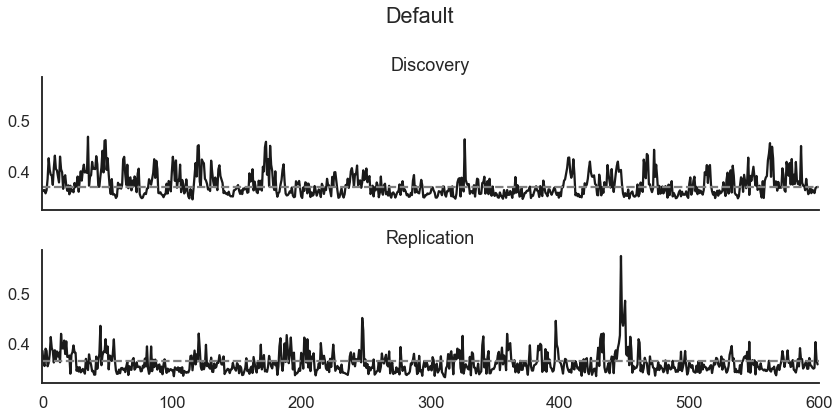

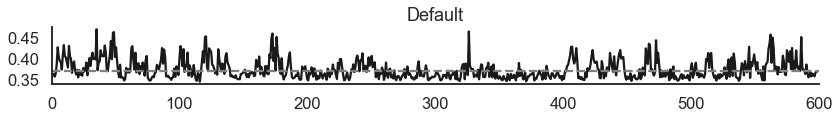

MFQ_P_Total DM younger lower
0.39852679577797606
0.40348304640292737


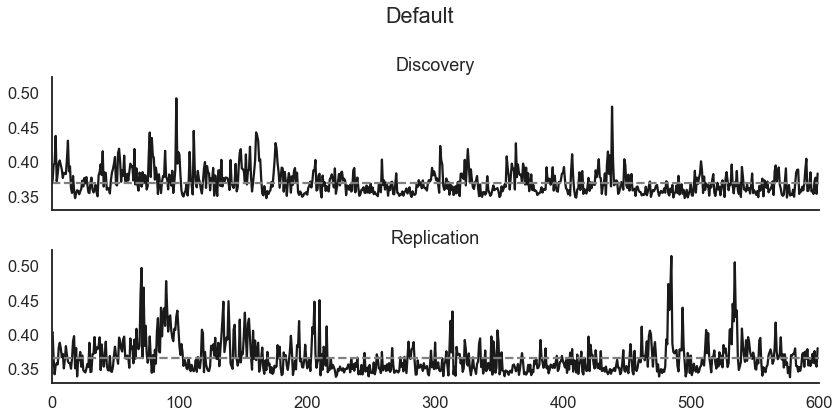

0.4236347470466945
0.4154480769819816


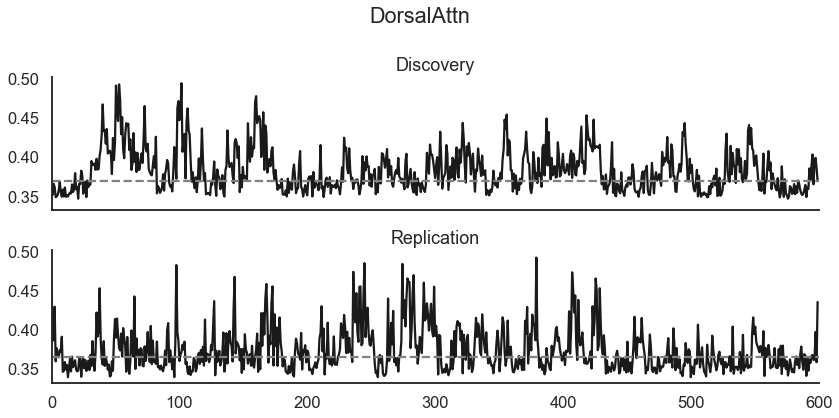

0.39422093944301556
0.41701547989468546


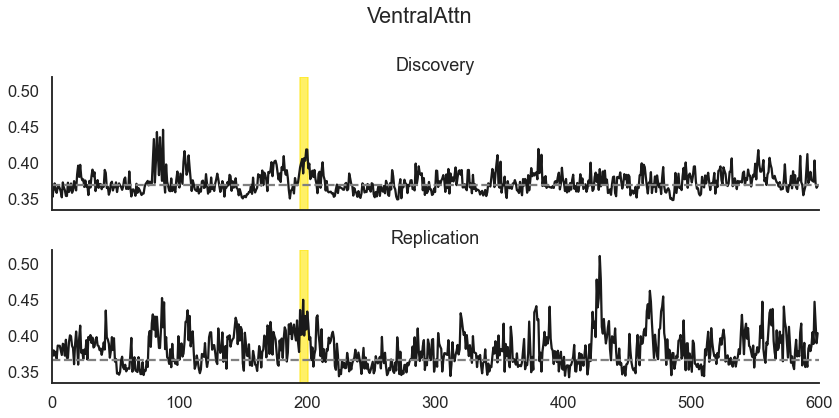

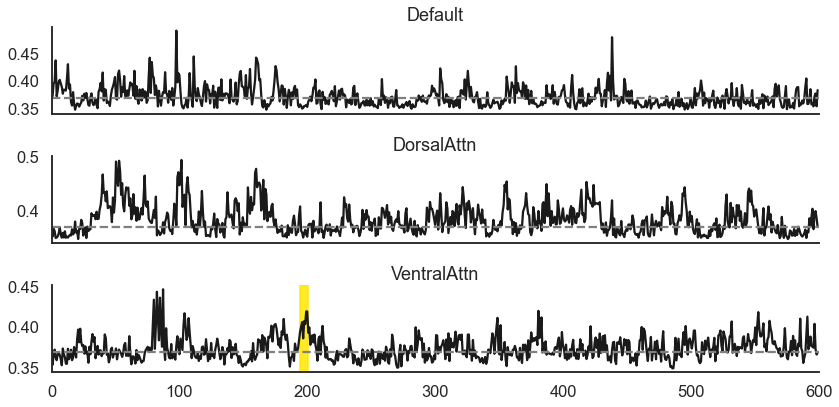

No differences between peak and nonpeak ratings
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  plot_obj.generate()
/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning: To output multiple subplots

MFQ_P_Total TP older upper
0.4709300389204562
0.49521020417472084


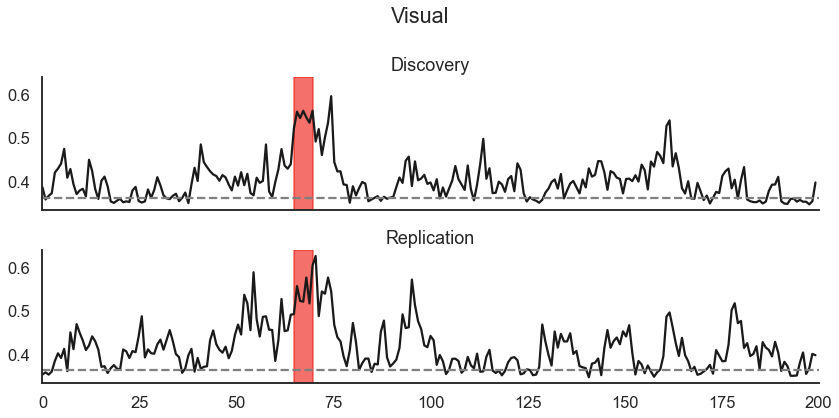

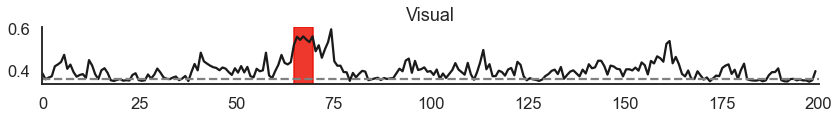

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



MFQ_P_Total TP older lower
0.399348230349603
0.40313428812256324


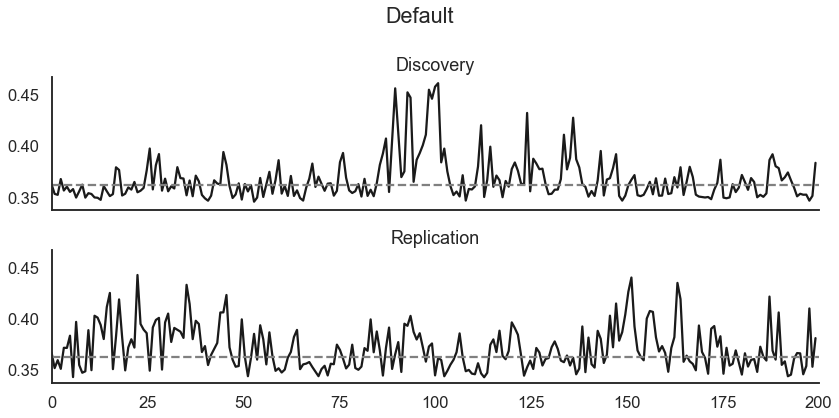

0.41299849980256764
0.4046040753315385


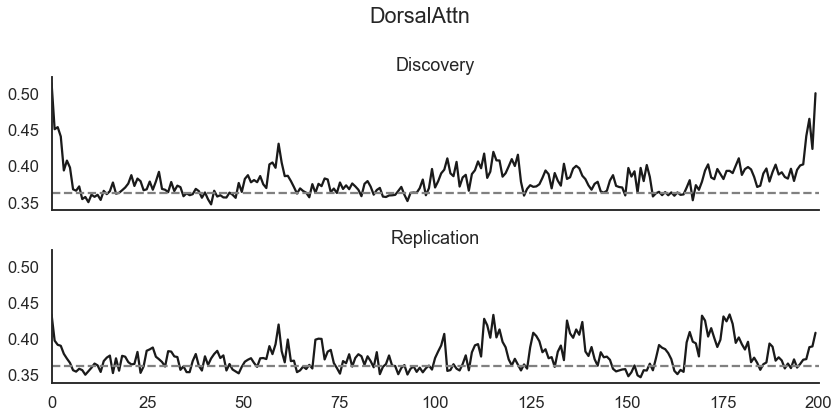

0.44867308492134433
0.44263532862809196


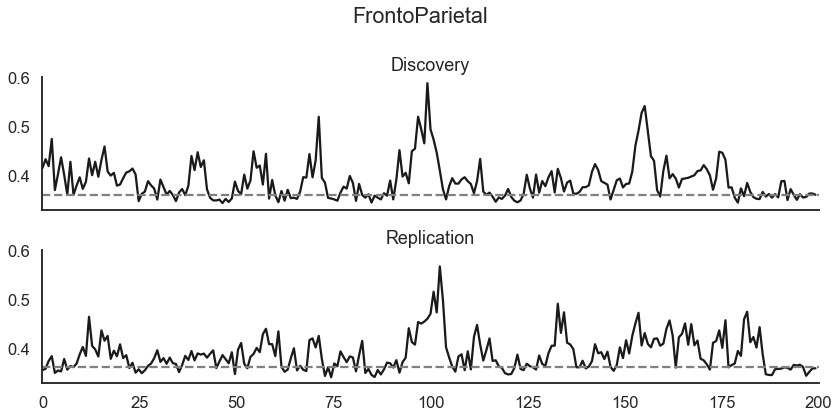

0.4113890948719442
0.41021918771030813


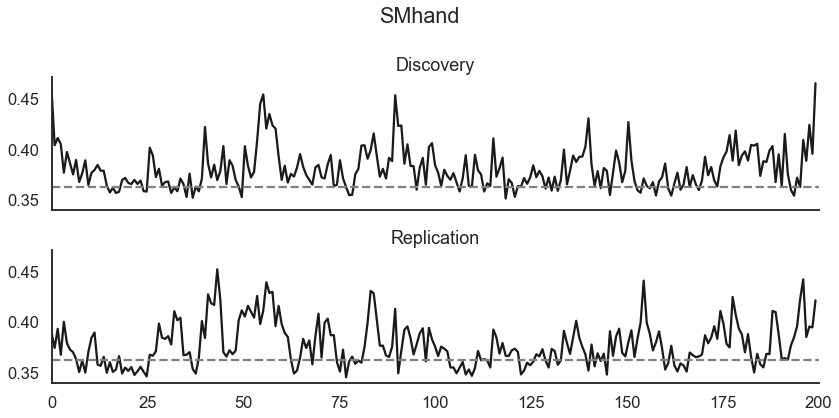

0.40975653937717504
0.4302201020395058


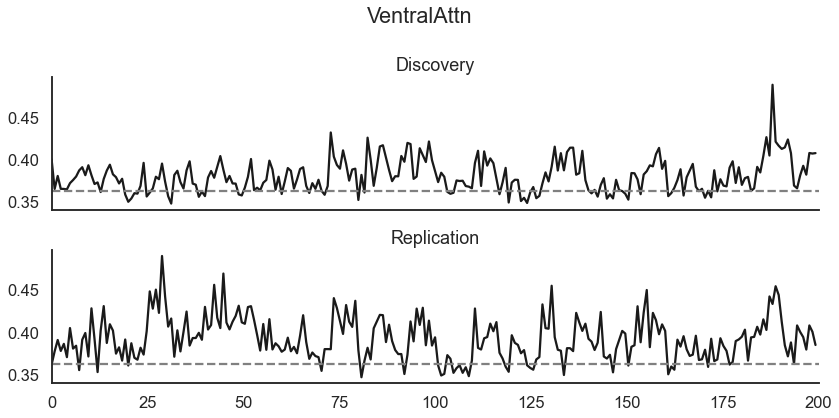

0.4693256286460948
0.5050573432868319


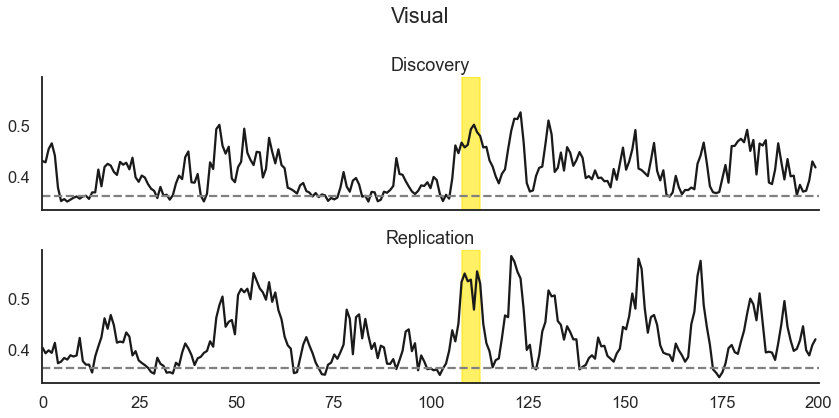

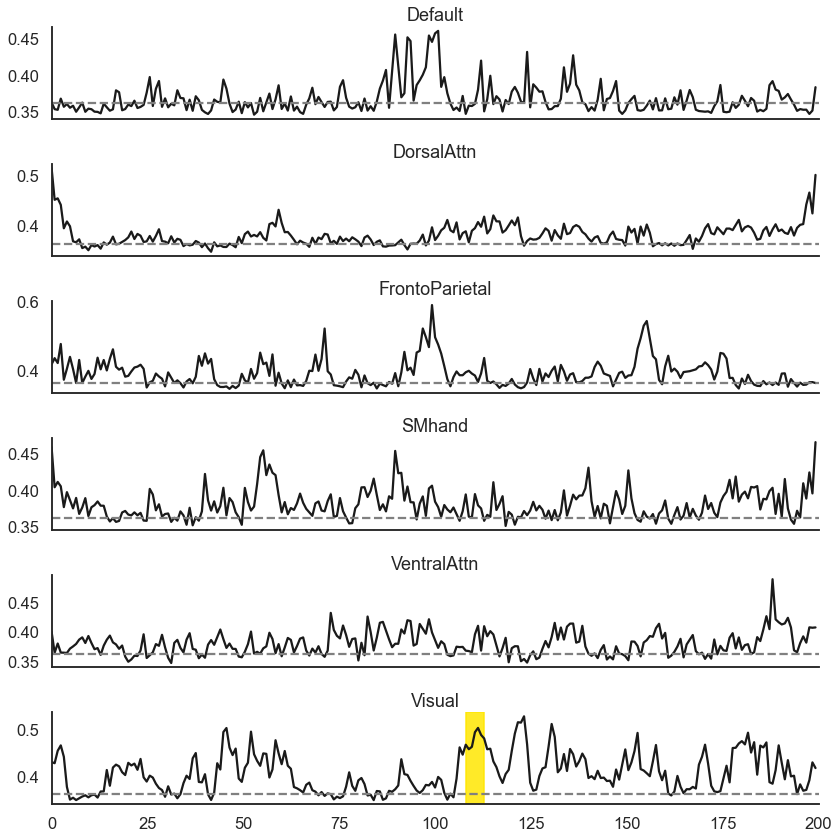

No differences between peak and nonpeak ratings
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Us

MFQ_P_Total TP younger upper
0.40713729538610455
0.43592751202881547


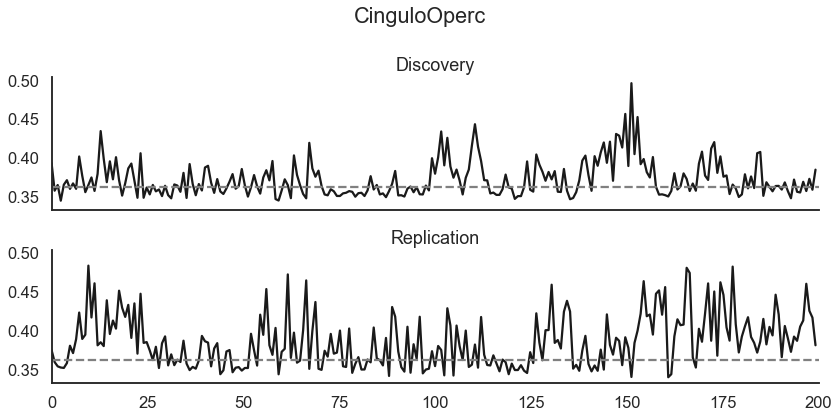

0.39192561576447554
0.428261541843078


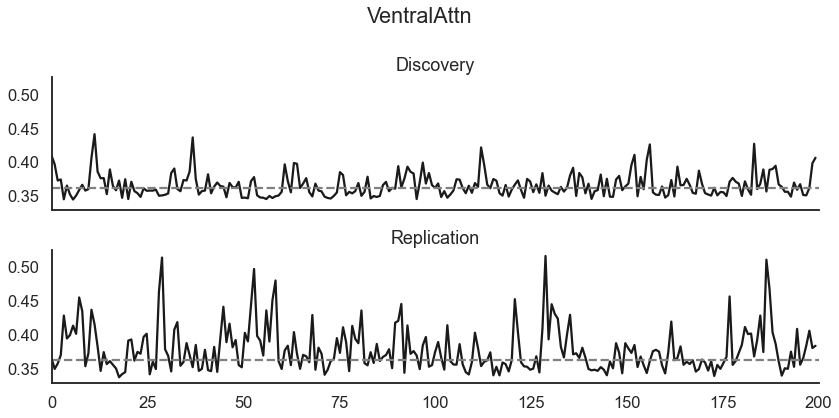

0.42905327849418734
0.44871955142632464


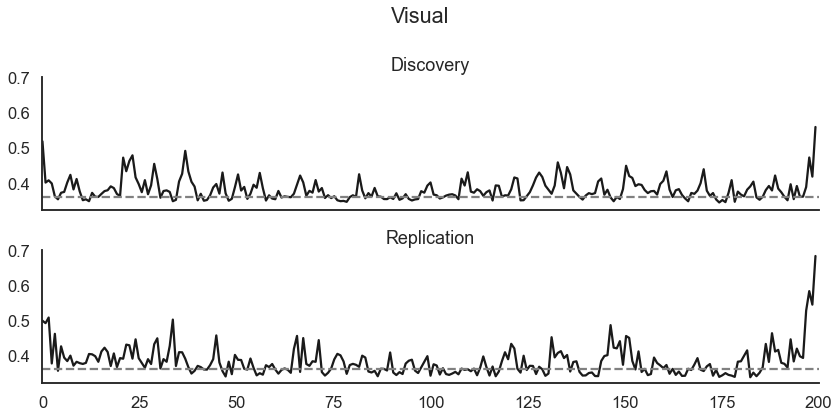

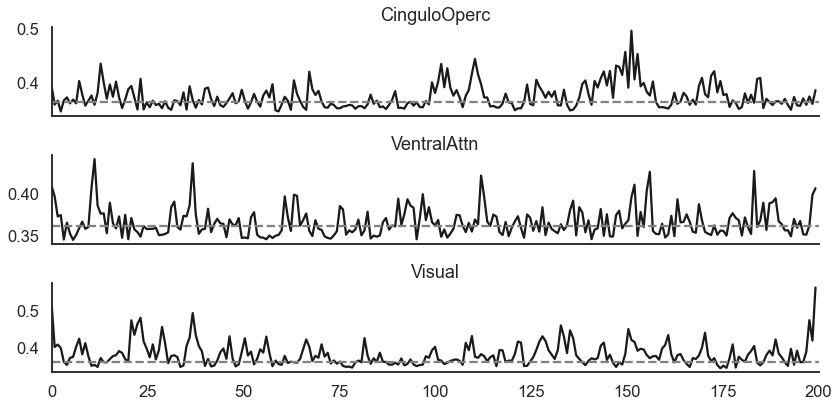

MFQ_P_Total TP younger lower
0.5294559530607655
0.5130727895548254


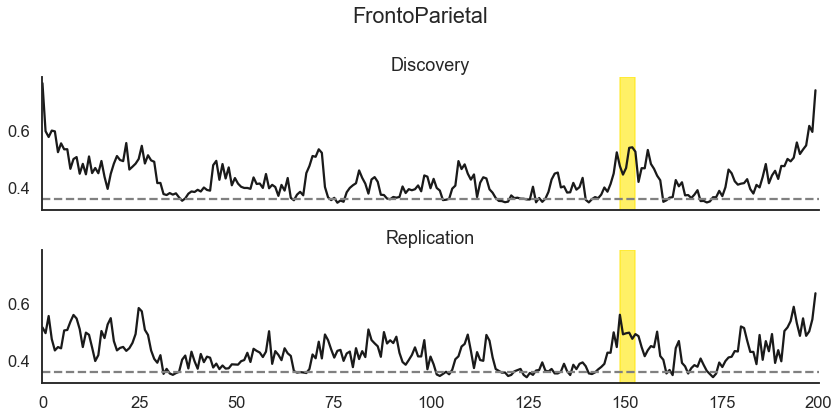

0.4255331939429524
0.45605537848130556


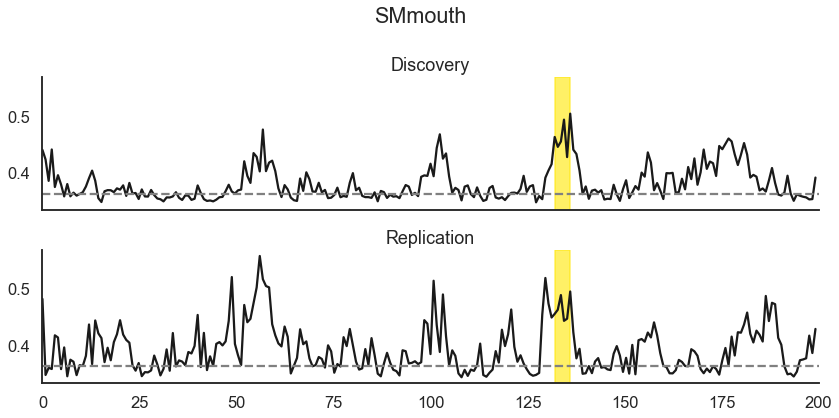

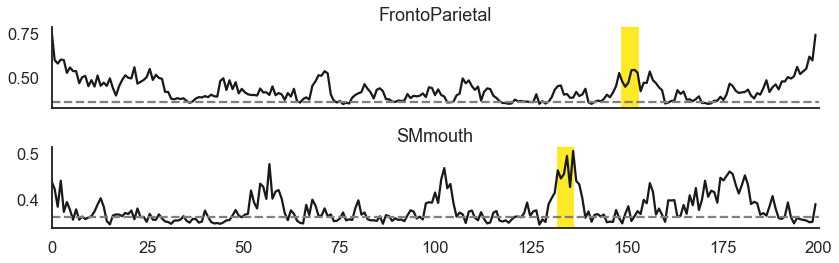

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



MFQ_SR_Total DM older upper
0.4100403804075205
0.40786805449145525


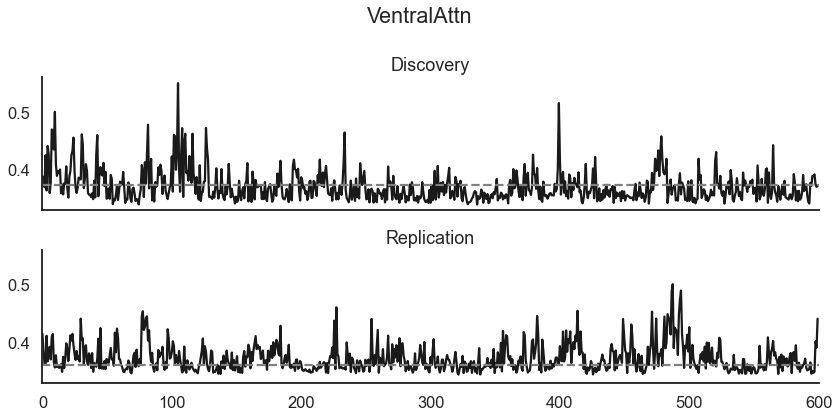

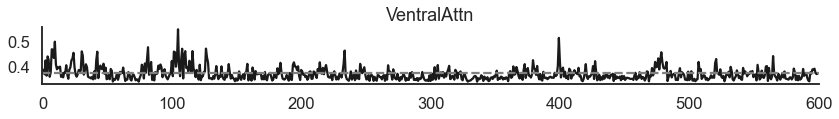

MFQ_SR_Total DM older lower
0.4220682675506231
0.42137019537720116


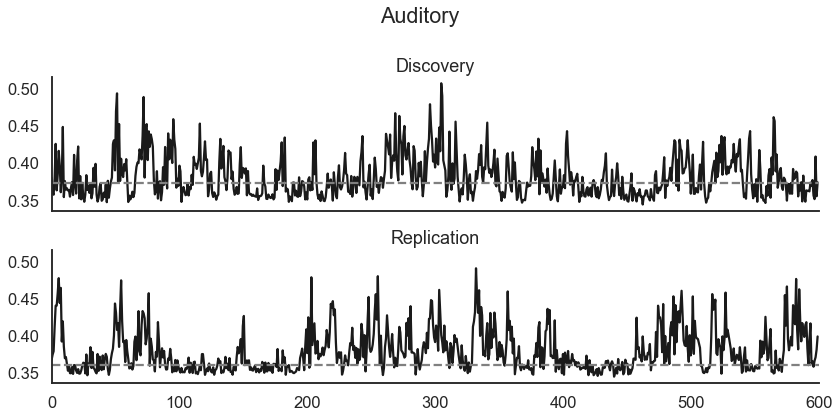

0.40838420149002586
0.4106825232891474


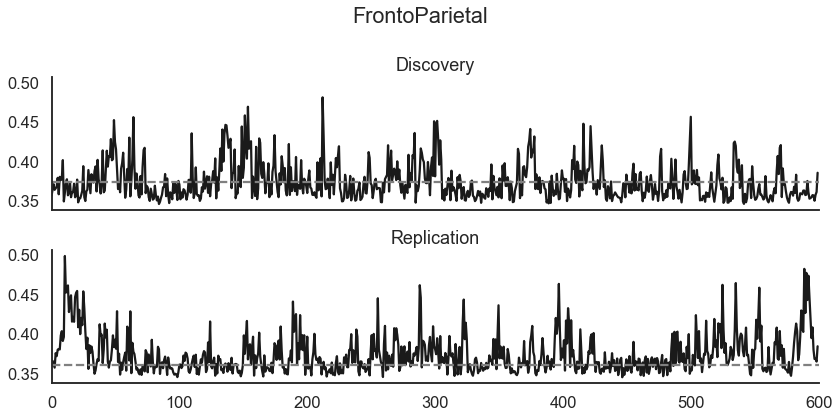

0.4728954265843115
0.47917692385284


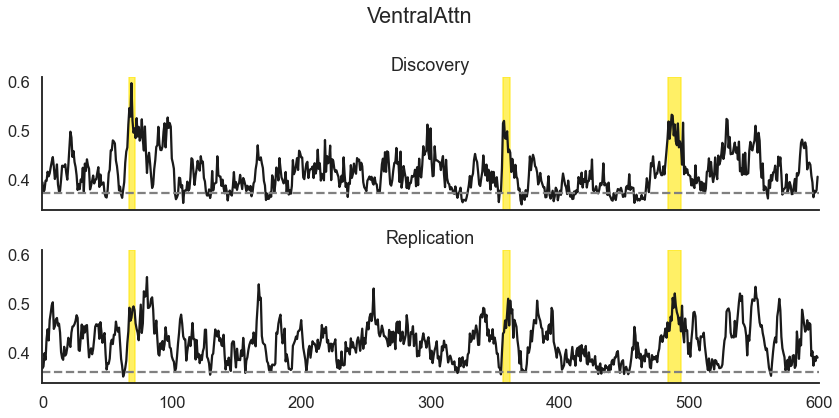

0.46907567452100885
0.4804218614994648


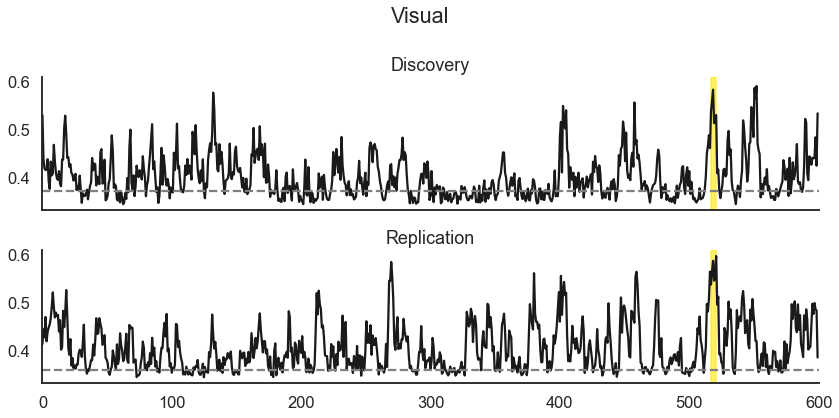

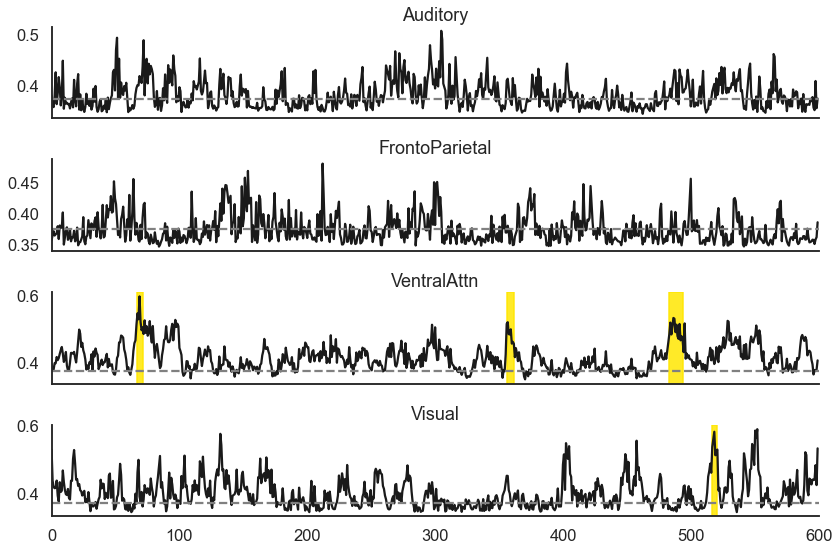

No differences between peak and nonpeak ratings
No differences between peak and nonpeak ratings
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



MFQ_SR_Total DM younger upper
0.5382945916763202
0.5495883335828412


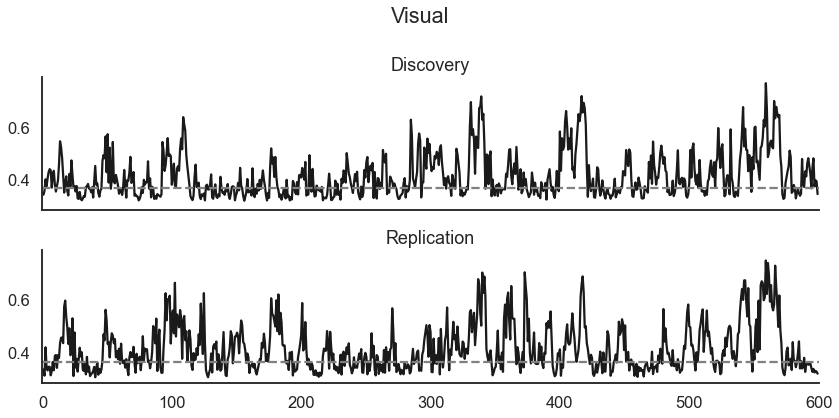

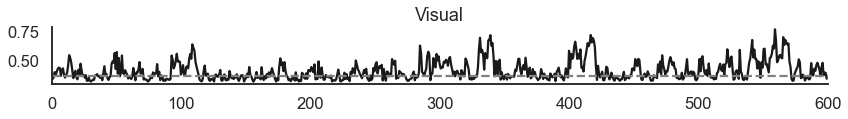

MFQ_SR_Total DM younger lower
0.5326487728889577
0.48021994728330697


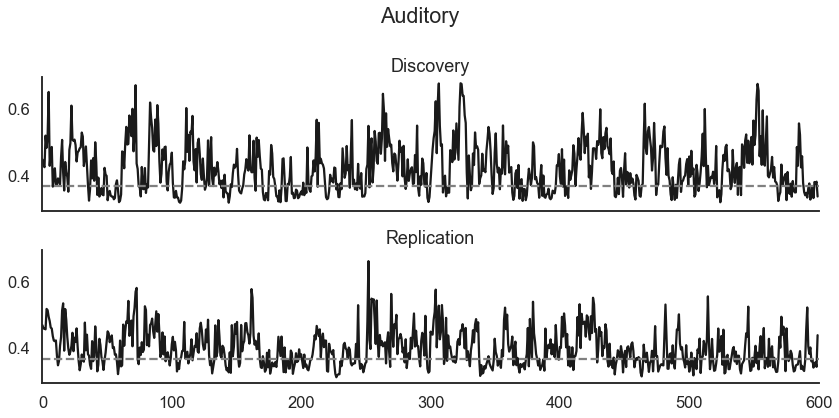

0.5064077761101385
0.4613615446859386


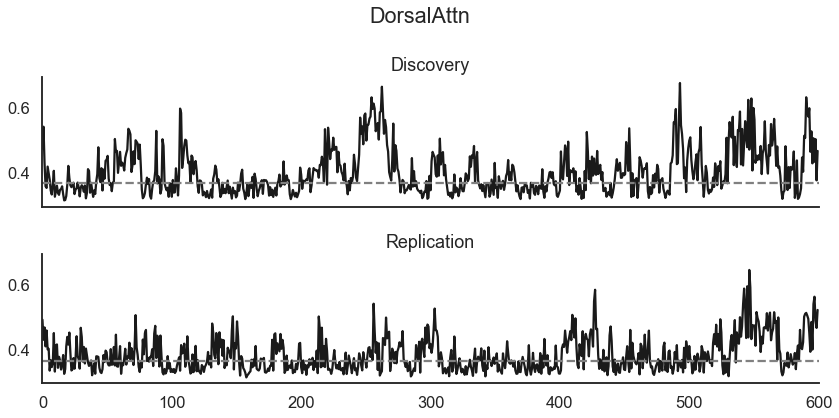

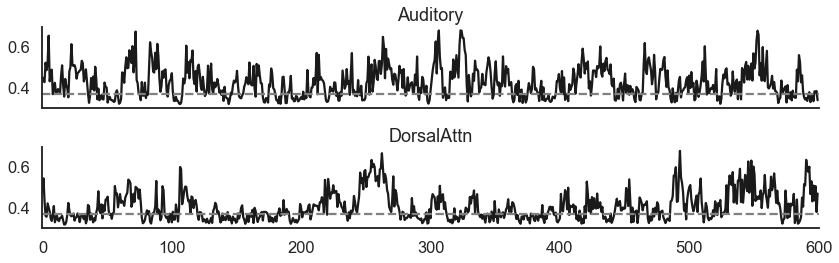

MFQ_SR_Total TP older upper
0.4269937096556422
0.42375131567728647


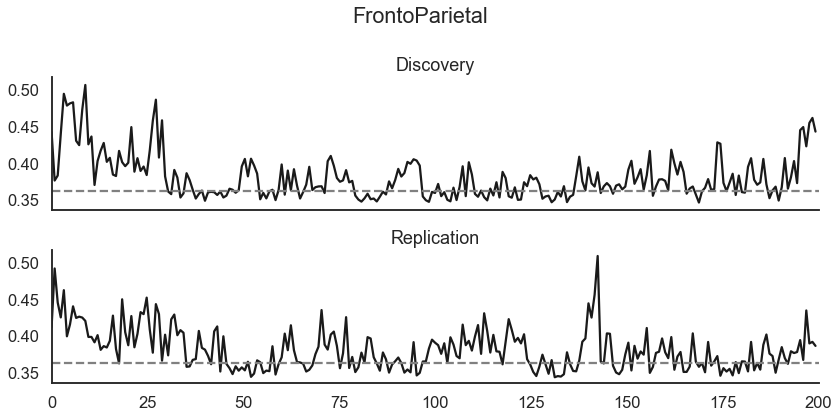

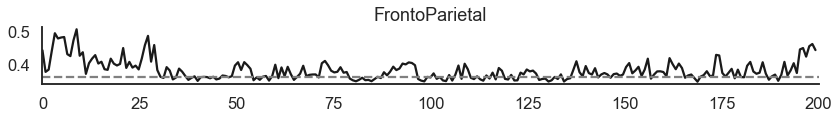

MFQ_SR_Total TP older lower
0.5101768801117647
0.5055501915476276


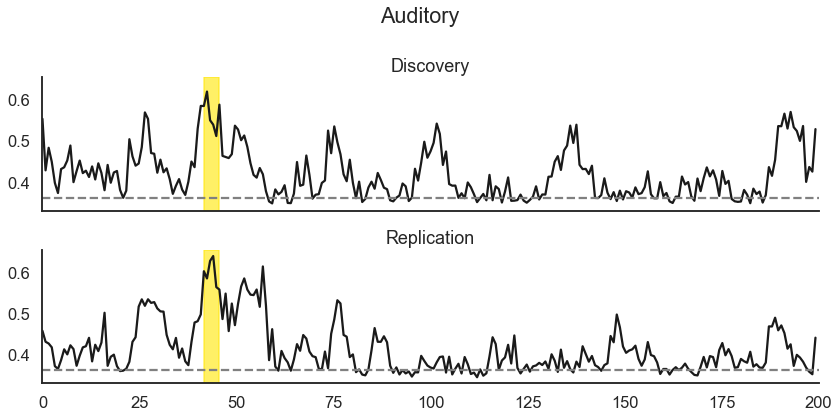

0.4786598753421625
0.4731503904022272


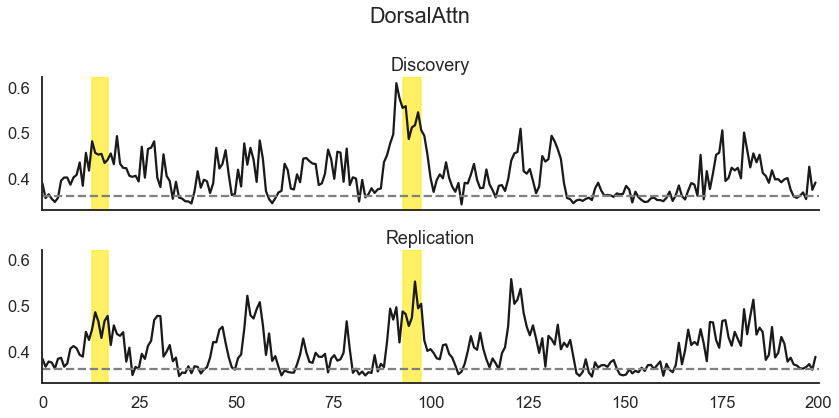

0.41827877655474854
0.4227800714291235


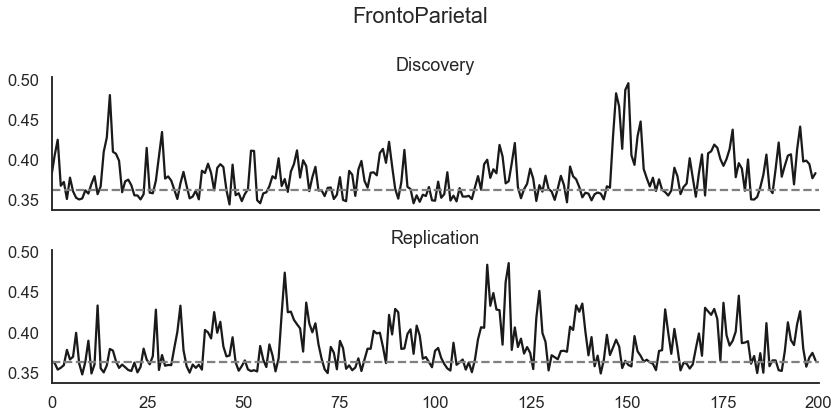

0.44738041699503384
0.4731869289990742


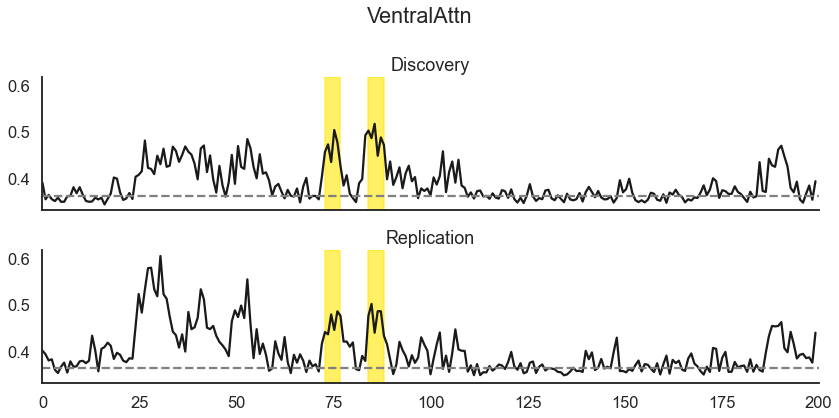

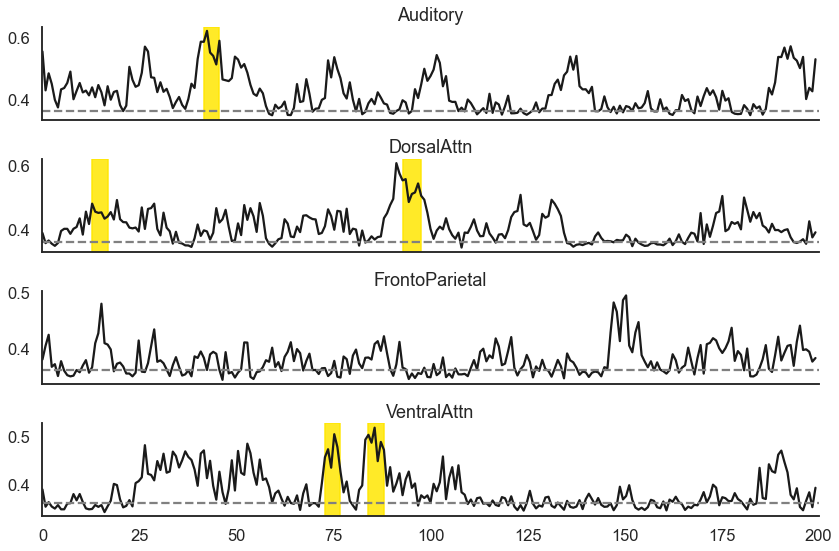

No differences between peak and nonpeak ratings
Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



MFQ_SR_Total TP younger upper
0.476282752755873
0.4644594419083185


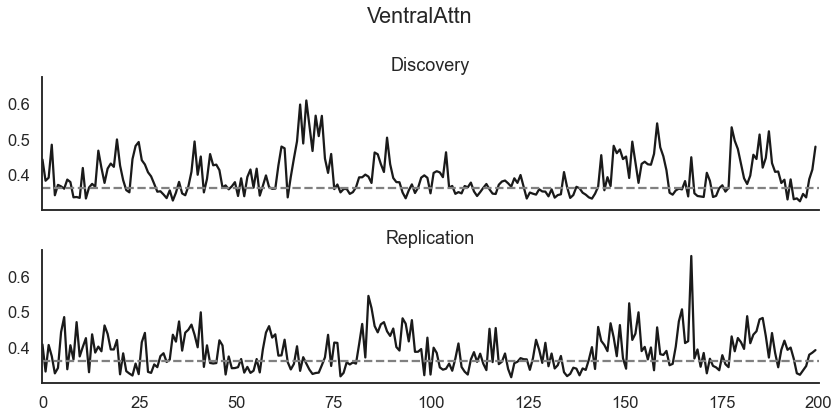

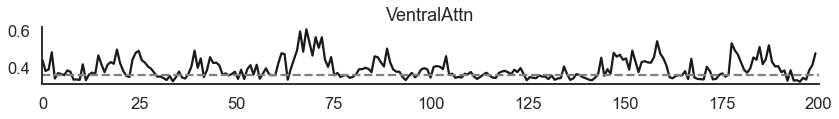

MFQ_SR_Total TP younger lower
0.5126238586820479
0.5471879705418923


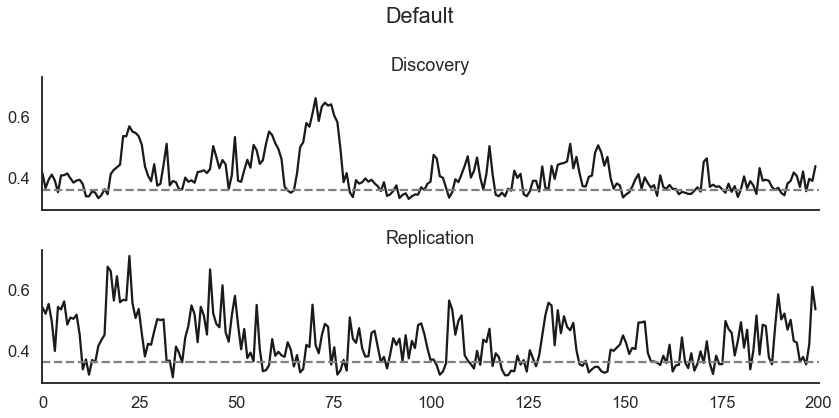

0.4506602928123515
0.4741683783788655


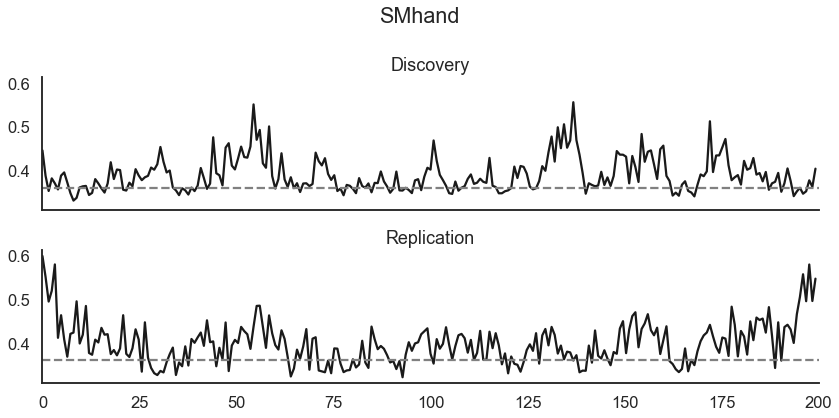

0.46171411619043123
0.5076429482565582


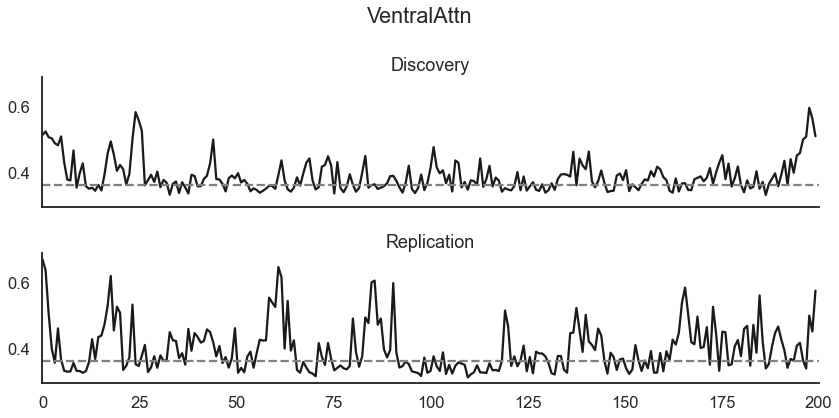

0.4584272674267007
0.48895224008665983


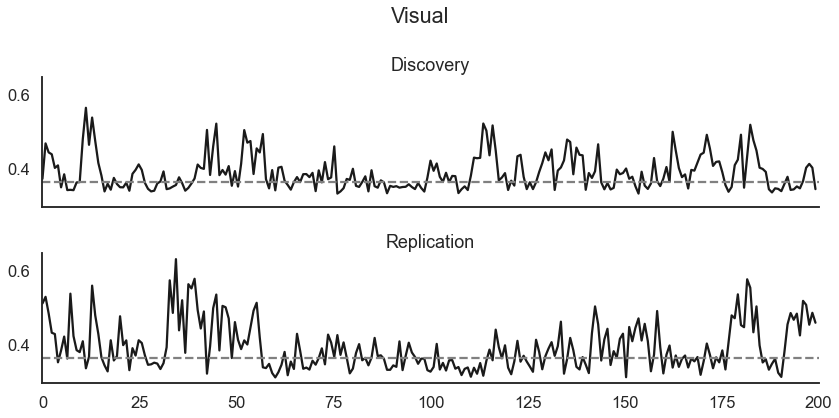

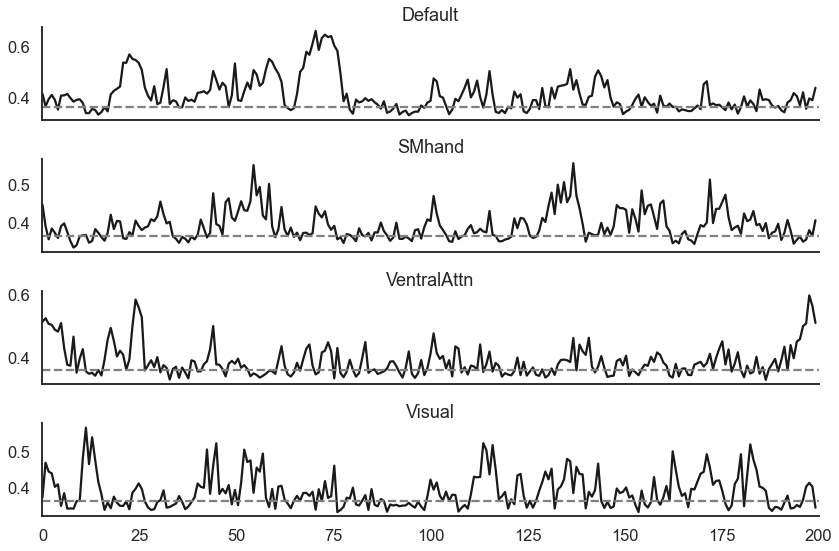

SCARED_P_SC DM older upper
SCARED_P_SC DM younger upper
0.4051125660281767
0.43013718945198487


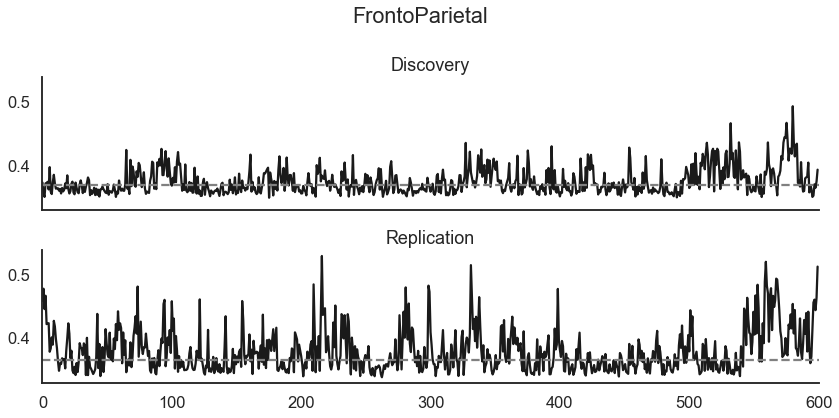

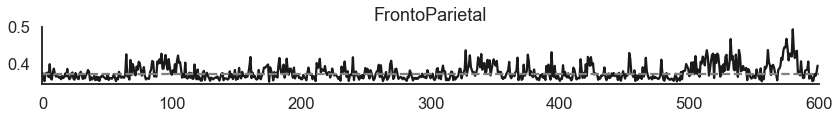

SCARED_P_SC DM younger lower
0.43812243702723985
0.442129208543072


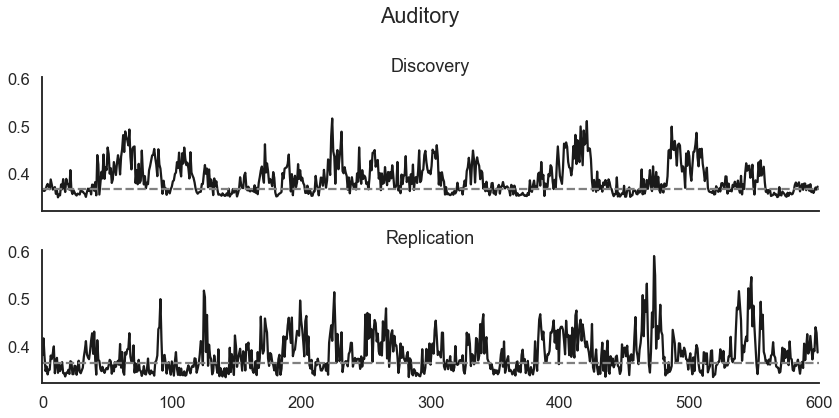

0.4816724144430161
0.4663474411160616


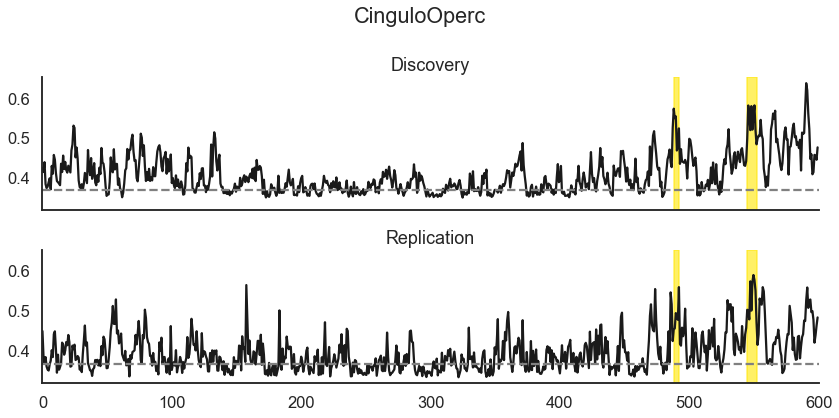

0.41451146754068785
0.42316656023086147


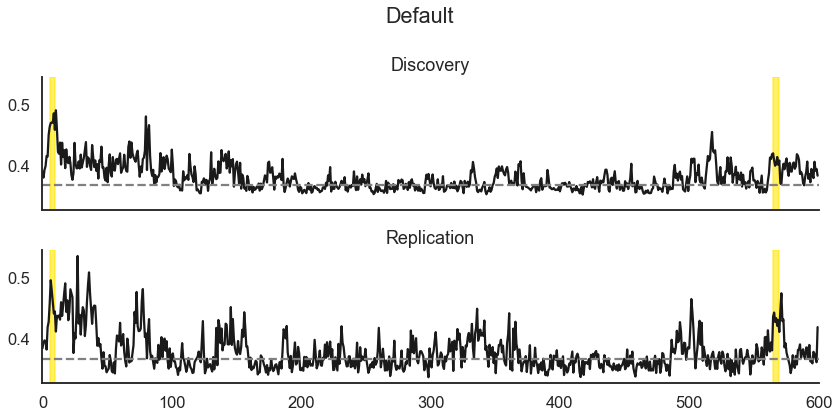

0.41004227442939906
0.41293257067999156


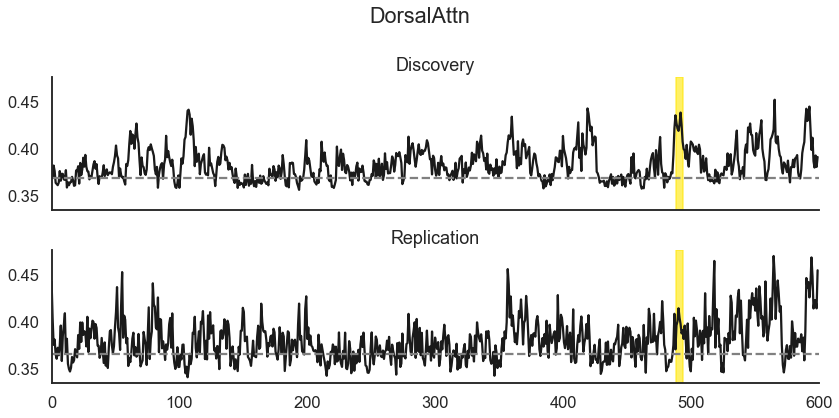

0.434056998796179
0.44442400872743626


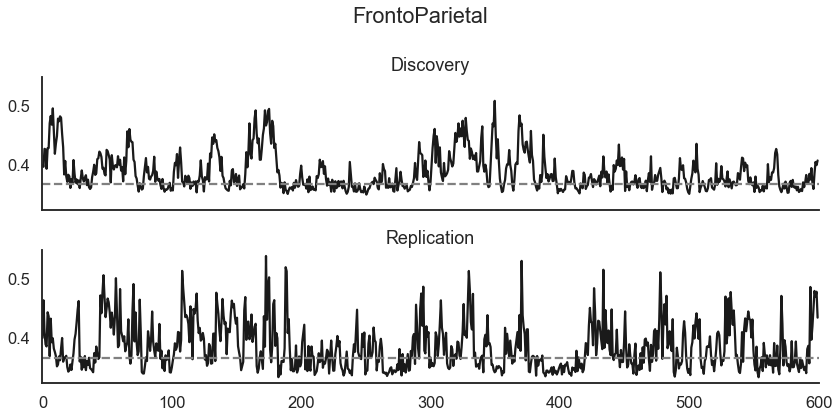

0.4159150819863364
0.4192650703918538


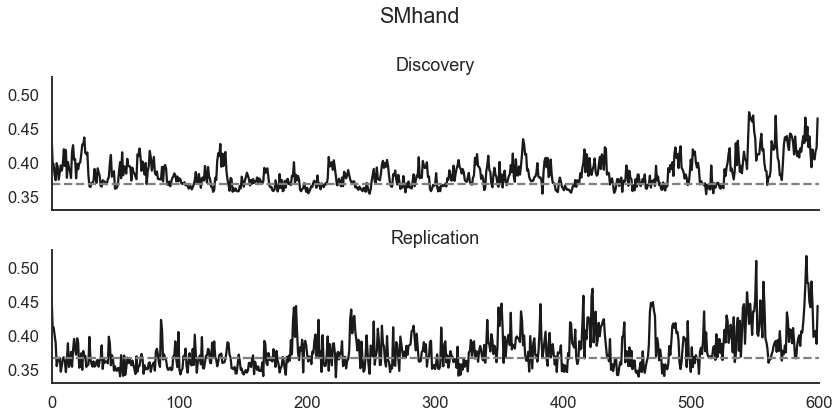

0.39011385469526405
0.4094939168355122


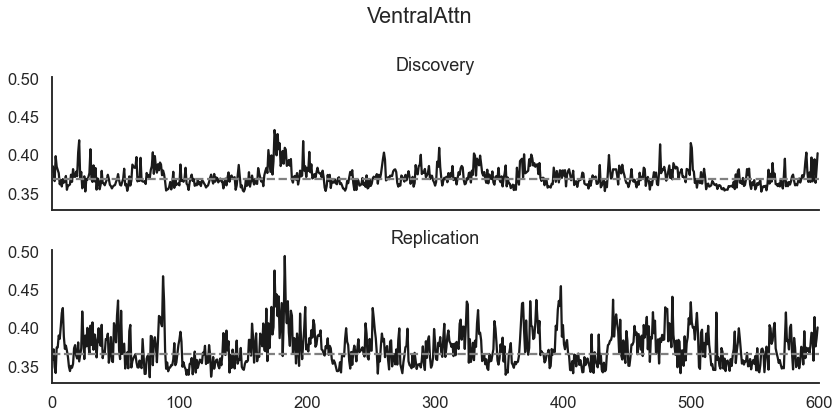

0.43900915454682715
0.43449631546425893


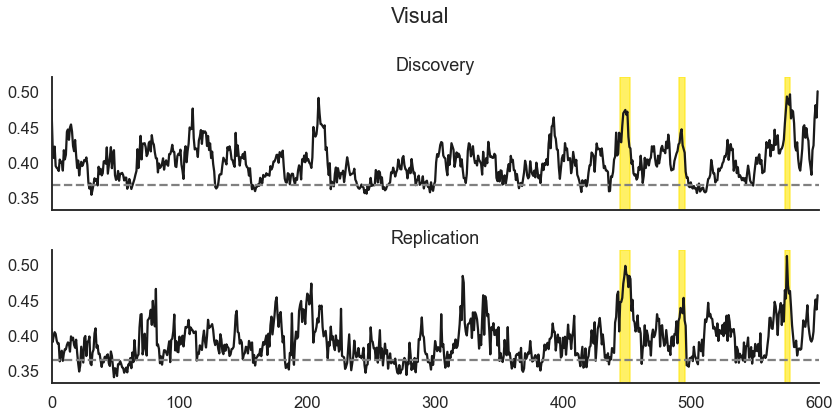

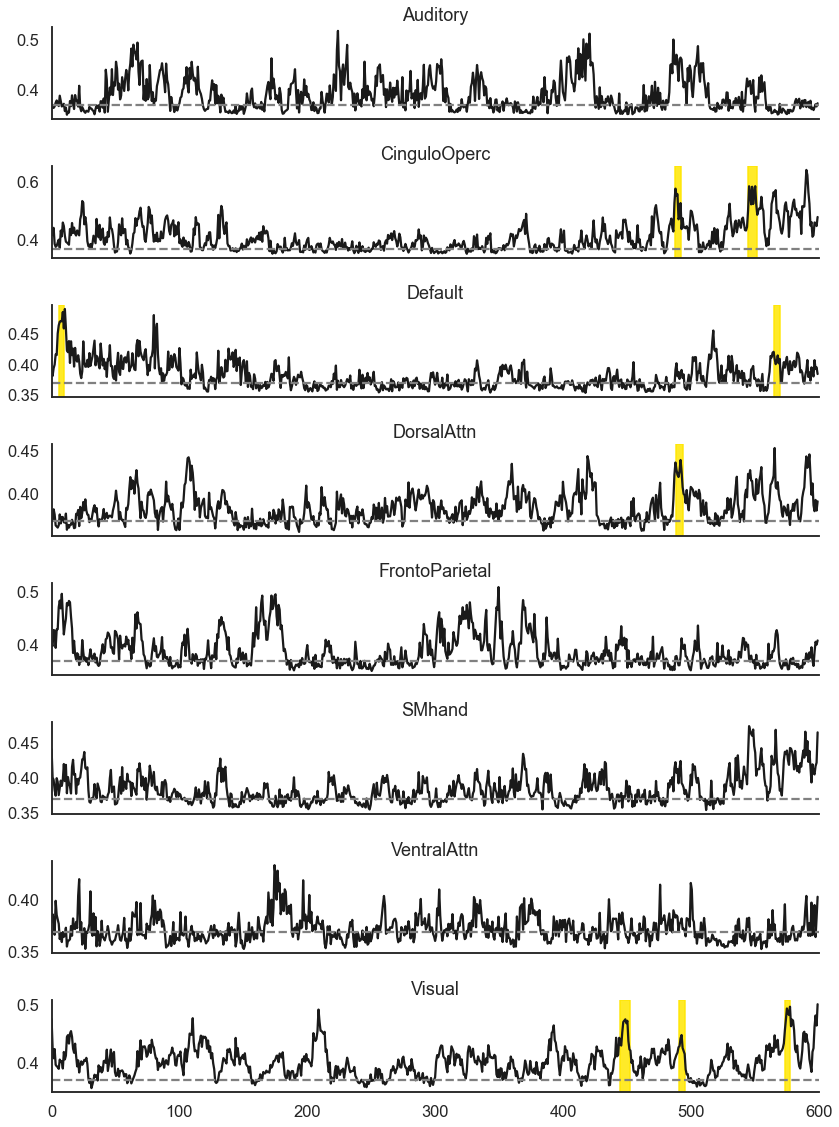

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



SCARED_P_SC TP older upper
SCARED_P_SC TP younger upper
SCARED_SR_SC DM older upper
SCARED_SR_SC DM younger upper
0.4329448245248669
0.45933579630977117


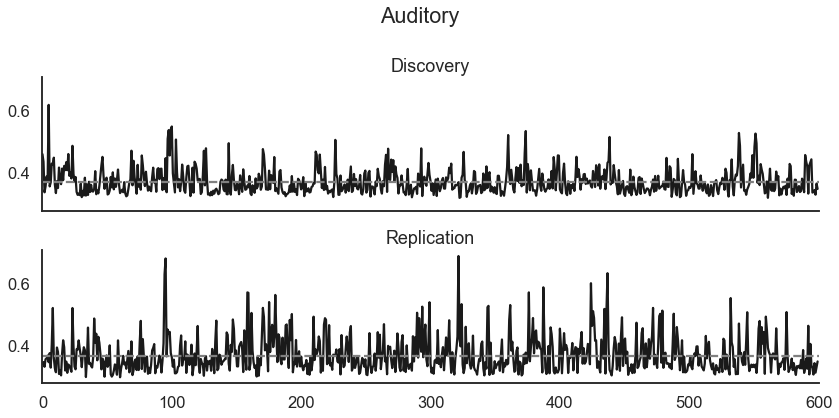

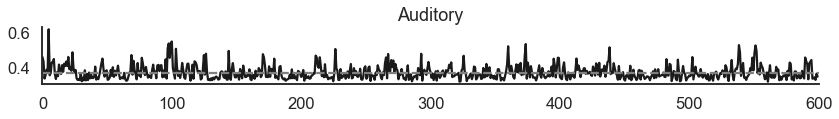

SCARED_SR_SC DM younger lower
0.49464386218928347
0.501494921118295


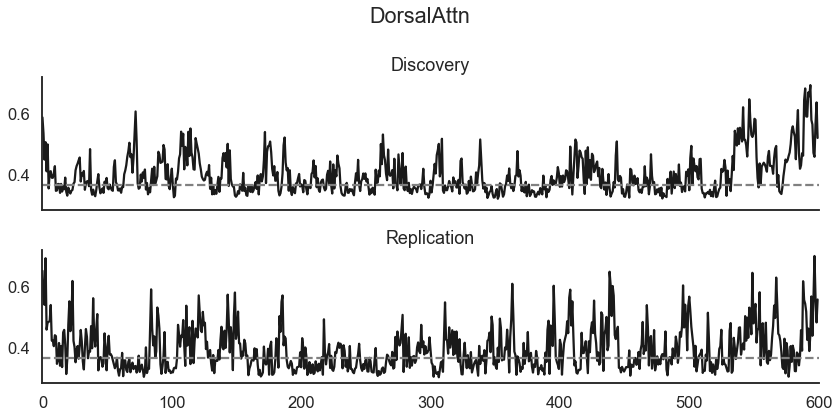

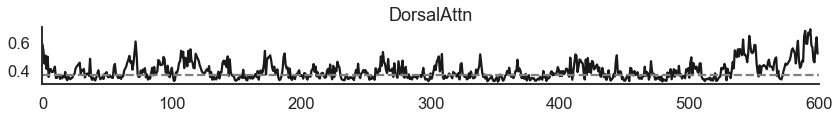

SCARED_SR_SC TP older upper
0.4254878857685975
0.4439778310811788


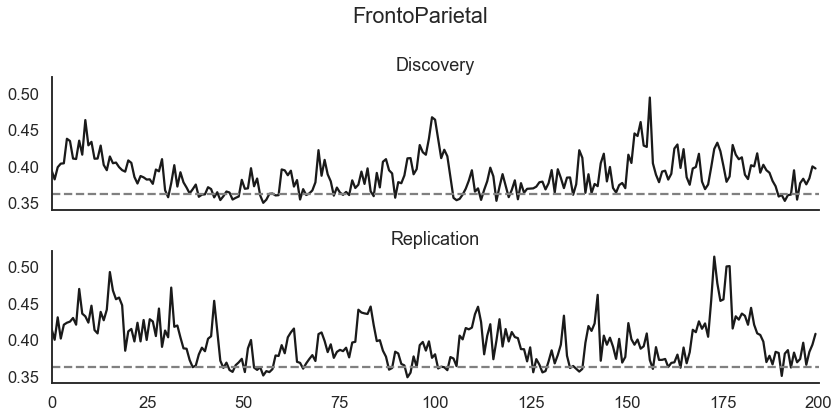

0.4052260747870784
0.40601135021156565


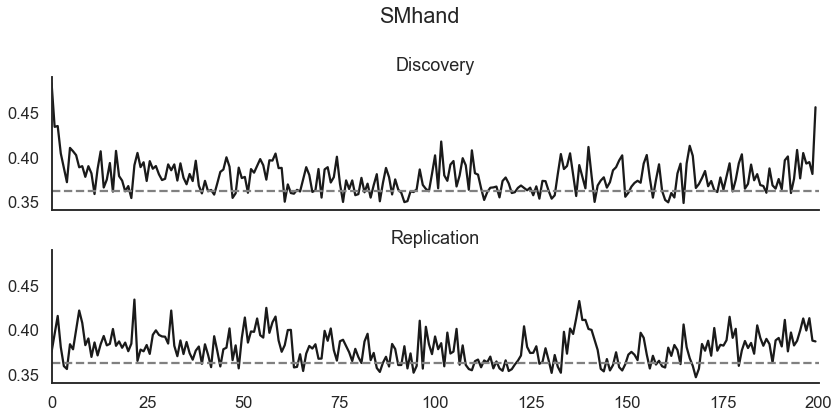

0.43886867004902247
0.42813291399420805


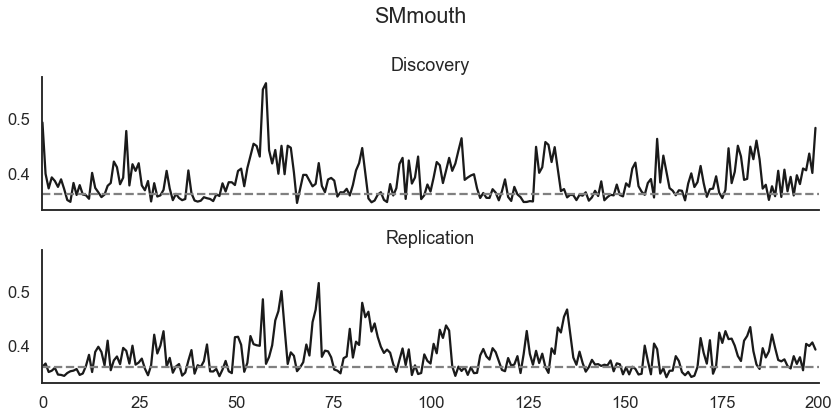

0.4055891673429501
0.42045711070978786


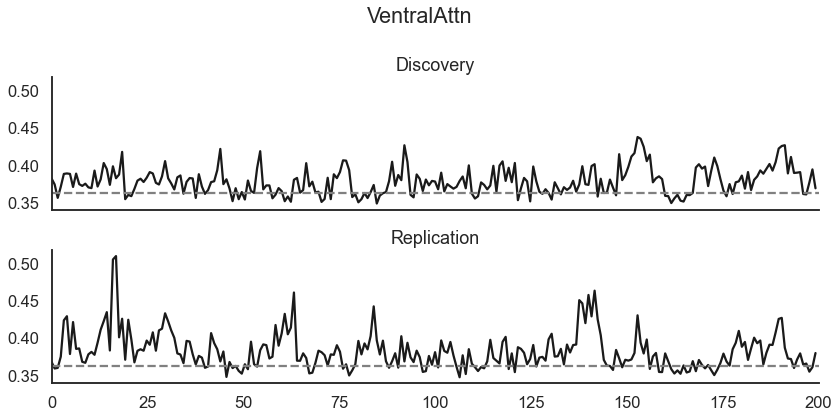

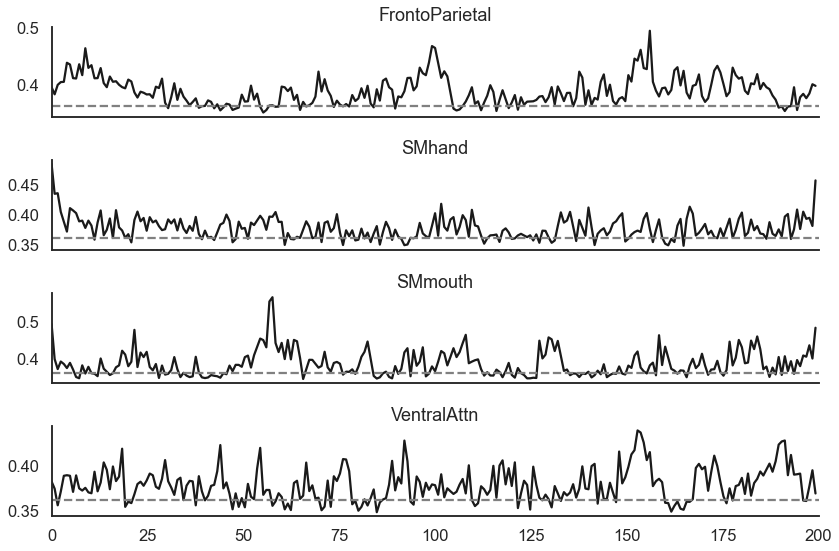

SCARED_SR_SC TP older lower
0.5256807571489002
0.5039335769313259


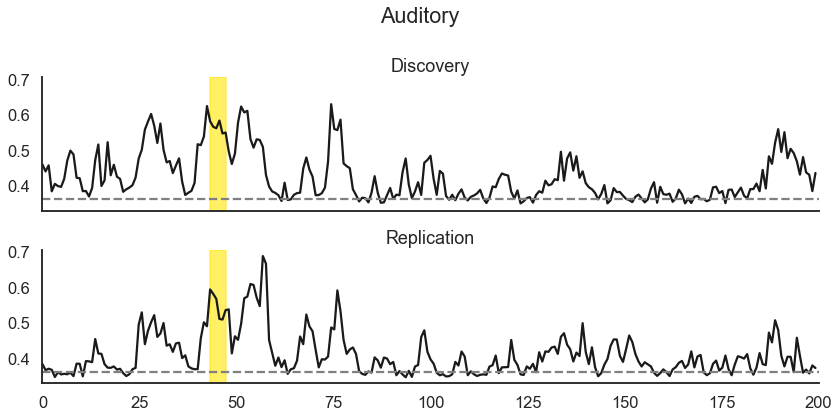

0.4214381468115346
0.42928619848561395


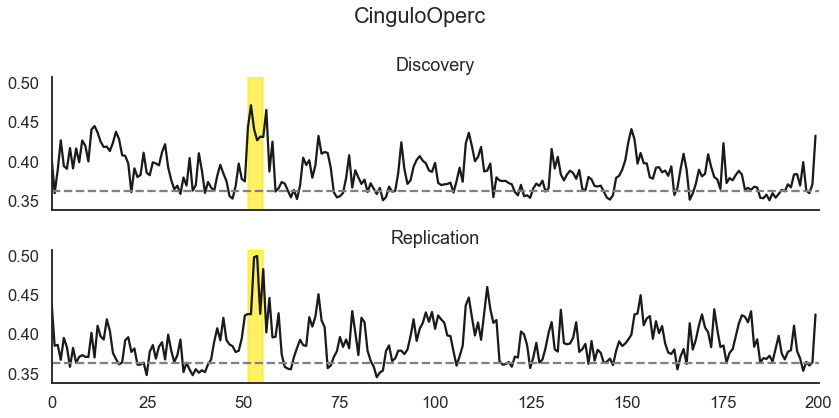

0.41840475002530275
0.43049794640639905


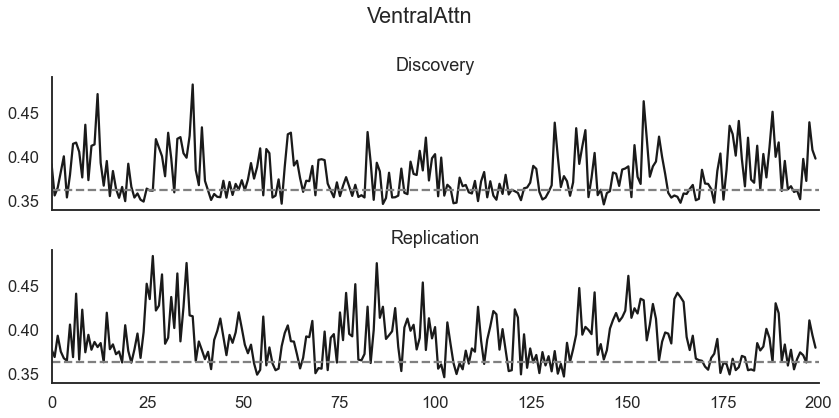

0.5227815260323242
0.5378090733425224


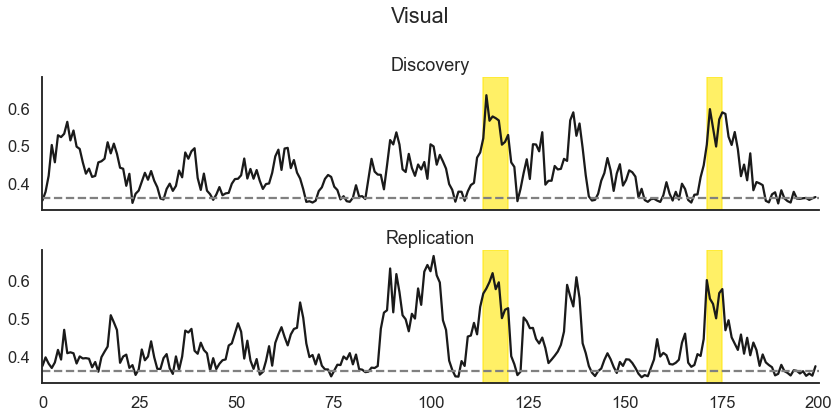

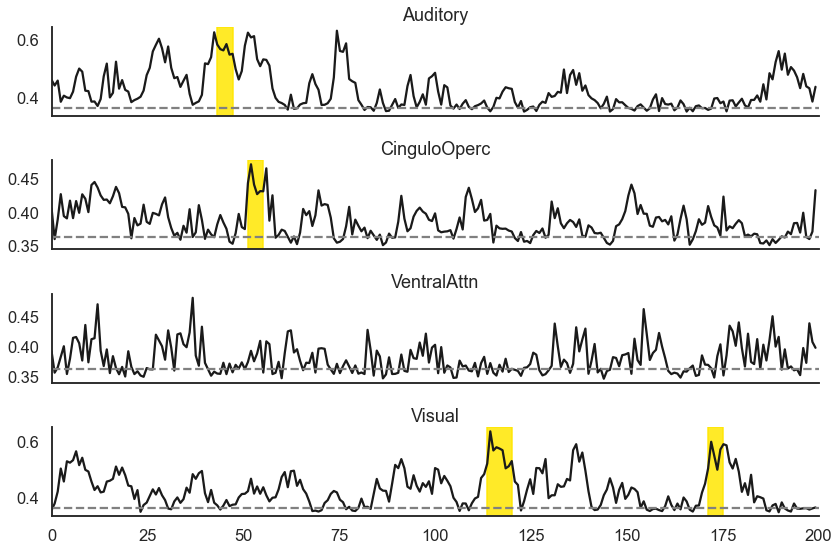

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



SCARED_SR_SC TP younger upper
0.5729442779726678
0.5632939351360685


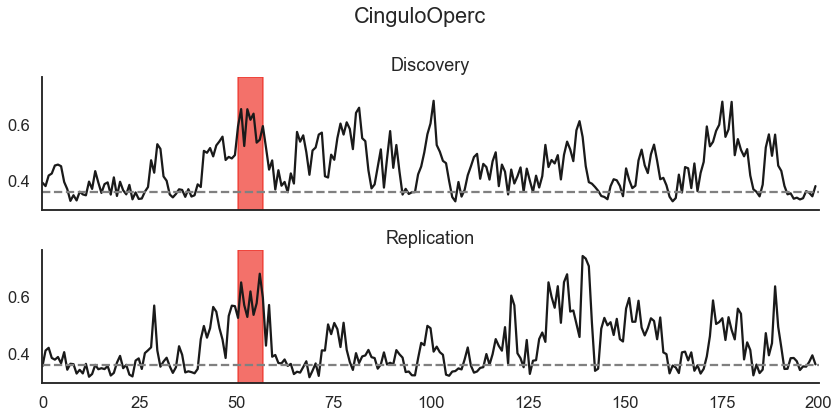

0.47712975097194366
0.5328177697698194


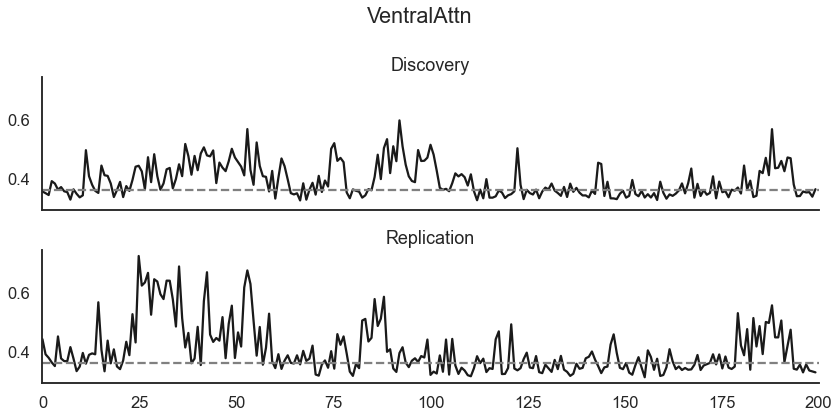

0.523481947900115
0.5769440509676662


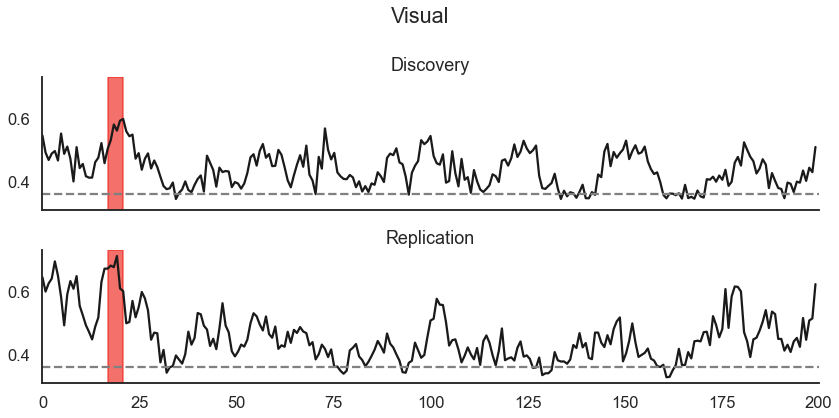

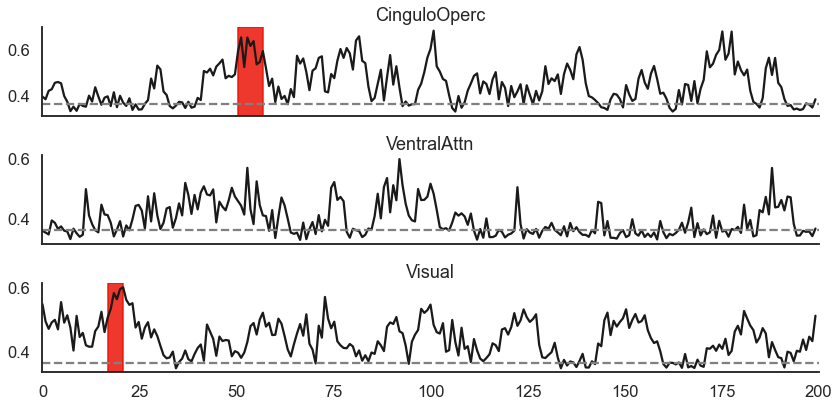

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFr

Moviepy - Running:
>>> "+ " ".join(cmd)
Moviepy - Command successful


/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared

/Users/catcamacho/Library/Python/3.8/lib/python/site-packages/pandas/plotting/_matplotlib/__init__.py:71: UserWarning:

To output multiple subplots, the figure containing the passed axes is being cleared



SCARED_SR_SC TP younger lower
0.41237285935107887
0.4506679038642671


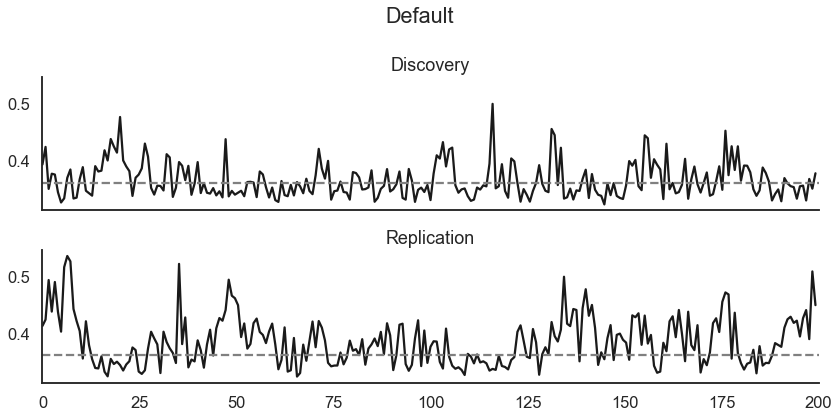

0.48248690663843
0.47637742105534275


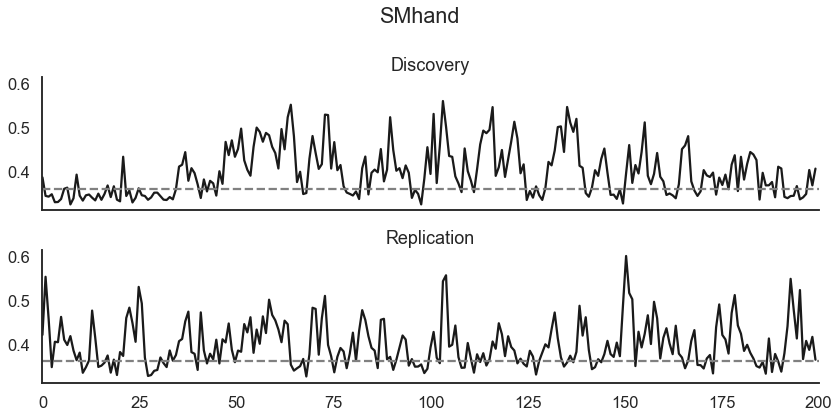

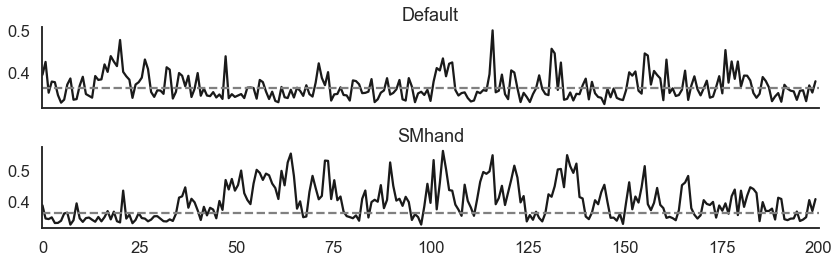

In [81]:
## determine which scenes evoke greater synchrony across children with higher symptoms
interpretable_nets = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                      'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']
alpha = np.sqrt(0.05/len(parcel_labels))

for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for movie in ['DM','TP']:
        for group in ['older','younger']:
            if movie=='DM':
                video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
                movie_dur=600
            else:
                video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
                movie_dur = 200
            for sxs in ['upper','lower']:
                print(clin, movie, group, sxs)
                # identify subsample for each clinical measure
                discinfo = pd.read_csv(os.path.join(out_dir, 'similarity_byage', 'dynamic_rubic_movie{0}_{1}'.format(movie, group),'subject_info.csv'), index_col=0)
                discsubs = np.isfinite(discinfo[clin]).to_numpy()
                discmetric = discinfo.loc[np.isfinite(discinfo[clin]), clin].to_numpy()
                repinfo = pd.read_csv(os.path.join(out_dir, 'similarity_byage', 'dynamic_cbic_movie{0}_{1}'.format(movie, group),'subject_info.csv'), index_col=0)
                repsubs = np.isfinite(repinfo[clin]).to_numpy()
                repmetric = repinfo.loc[np.isfinite(repinfo[clin]), clin].to_numpy()

                sig_parcs_file = os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movie{0}_{1}_{2}'.format(movie, clin, group),
                                              'top_model_fits_replicable.dlabel.nii')
                sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
                model_labels = []
                mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
                model_labels = model_labels[1:]
                model_labels = [a.split('_')[0] for a in model_labels]
                model_labels = np.array(model_labels)

                if sxs=='upper':
                    color = '#eb1207'
                    cifticolor = (235/255, 18/255, 7/255, 1)
                    dcutoff = np.percentile(discmetric, 80)
                    rcutoff = np.percentile(repmetric, 80)
                    discmask = ((discinfo[clin]>=dcutoff) & discsubs).astype(int)
                    repmask = ((repinfo[clin]>=rcutoff) & repsubs).astype(int)

                    # identify sig parcels from sim analysis
                    sigparcsmask = np.zeros(network_labels.shape)
                    sigparcsmask[model_labels=='AnnaKmin'] = 1
                    signets = list(np.unique(network_labels[sigparcsmask==1]))
                    nois = [a for a in signets if a in interpretable_nets]
                    if len(signets)==0:
                        sigparcsmask[model_labels=='AnnaKmean'] = 1
                        signets = list(np.unique(network_labels[sigparcsmask==1]))
                        nois = [a for a in signets if a in interpretable_nets]

                else:
                    color = '#ffe600'
                    cifticolor = (255/255, 230/255, 0/255, 1)
                    dcutoff = np.percentile(discmetric, 20)
                    rcutoff = np.percentile(repmetric, 20)
                    discmask = ((discinfo[clin]<=dcutoff) & discsubs).astype(int)
                    repmask = ((repinfo[clin]<=rcutoff) & repsubs).astype(int)

                    # identify sig parcels from sim analysis
                    sigparcsmask = np.zeros(network_labels.shape)
                    sigparcsmask[model_labels=='AnnaKmaxminmax'] = 1
                    signets = list(np.unique(network_labels[sigparcsmask==1]))
                    nois = [a for a in signets if a in interpretable_nets]

                if len(nois)==0:
                    break
                discovery_data = {'color':color, sxs: {'mask': discmask, 'cutoff': dcutoff, 'nsubs':np.sum(discmask),'subinfo': discinfo}}
                replication_data = {'color':color, sxs: {'mask': repmask, 'cutoff': rcutoff, 'nsubs':np.sum(repmask),'subinfo':repinfo}}
                both_data = {'color':color,'network_info':{}}
                time = np.arange(0,movie_dur, 0.8)

                ratings_file = os.path.join(project_dir, 'HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie))
                out_folder = os.path.join(out_dir, 'similarity_byage','dynamic_movie{0}_{1}_{2}'.format(movie, clin, group),'signetworks_bothmovies')
                os.makedirs(out_folder, exist_ok=True)

                # load discovery data
                disc_phase_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_rubic_movie{0}_{1}'.format(movie, group), 
                                               'phase_data_rubic_movie{0}.npy'.format(movie))
                disc_phase = np.load(disc_phase_file)[:,:, discmask==1]
                out_prefix = os.path.join(out_folder, 'disc_{0}20_'.format(sxs))
                if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                    disc_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
                else:
                    disc_mean_sim, _ = compute_isps(disc_phase, out_prefix)
                if disc_mean_sim.shape[1]!=len(parcel_labels):
                    disc_mean_sim = disc_mean_sim.T

                # load replication data
                rep_phase_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_cbic_movie{0}_{1}'.format(movie, group), 
                                              'phase_data_cbic_movie{0}.npy'.format(movie))
                rep_phase = np.load(rep_phase_file)[:,:, repmask==1]
                out_prefix = os.path.join(out_folder, 'rep_{0}20_'.format(sxs))
                if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                    rep_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
                else:
                    rep_mean_sim, _ = compute_isps(rep_phase, out_prefix)
                if rep_mean_sim.shape[1]!=len(parcel_labels):
                    rep_mean_sim = rep_mean_sim.T

                # identify similarity threshold at FDR-corrected p<0.05
                null_dist_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_rubic_movie{0}_{1}'.format(movie, group), 
                                              'perm_null_distribution.npy')
                null_dist = np.load(null_dist_file).flatten()
                n = int(round((len(null_dist)+1)*alpha,0))
                disc_null_thresh = null_dist[len(null_dist)-n]
                null_dist_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_cbic_movie{0}_{1}'.format(movie, group), 
                                              'perm_null_distribution.npy')
                null_dist = np.load(null_dist_file).flatten()
                n = int(round((len(null_dist)+1)*alpha,0))
                rep_null_thresh = null_dist[len(null_dist)-n]

                # average across network/region
                disc_sim_net = np.zeros((disc_mean_sim.shape[0], len(nois)))
                rep_sim_net = np.zeros((rep_mean_sim.shape[0], len(nois)))

                for i, n in enumerate(nois):
                    disc_sim_net[:,i] = np.mean(disc_mean_sim[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    rep_sim_net[:,i] = np.mean(rep_mean_sim[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    both_data['network_info'][n] = parcel_labels[(network_labels==n) & (sigparcsmask==1)]

                    # make label file for sig parcels
                    ax1 = nib.load(atlas_file).header.get_axis(1)
                    data = nib.load(atlas_file).get_fdata()
                    ax0 = nib.load(atlas_file).header.get_axis(0)
                    newmap=dict()
                    newmap[0] = ax0[0][1][0]
                    parcels_keep = both_data['network_info'][n]
                    for a in range(1,len(parcel_labels) +1):
                        if parcel_labels[a-1] in parcels_keep:
                            newmap[a] = (parcel_labels[a-1], cifticolor)
                        else:
                            newmap[a] = (parcel_labels[a-1], (1,1,1,0))
                    ax0.label[0] = newmap
                    img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                    nib.save(img, os.path.join(out_folder, 'sig_parcels_net-{0}_{1}20.dlabel.nii'.format(n, sxs)))

                #### plot synchrony ####
                for i, net in enumerate(nois):
                    fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                    # detect peaks in activation based on 2SDs above the mean
                    discmean = np.mean(disc_sim_net[:,i])
                    discmin = discmean + 1.5*np.std(disc_sim_net[:,i])
                    print(discmin)
                    dcpeaks, dcproperties = scs.find_peaks(disc_sim_net[:,i], width=5, height=discmin)

                    repmean = np.mean(rep_sim_net[:,i])
                    repmin = repmean + 1.5*np.std(rep_sim_net[:,i])
                    print(repmin)
                    rcpeaks, rcproperties = scs.find_peaks(rep_sim_net[:,i], width=5, height=repmin)

                    peaks = pd.DataFrame(0,index=np.arange(0,movie_dur, TR), columns=['disc','rep'])
                    peaks['time'] = np.arange(0,movie_dur, TR)
                    for i_c, c in enumerate(dcproperties['prominences']):
                        peaks.loc[dcproperties['left_ips'][i_c]*TR:dcproperties['right_ips'][i_c]*TR, 'disc'] = 1
                    for i_c, c in enumerate(rcproperties['prominences']):
                        peaks.loc[rcproperties['left_ips'][i_c]*TR:rcproperties['right_ips'][i_c]*TR, 'rep'] = 1
                    peaks['disc_mean'] = disc_sim_net[:,i]
                    peaks['rep_mean'] = rep_sim_net[:,i]
                    both_data[net]={'long_peaks':peaks}
                    peaks['both'] = ((peaks['disc']==1) & (peaks['rep']==1)).astype(int)
                    peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                    res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                        'end': peaks.groupby('segment').time.last(),
                                        'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                        'disc_mean':peaks.groupby('segment')['disc_mean'].mean(),
                                        'rep_mean':peaks.groupby('segment')['rep_mean'].mean(),
                                        'disc_max':peaks.groupby('segment')['disc_mean'].max(),
                                        'rep_max':peaks.groupby('segment')['rep_mean'].max(),
                                        'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                    peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                    if len(peaks_to_delete)>0:
                        for a in peaks_to_delete.index:
                            both_data[net]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                    peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]

                    for i_c, c in enumerate(peaks['start']):
                        ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                        ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

                    # plot traces
                    ax[0].plot(time, disc_sim_net[:,i], color='k')
                    ax[0].axhline(y=disc_null_thresh, color='gray', linestyle='--')
                    ax[0].set_xlim((0,movie_dur))
                    ax[0].set_title('Discovery')            
                    ax[1].plot(time, rep_sim_net[:,i], color='k')
                    ax[1].axhline(y=rep_null_thresh, color='gray', linestyle='--')
                    ax[1].set_xlim((0,movie_dur))
                    ax[1].set_title('Replication')

                    both_data[net]['peaks'] = peaks
                    plt.suptitle(net)
                    sns.despine()
                    plt.tight_layout()
                    plt.savefig(os.path.join(out_folder, 'Network_bysite_synchrony_{0}_{1}20.svg'.format(net, sxs)))
                    plt.show()
                    plt.close()

                fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
                
                if len(nois)>1:
                    for i, net in enumerate(nois):    
                        ax[i].plot(time, disc_sim_net[:,i], color='k')
                        ax[i].set_xlim((0,movie_dur))
                        ax[i].set_title(net)
                        ax[i].axhline(y=disc_null_thresh, color='gray', linestyle='--')

                        peaks = both_data[net]['peaks']
                        for i_c, c in enumerate(peaks['start']):
                            ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                            ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                elif len(nois)==1:
                    ax.plot(time, disc_sim_net[:,0], color='k')
                    ax.set_xlim((0,movie_dur))
                    ax.set_title(net)
                    ax.axhline(y=disc_null_thresh, color='gray', linestyle='--')

                    peaks = both_data[net]['peaks']
                    for i_c, c in enumerate(peaks['start']):
                        ax.axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                        ax.axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'Networks_all_synchrony_{0}20.svg'.format(sxs)))
                plt.show()
                plt.close()

                ### Find differences in peak versus non-peak in terms of video features
                for net in nois:
                    peak_mask = both_data[net]['long_peaks']['both'].to_numpy()
                    ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                    out_file = os.path.join(out_folder, '{0}_peak_differences_{1}20.svg'.format(net,sxs))
                    if (peak_mask.max()==1):
                        both_data[net]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                       color=both_data['color'], TR=TR, alpha=0.05, fdr=True, shift=6)

                ### find which clips are promoting the most activation
                for net in nois:
                    peaktimes = both_data[net]['peaks']
                    peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_mean','rep_mean']].mean(axis=1)
                    peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_max','rep_max']].mean(axis=1)
                    peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                    peaktimes.index = range(1, len(peaktimes)+1)
                    both_data[net]['peak_qual_analysis'] = peaktimes
                    outfolder = os.path.join(out_folder, 'clips_{0}_{1}20'.format(net,sxs))
                    os.makedirs(outfolder, exist_ok=True)
                    peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_{1}20.csv'.format(net,sxs)))
                    shift = 5 #in seconds
                    ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                    match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                        bool_list=['faces','body','closeup','spoken_words','written_words'],
                                        dim_list=['positive','negative','brightness','loudness','saliency'])

                ## pickle results
                f = open(os.path.join(out_folder, 'Discovery_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
                pickle.dump(discovery_data,f)
                f = open(os.path.join(out_folder, 'Replication_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
                pickle.dump(replication_data,f)
                f = open(os.path.join(out_folder, 'final_peaks_data_{0}20.pkl'.format(sxs)),'wb')
                pickle.dump(both_data,f)

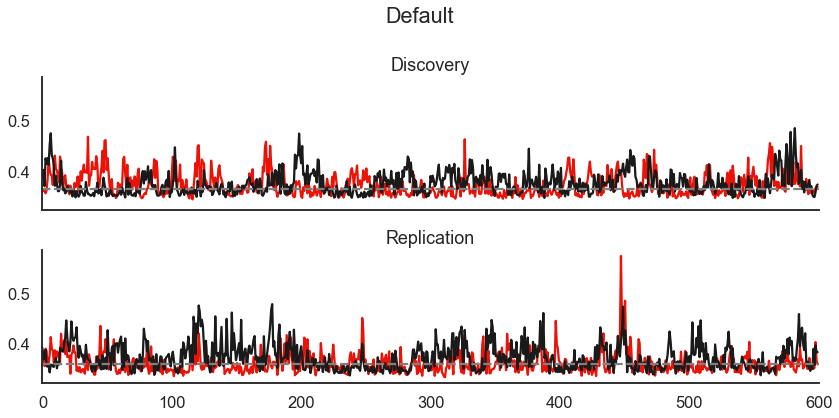

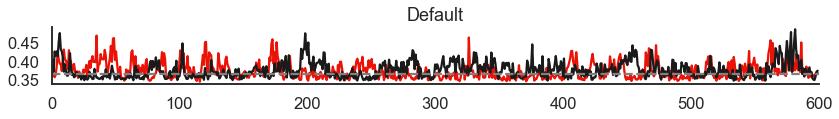

ValueError: Number of rows must be a positive integer, not 0

<Figure size 864x0 with 0 Axes>

In [85]:
interpretable_nets = ['Auditory', 'CinguloOperc', 'Default', 'DorsalAttn', 'FrontoParietal',
                      'SMhand', 'SMmouth', 'Salience', 'VentralAttn', 'Visual']

alpha = np.sqrt(0.05/(len(interpretable_nets)*5))
if alpha>0.05:
    alpha=0.05

# plot lowest and highest on same plot
for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for group in ['older','younger']:
        for movie in ['DM','TP']:
            if movie=='DM':
                video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
                movie_dur=600
            else:
                video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
                movie_dur = 200
            time = np.arange(0,movie_dur, 0.8)
            signet_folder = os.path.join(out_dir, 'similarity_byage','dynamic_movie{0}_{1}_{2}'.format(movie, clin, group),'signetworks_bothmovies')
            out_folder = os.path.join(out_dir, 'similarity_byage','dynamic_movie{0}_{1}_{2}'.format(movie, clin, group),'signetworks_rollt')
            os.makedirs(out_folder, exist_ok=True)

            # load data
            if not os.path.isdir(signet_folder):
                break
            disc_upper_info = pickle.load(open(os.path.join(signet_folder, 'Discovery_raw_signal_data_upper20.pkl'),'rb'))
            disc_upper_mean = np.load(os.path.join(signet_folder, 'disc_upper20_mean_isps_data.npy'))
            disc_lower_info = pickle.load(open(os.path.join(signet_folder, 'Discovery_raw_signal_data_lower20.pkl'),'rb'))
            disc_lower_mean = np.load(os.path.join(signet_folder, 'disc_lower20_mean_isps_data.npy'))
            rep_upper_info = pickle.load(open(os.path.join(signet_folder, 'Replication_raw_signal_data_upper20.pkl'),'rb'))
            rep_upper_mean = np.load(os.path.join(signet_folder,'rep_upper20_mean_isps_data.npy'))
            rep_lower_info = pickle.load(open(os.path.join(signet_folder, 'Replication_raw_signal_data_lower20.pkl'),'rb'))
            rep_lower_mean = np.load(os.path.join(signet_folder, 'rep_lower20_mean_isps_data.npy'))
            # load subject level phase data
            disc_upper = np.memmap(os.path.join(signet_folder, 'disc_upper20_isps_data.dat'),dtype=np.float32, mode='r',
                                   shape=(disc_upper_mean.shape[1], disc_upper_info['upper']['nsubs'], disc_upper_info['upper']['nsubs'], 
                                          disc_upper_mean.shape[0])).T
            disc_lower = np.memmap(os.path.join(signet_folder, 'disc_lower20_isps_data.dat'),dtype=np.float32, mode='r',
                                   shape=(disc_upper_mean.shape[1],disc_lower_info['lower']['nsubs'], disc_lower_info['lower']['nsubs'],
                                          disc_upper_mean.shape[0])).T
            rep_upper = np.memmap(os.path.join(signet_folder, 'rep_upper20_isps_data.dat'),dtype=np.float32, mode='r',
                                   shape=(disc_upper_mean.shape[1],rep_upper_info['upper']['nsubs'], rep_upper_info['upper']['nsubs'],
                                          disc_upper_mean.shape[0])).T
            rep_lower = np.memmap(os.path.join(signet_folder, 'rep_lower20_isps_data.dat'),dtype=np.float32, mode='r',
                                   shape=(disc_upper_mean.shape[1],rep_lower_info['lower']['nsubs'], rep_lower_info['lower']['nsubs'],
                                          disc_upper_mean.shape[0])).T

            # create masks
            disc_upper_mask = np.tri(disc_upper.shape[2], disc_upper.shape[2], -1, dtype=int)
            disc_lower_mask = np.tri(disc_lower.shape[2], disc_lower.shape[2], -1, dtype=int)
            rep_upper_mask = np.tri(rep_upper.shape[2], rep_upper.shape[2], -1, dtype=int)
            rep_lower_mask = np.tri(rep_lower.shape[2], rep_lower.shape[2], -1, dtype=int)

            # load null
            null_dist_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_rubic_movie{0}_{1}'.format(movie, group), 
                                              'perm_null_distribution.npy')
            null_dist = np.load(null_dist_file).flatten()
            n = int(round((len(null_dist)+1)*alpha,0))
            disc_null_thresh = null_dist[len(null_dist)-n]
            null_dist_file = os.path.join(out_dir, 'similarity_byage', 'dynamic_cbic_movie{0}_{1}'.format(movie, group), 
                                          'perm_null_distribution.npy')
            null_dist = np.load(null_dist_file).flatten()
            n = int(round((len(null_dist)+1)*alpha,0))
            rep_null_thresh = null_dist[len(null_dist)-n]

            # identify parcels of interest
            sig_parcs_file = os.path.join(out_dir, 'similarity_byage', 'ts_isc_replicated_movie{0}_{1}_{2}'.format(movie, clin, group),'top_model_fits_replicable.dlabel.nii')
            sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
            model_labels = []
            mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
            model_labels = model_labels[1:]
            model_labels = [a.split('_')[0] for a in model_labels]
            model_labels = np.array(model_labels)

            colors = {'upper':{'box':'gray', 'lower':'k', 'upper':'#eb1207'}, 
                      'lower': {'box':'gray','upper':'k','lower':'#ffd240'}}

            both_data = {}

            for model in ['AnnaKmin','AnnaKmean','AnnaKmaxminmax']:
                # load peak information
                if model=='AnnaKmin' or model=='AnnaKmean':
                    refgroup = 'upper'
                else:
                    refgroup = 'lower'

                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels==model] = 1
                signets = list(np.unique(network_labels[sigparcsmask==1]))
                nois = [a for a in signets if a in interpretable_nets]

                # average across network/region
                disc_upper_mean_net = np.zeros((disc_upper_mean.shape[0], len(nois)))
                disc_lower_mean_net = np.zeros((disc_lower_mean.shape[0], len(nois)))
                rep_upper_mean_net = np.zeros((rep_upper_mean.shape[0], len(nois)))
                rep_lower_mean_net = np.zeros((rep_lower_mean.shape[0], len(nois)))
                disc_upper_net = np.zeros((disc_upper_mean.shape[0], np.sum(disc_upper_mask, axis=None), len(nois)))
                disc_lower_net = np.zeros((disc_lower_mean.shape[0], np.sum(disc_lower_mask, axis=None), len(nois)))
                rep_upper_net = np.zeros((rep_upper_mean.shape[0], np.sum(rep_upper_mask, axis=None), len(nois)))
                rep_lower_net = np.zeros((rep_lower_mean.shape[0], np.sum(rep_lower_mask, axis=None), len(nois)))

                for i, n in enumerate(nois):
                    disc_upper_mean_net[:,i] = np.mean(disc_upper_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    disc_lower_mean_net[:,i] = np.mean(disc_lower_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    rep_upper_mean_net[:,i] = np.mean(rep_upper_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    rep_lower_mean_net[:,i] = np.mean(rep_lower_mean[:,(network_labels==n) & (sigparcsmask==1)], axis=1)
                    disc_upper_net[:,:,i] = np.mean(disc_upper[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, disc_upper_mask==1]
                    disc_lower_net[:,:,i] = np.mean(disc_lower[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, disc_lower_mask==1]
                    rep_upper_net[:,:,i] = np.mean(rep_upper[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, rep_upper_mask==1]
                    rep_lower_net[:,:,i] = np.mean(rep_lower[:, :, :, (network_labels==n) & (sigparcsmask==1)], axis=3)[:, rep_lower_mask==1]

                for i, net in enumerate(nois):
                    fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                    # detect peak differences in synchrony
                    peaks = pd.DataFrame(index=range(0,disc_upper_mean_net.shape[0]))
                    peaks['time'] = time
                    for a in range(0,disc_upper_mean_net.shape[0]):
                        s, p = scp.stats.ttest_ind(disc_upper_net[a,:,i], disc_lower_net[a,:,i])
                        peaks.loc[a,'disc_tstat'] = s
                        peaks.loc[a,'disc_pval'] = p
                        peaks.loc[a,'disc_peak'] = (p<alpha) & (s>0)

                    for a in range(0,disc_upper_mean_net.shape[0]):
                        s, p = scp.stats.ttest_ind(rep_upper_net[a,:,i], rep_lower_net[a,:,i])
                        peaks.loc[a,'rep_tstat'] = s
                        peaks.loc[a,'rep_pval'] = p
                        peaks.loc[a,'rep_peak'] = (p<alpha) & (s>0)

                    peaks['disc_upper_mean'] = disc_upper_mean_net[:,i]
                    peaks['rep_upper_mean'] = rep_upper_mean_net[:,i]
                    peaks['disc_lower_mean'] = disc_lower_mean_net[:,i]
                    peaks['rep_lower_mean'] = rep_lower_mean_net[:,i]

                    both_data[net]={'long_peaks':peaks}
                    peaks['both'] = ((peaks['disc_peak']==1) & (peaks['rep_peak']==1)).astype(int)
                    peaks.loc[[0,1,2,3,4],'both'] = 0
                    peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                    res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                        'end': peaks.groupby('segment').time.last(),
                                        'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                        'disc_upper_mean':peaks.groupby('segment')['disc_upper_mean'].mean(),
                                        'rep_upper_mean':peaks.groupby('segment')['rep_upper_mean'].mean(),
                                        'disc_upper_max':peaks.groupby('segment')['disc_upper_mean'].max(),
                                        'rep_upper_max':peaks.groupby('segment')['rep_upper_mean'].max(),
                                        'disc_lower_mean':peaks.groupby('segment')['disc_lower_mean'].mean(),
                                        'rep_lower_mean':peaks.groupby('segment')['rep_lower_mean'].mean(),
                                        'disc_lower_max':peaks.groupby('segment')['disc_lower_mean'].max(),
                                        'rep_lower_max':peaks.groupby('segment')['rep_lower_mean'].max(),
                                        'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                    peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                    if len(peaks_to_delete)>0:
                        for a in peaks_to_delete.index:
                            both_data[net]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                    peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]
                    both_data[net]['peaks'] = peaks

                    for i_c, c in enumerate(peaks['start']):
                        ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.6)
                        ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.6)

                    # plot traces
                    ax[0].plot(time, disc_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                    ax[0].plot(time, disc_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                    ax[0].axhline(y=disc_null_thresh, color='gray', linestyle='--')
                    ax[0].set_xlim((0,movie_dur))
                    ax[0].set_title('Discovery')            
                    ax[1].plot(time, rep_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                    ax[1].plot(time, rep_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                    ax[1].axhline(y=rep_null_thresh, color='gray', linestyle='--')
                    ax[1].set_xlim((0,movie_dur))
                    ax[1].set_title('Replication')

                    plt.suptitle(net)
                    sns.despine()
                    plt.tight_layout()
                    plt.savefig(os.path.join(out_folder, 'Network_bysite_synchrony_{0}_ref{1}.svg'.format(net, refgroup)))
                    plt.show()
                    plt.close()

                fig, ax = plt.subplots(len(nois),1,figsize=(12,2*len(nois)), sharex=True)
                if len(nois)>1:
                    for i, net in enumerate(nois):  
                        peaks = both_data[net]['peaks']
                        ax[i].plot(time, disc_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                        ax[i].plot(time, disc_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                        ax[i].set_xlim((0,movie_dur))
                        ax[i].set_title(net)
                        ax[i].axhline(y=disc_null_thresh, color='gray', linestyle='--')

                        for i_c, c in enumerate(peaks['start']):
                            ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)
                            ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)
                elif len(nois)==1:
                    peaks = both_data[net]['peaks']
                    ax.plot(time, disc_upper_mean_net[:,i], color=colors[refgroup]['upper'])
                    ax.plot(time, disc_lower_mean_net[:,i], color=colors[refgroup]['lower'])
                    ax.set_xlim((0,movie_dur))
                    ax.set_title(net)
                    ax.axhline(y=disc_null_thresh, color='gray', linestyle='--')

                    for i_c, c in enumerate(peaks['start']):
                        ax.axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)
                        ax.axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=colors[refgroup]['box'],fill=True, alpha=0.4)

                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'Networks_all_synchrony_diff_ref{0}.svg'.format(refgroup)))
                plt.show()
                plt.close()

                ### Find differences in peak versus non-peak in terms of video features
                for net in nois:
                    peak_mask = both_data[net]['long_peaks']['both'].to_numpy()
                    ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                    out_file = os.path.join(out_folder, '{0}_peak_differences_ref{1}.svg'.format(net, refgroup))
                    if (peak_mask.max()==1):
                        both_data[net]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                       color=colors[refgroup]['box'], TR=TR, alpha=0.05, fdr=True, shift=6) # shift is in TRs here

                ### find which clips are promoting the most activation
                for net in nois:
                    peaktimes = both_data[net]['peaks']
                    peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_{0}_mean'.format(refgroup),'rep_{0}_mean'.format(refgroup)]].mean(axis=1)
                    peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_{0}_max'.format(refgroup),'rep_{0}_max'.format(refgroup)]].mean(axis=1)
                    peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                    peaktimes.index = range(1, len(peaktimes)+1)
                    both_data[net]['peak_qual_analysis'] = peaktimes
                    outfolder = os.path.join(out_folder, 'clips_{0}_ref-{1}'.format(net,refgroup))
                    os.makedirs(outfolder, exist_ok=True)
                    peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_ref{1}.csv'.format(net,refgroup)))
                    shift = 5 #in seconds
                    ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                    match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                        bool_list=['faces','body','closeup','spoken_words','written_words'],
                                        dim_list=['positive','negative','brightness','loudness','saliency'])

                f = open(os.path.join(out_folder, 'final_peaks_data_comparison_ref{0}.pkl'.format(refgroup)),'wb')
                pickle.dump(both_data,f)

### Examine top fitting parcels

In [ ]:
ntopparcs = 5

for clin in ['MFQ_P_Total','MFQ_SR_Total','SCARED_P_SC', 'SCARED_SR_SC']:
    for movie in ['DM','TP']:
        if movie=='DM':
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/Despicable_Me_1000.mp4'
            movie_dur=600
        else:
            video_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/Videos/The_Present_0321.mp4'
            movie_dur = 200
        for sxs in ['upper','lower']:
            # identify subsample for each clinical measure
            discinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            discsubs = np.isfinite(discinfo[clin]).to_numpy()
            discmetric = discinfo.loc[np.isfinite(discinfo[clin]), clin].to_numpy()
            repinfo = pd.read_csv(os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie),'subject_info.csv'), index_col=0)
            repsubs = np.isfinite(repinfo[clin]).to_numpy()
            repmetric = repinfo.loc[np.isfinite(repinfo[clin]), clin].to_numpy()
            
            sig_parcs_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),'top_model_fits_replicable.dlabel.nii')
            sig_models = nib.load(sig_parcs_file).header.get_axis(0).label[0]
            model_labels = []
            mapping = [model_labels.append(a) for (a,b) in sig_models.values()]
            model_labels = model_labels[1:]
            model_labels = [a.split('_')[0] for a in model_labels]
            model_labels = np.array(model_labels)
            
            if sxs=='upper':
                color = '#eb1207'
                cifticolor = (235/255, 18/255, 7/255, 1)
                dcutoff = np.percentile(discmetric, 80)
                rcutoff = np.percentile(repmetric, 80)
                discmask = ((discinfo[clin]>=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]>=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmin'] = 1
                sigparcs = list(parcel_labels[sigparcsmask==1])
                sig_rho_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),
                                            'movie{0}_isc_{1}_AnnaKmin_maskedrho_fdr0.01127.pscalar.nii'.format(movie, clin))
                sigrho = np.squeeze(nib.load(sig_rho_file).get_fdata())
                sigrho[sigparcsmask==0]=0
                sigorder = np.argsort(sigrho)
                sigparclabels_ordered =  parcel_labels[sigorder]
                pois = np.flip(sigparclabels_ordered[-ntopparcs:])
                
            else:
                color = '#ffe600'
                cifticolor = (255/255, 230/255, 0/255, 1)
                dcutoff = np.percentile(discmetric, 20)
                rcutoff = np.percentile(repmetric, 20)
                discmask = ((discinfo[clin]<=dcutoff) & discsubs).astype(int)
                repmask = ((repinfo[clin]<=rcutoff) & repsubs).astype(int)
                
                # identify sig parcels from sim analysis
                sigparcsmask = np.zeros(network_labels.shape)
                sigparcsmask[model_labels=='AnnaKmaxminmax'] = 1
                sigparcs = list(parcel_labels[sigparcsmask==1])
                sig_rho_file = os.path.join(out_dir, 'similarity', 'ts_isc_movie{0}_{1}'.format(movie, clin),
                                            'movie{0}_isc_{1}_AnnaKmaxminmax_maskedrho_fdr0.01127.pscalar.nii'.format(movie, clin))
                sigrho = np.squeeze(nib.load(sig_rho_file).get_fdata())
                sigrho[sigparcsmask==0]=0
                sigorder = np.argsort(sigrho)
                sigparclabels_ordered =  parcel_labels[sigorder]
                pois = np.flip(sigparclabels_ordered[-ntopparcs:])
            
            discovery_data = {'color':color, sxs: {'mask': discmask, 'cutoff': dcutoff}}
            replication_data = {'color':color,sxs: {'mask': repmask, 'cutoff': rcutoff}}
            both_data = {'color':color,'parcel_info':{}}
            time = np.arange(0,movie_dur, 0.8)

            ratings_file = os.path.join(project_dir, 'HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie))
            out_folder = os.path.join(out_dir, 'similarity','dynamic_movie{0}_{1}'.format(movie, clin), 'top_parcs')
            os.makedirs(out_folder, exist_ok=True)

            # load discovery data
            disc_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_rubic_movie{0}'.format(movie), 
                                           'phase_data_rubic_movie{0}.npy'.format(movie))
            disc_phase = np.load(disc_phase_file)[:,:, discmask==1]
            out_prefix = os.path.join(out_folder, 'disc_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                disc_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                disc_mean_sim, _ = compute_isps(disc_phase, out_prefix)
            if disc_mean_sim.shape[1]!=len(parcel_labels):
                disc_mean_sim = disc_mean_sim.T

            # load replication data
            rep_phase_file = os.path.join(out_dir, 'similarity', 'dynamic_cbic_movie{0}'.format(movie), 
                                          'phase_data_cbic_movie{0}.npy'.format(movie))
            rep_phase = np.load(rep_phase_file)[:,:, repmask==1]
            out_prefix = os.path.join(out_folder, 'rep_{0}20_'.format(sxs))
            if os.path.isfile(out_prefix + 'mean_isps_data.npy'):
                rep_mean_sim = np.load(out_prefix + 'mean_isps_data.npy')
            else:
                rep_mean_sim, _ = compute_isps(rep_phase, out_prefix)
            if rep_mean_sim.shape[1]!=len(parcel_labels):
                rep_mean_sim = rep_mean_sim.T

            for i, n in enumerate(pois):
                both_data['parcel_info'][n] = {}

                # make label file for sig parcels
                ax1 = nib.load(atlas_file).header.get_axis(1)
                data = nib.load(atlas_file).get_fdata()
                ax0 = nib.load(atlas_file).header.get_axis(0)
                newmap=dict()
                newmap[0] = ax0[0][1][0]
                for a in range(1,len(parcel_labels) +1):
                    if parcel_labels[a-1]==n:
                        newmap[a] = (parcel_labels[a-1], cifticolor)
                    else:
                        newmap[a] = (parcel_labels[a-1], (1,1,1,0))
                ax0.label[0] = newmap
                img = nib.cifti2.cifti2.Cifti2Image(data, (ax0, ax1))
                nib.save(img, os.path.join(out_folder, 'sig_parc_{0}_{1}20.dlabel.nii'.format(n, sxs)))

            #### plot synchrony ####
            for i, p in enumerate(pois):
                fig, ax = plt.subplots(2,1,figsize=(12,6), sharex=True, sharey=True)
                # detect peaks in activation based on 2SDs above the mean
                discmean = np.mean(disc_mean_sim[:,(parcel_labels==p)])
                discmin = discmean + 1.5*np.std(disc_mean_sim[:,(parcel_labels==p)])
                print(discmin)
                dcpeaks, dcproperties = scs.find_peaks(np.squeeze(disc_mean_sim[:,(parcel_labels==p)]), width=5, height=discmin)

                repmean = np.mean(rep_mean_sim[:,(parcel_labels==p)])
                repmin = repmean + 1.5*np.std(rep_mean_sim[:,(parcel_labels==p)])
                print(repmin)
                rcpeaks, rcproperties = scs.find_peaks(np.squeeze(rep_mean_sim[:,(parcel_labels==p)]), width=5, height=repmin)

                peaks = pd.DataFrame(0,index=np.arange(0,movie_dur, TR), columns=['disc','rep'])
                peaks['time'] = np.arange(0,movie_dur, TR)
                for i_c, c in enumerate(dcproperties['prominences']):
                    peaks.loc[dcproperties['left_ips'][i_c]*TR:dcproperties['right_ips'][i_c]*TR, 'disc'] = 1
                for i_c, c in enumerate(rcproperties['prominences']):
                    peaks.loc[rcproperties['left_ips'][i_c]*TR:rcproperties['right_ips'][i_c]*TR, 'rep'] = 1
                peaks['disc_mean'] = disc_mean_sim[:,(parcel_labels==p)]
                peaks['rep_mean'] = rep_mean_sim[:,(parcel_labels==p)]
                both_data[p]={'long_peaks':peaks}
                peaks['both'] = ((peaks['disc']==1) & (peaks['rep']==1)).astype(int)
                peaks['segment'] = (peaks['both'].diff(1) != 0).astype(int).cumsum()
                res = pd.DataFrame({'start': peaks.groupby('segment').time.first(),
                                    'end': peaks.groupby('segment').time.last(),
                                    'dur': peaks.groupby('segment').time.last()-peaks.groupby('segment').time.first(),
                                    'disc_mean':peaks.groupby('segment')['disc_mean'].mean(),
                                    'rep_mean':peaks.groupby('segment')['rep_mean'].mean(),
                                    'disc_max':peaks.groupby('segment')['disc_mean'].max(),
                                    'rep_max':peaks.groupby('segment')['rep_mean'].max(),
                                    'value': peaks.groupby('segment')['both'].mean()}).reset_index(drop=True)
                peaks_to_delete = res.loc[(res['value'] == 1) & (res['dur']<4), :]
                if len(peaks_to_delete)>0:
                    for a in peaks_to_delete.index:
                        both_data[p]['long_peaks'].loc[peaks_to_delete.loc[a,'start']:peaks_to_delete.loc[a,'end'], 'both'] = 0
                peaks = res.loc[(res['value'] == 1) & (res['dur']>=4), :]

                for i_c, c in enumerate(peaks['start']):
                    ax[0].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[1].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

                # plot traces
                ax[0].plot(time, disc_mean_sim[:,parcel_labels==p], color='k')
                ax[0].set_xlim((0,movie_dur))
                ax[0].set_title('Discovery')            
                ax[1].plot(time, rep_mean_sim[:,parcel_labels==p], color='k')
                ax[1].set_xlim((0,movie_dur))
                ax[1].set_title('Replication')

                both_data[p]['peaks'] = peaks
                plt.suptitle(p)
                sns.despine()
                plt.tight_layout()
                plt.savefig(os.path.join(out_folder, 'parc_bysite_synchrony_{0}_{1}20.svg'.format(p, sxs)))
                plt.show()
                plt.close()

            fig, ax = plt.subplots(len(pois),1,figsize=(12,2*len(pois)), sharex=True)
            for i, p in enumerate(pois):    
                ax[i].plot(time, disc_mean_sim[:,parcel_labels==p], color='k')
                ax[i].set_xlim((0,movie_dur))
                ax[i].set_title(p)

                peaks = both_data[p]['peaks']
                for i_c, c in enumerate(peaks['start']):
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)
                    ax[i].axvspan(peaks['start'].to_numpy()[i_c], peaks['end'].to_numpy()[i_c], color=both_data['color'],fill=True, alpha=0.6)

            sns.despine()
            plt.tight_layout()
            plt.savefig(os.path.join(out_folder, 'parcels_all_synchrony_{0}20.svg'.format(sxs)))
            plt.show()
            plt.close()

            ### Find differences in peak versus non-peak in terms of video features
            for p in pois:
                peak_mask = both_data[p]['long_peaks']['both'].to_numpy()
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes_intuitivenames.csv'.format(movie)
                out_file = os.path.join(out_folder, '{0}_peak_differences_{1}20.svg'.format(p,sxs))
                if (peak_mask.max()==1):
                    both_data[p]['peak_quant_analysis'] = find_peak_rating_diffs(peak_mask, ratings_file, movie_dur, out_file, 
                                                                                   color=both_data['color'], TR=TR, alpha=0.05, fdr=True, shift=6)

            ### find which clips are promoting the most activation
            for p in pois:
                peaktimes = both_data[p]['peaks']
                peaktimes.loc[:,'meanact'] = peaktimes.loc[:,['disc_mean','rep_mean']].mean(axis=1)
                peaktimes.loc[:,'maxact'] = peaktimes.loc[:,['disc_max','rep_max']].mean(axis=1)
                peaktimes = peaktimes.sort_values(by='maxact', ascending=False)
                peaktimes.index = range(1, len(peaktimes)+1)
                both_data[p]['peak_qual_analysis'] = peaktimes
                outfolder = os.path.join(out_folder, 'clips_{0}_{1}20'.format(p,sxs))
                os.makedirs(outfolder, exist_ok=True)
                peaktimes.to_csv(os.path.join(outfolder, 'peak_analysis_{0}_{1}20.csv'.format(p,sxs)))
                shift = 5 #in seconds
                ratings_file = '/Users/catcamacho/Library/CloudStorage/Box-Box/CCP/HBN_study/HBN_video_coding/processing/summary/{0}_summary_codes10Hz_intuitivenames.csv'.format(movie)
                match_peak_to_clips(peaktimes, shift, video_file, outfolder, ratings_file, 
                                    bool_list=['faces','body','closeup','spoken_words','written_words'],
                                    dim_list=['positive','negative','brightness','loudness','saliency'])

            ## pickle results
            f = open(os.path.join(out_folder, 'Discovery_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(discovery_data,f)
            f = open(os.path.join(out_folder, 'Replication_raw_signal_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(replication_data,f)
            f = open(os.path.join(out_folder, 'final_peaks_data_{0}20.pkl'.format(sxs)),'wb')
            pickle.dump(both_data,f)